<div style="display: flex; background-color: #2B47D9;" >
<h1 style="margin: auto; padding: 30px; ">Analysez les ventes d'une librairie avec R ou Python</h1>
</div>

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Importation des librairies</h3>
</div>

In [1]:
#Importation des librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import levene, kruskal, wilcoxon
import missingno as msno
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.stattools import jarque_bera  
from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.stats.diagnostic import acorr_ljungbox
import scikit_posthocs as sp
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multitest import multipletests
from pmdarima.model_selection import train_test_split
from tabulate import tabulate
from itertools import combinations
import warnings
import darts as dts
from darts.utils.statistics import plot_acf, check_seasonality
from darts import TimeSeries

In [2]:
# Afficher toutes les colonnes d'un dataframe
pd.set_option("display.max_columns", None)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargements des fichiers</h3>
</div>

In [3]:
#Importation du fichier web.xlsx
df_customers = pd.read_csv("customers.csv", delimiter=';')

#Importation du fichier erp.xlsx
df_products = pd.read_csv("products.csv", delimiter=';')

#importation du fichier liaison.xlsx
df_transactions = pd.read_csv("transactions.csv", delimiter=';')

C:\Users\jerem\AppData\Local\Temp\ipykernel_17296\3914954374.py:8: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv("transactions.csv", delimiter=';')


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.3 - Chargements des fonctions</h3>
</div>

In [4]:
# Création de la fonction description variables ou dataset

def description_variables(df):
    # Afficher le type de la variable
    type_variable = df.dtypes

    # Nombre de lignes totales
    nb_lignes = len(df.index)

    # Nombre total de valeurs dans chaque colonne
    total_values = df.count() 

    # Nombre de valeurs uniques dans chaque colonnes
    valeurs_uniques = df.nunique()

    # Calculer le nombre de valeurs manquantes pour chaque colonne
    missing_counts = df.isnull().sum()
    
    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percentage = (missing_counts / df.shape[0] * 100).round(2)

    
    # Créer un DataFrame avec les résultats
    variables_infos = pd.DataFrame({
        'type' : type_variable,
        'total' : nb_lignes,
        'n': total_values,
        'unique' : valeurs_uniques,
        #'doublons' : nb_doublons,
        'NaN': missing_counts,
        'pourcentage_(NaN)': missing_percentage
    })
    
     # Trier par 'pourcentage_(NaN)' dans l'ordre décroissant
    variables_infos = variables_infos.sort_values(by='pourcentage_(NaN)', ascending=False)
    
    print("Description donnée(s):")
    print("Le jeu de données comporte: {} observation(s)".format(df.shape[0]))
    print("Le jeu de données comporte: {} colonne(s)".format(df.shape[1]))

    return variables_infos

In [5]:
# Fonction pour les variables quantitatives

def statistiques_descriptives(data):
    # Vérifier si l'argument est une Series ou un DataFrame
    if isinstance(data, pd.Series):
        df = data.to_frame()
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        raise TypeError("L'argument doit être une Series ou un DataFrame de pandas")
    
    # Sélectionner seulement les colonnes numériques
    df_numeric = df.select_dtypes(include='number')
    
    # Nombre total de valeurs dans chaque colonne
    valeurs_totales = df_numeric.count()
    # Nombre de valeurs uniques dans chaque colonne
    valeurs_uniques = df_numeric.nunique()
    # Valeur minimum dans chaque colonne 
    minimum = df_numeric.min()
    # Moyenne dans chaque colonne
    moyenne = df_numeric.mean()
    # 1er quantile dans chaque colonne
    q1 = df_numeric.quantile(0.25)
    # Mediane dans chaque colonne
    mediane = df_numeric.median()
    # 3e quantile dans chaque colonne
    q3 = df_numeric.quantile(0.75)
    # Calcul de l'intervalle interquartile - IQR
    iqr = q3 - q1
    # Valeur maximum dans chaque colonne
    maximum = df_numeric.max()
    # Ecart-type dans chaque colonne
    std = df_numeric.std()
    # Variance dans chaque colonne
    variance = df_numeric.var()
    # Skewness dans chaque colonne
    skewness = df_numeric.skew()
    # Kurtosis dans chaque colonne
    kurtosis = df_numeric.kurtosis()

    # Créer un DataFrame avec les résultats
    stats_descriptives = pd.DataFrame({
        'n': valeurs_totales,
        'unique': valeurs_uniques,
        'min': minimum,
        'max': maximum,
        'moy': moyenne,
        'mediane': mediane,
        'q1': q1,
        'iqr': iqr,
        'q3': q3,
        'std': std,
        'var': variance,
        'skew': skewness,
        'kurt': kurtosis
    })

    print("Statistiques descriptives:")
    return stats_descriptives

In [6]:
def categorielles_statistiques(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Nombre d'observations non manquantes
    nobs = df[categorical_cols].notna().sum()
    
    # Nombre d'observations manquantes
    missing = df[categorical_cols].isna().sum()
    
    # Nombre de catégories distinctes
    distinct = df[categorical_cols].nunique()
    
    # La catégorie la plus fréquente (modale)
    top = df[categorical_cols].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # La fréquence de la catégorie la plus fréquente
    freq = df[categorical_cols].apply(lambda x: x.value_counts().iloc[0] if not x.value_counts().empty else 0)
    
    # Combine all statistics into a single DataFrame
    stats = pd.DataFrame({
        'nobs': nobs,
        'missing': missing,
        'distinct': distinct,
        'top': top,
        'freq': freq
    })
    
    return stats

In [7]:
def frequency_table(df, column):
    """
    Crée un tableau de fréquence pour une variable catégorielle dans un DataFrame.
    
    Args:
    - df : DataFrame contenant les données
    - column : Nom de la colonne pour laquelle on souhaite calculer le tableau de fréquence
    
    Returns:
    - DataFrame : Tableau de fréquence avec fréquences et fréquences cumulées en pourcentage
    """
    # Vérifier si la colonne existe dans le DataFrame
    if column not in df.columns:
        raise ValueError(f"La colonne '{column}' n'existe pas dans le DataFrame.")
    
    # Calculer les fréquences des modalités
    freq_counts = df[column].value_counts()
    total_count = freq_counts.sum()
    
    # Créer le tableau de fréquence
    freq_table = pd.DataFrame({
        'Frequency': freq_counts,
        'Percentage': (freq_counts / total_count) * 100
    }).reset_index()
    freq_table.columns = [column, 'Frequency', 'Percentage']
    
    # Calculer les fréquences cumulées
    freq_table['Cumulative Frequency'] = freq_table['Frequency'].cumsum()
    
    # Calculer les fréquences cumulées en pourcentage
    freq_table['Cumulative Percentage'] = (freq_table['Cumulative Frequency'] / total_count) * 100
    
    return freq_table

In [8]:
def zscore(df, ident, column, as_dataframe=False):
    """
    Calcule le Z-score pour une colonne spécifique d'un DataFrame.
    
    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        column (str): Le nom de la colonne pour laquelle calculer le Z-score.
        
    Returns:
        pd.Series: Les Z-scores de la colonne spécifiée.
    """
    # Calcul de la moyenne et de l'écart-type
    mean_val = df[column].mean()
    std_val = df[column].std()

    # Calcul des Z-scores
    z_scores = (df[column] - mean_val) / std_val

    # Retourner un DataFrame si as_dataframe est True
    if as_dataframe:
        return pd.DataFrame({ ident: df[ident], column: df[column], f'{column}_zscore': z_scores})

    return z_scores

In [9]:
# Création de la fonction iqr_outliers

def iqr_outliers(df, column):
    """
    Détecte les outliers dans une colonne d'un DataFrame à l'aide de la méthode IQR et affiche la liste des outliers.
    
    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        column (str): Le nom de la colonne pour laquelle détecter les outliers.
        
    Returns:
        pd.DataFrame: Un DataFrame contenant les outliers détectés.
    """
    # Calculer Q1 et Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculer l'IQR
    IQR = Q3 - Q1

    # Définir les seuils pour les outliers
    lower_bound = Q1 - 1.5 * IQR  # Borne inférieure
    upper_bound = Q3 + 1.5 * IQR  # Borne supérieure

    # Détecter les outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Compter les outliers
    nb_outliers = len(outliers)
    
    # Proportion d'outliers
    pourcentage_outliers = nb_outliers / len(df[column]) * 100

    # Affichage des résultats
    print(f"Nombre d'outliers : {nb_outliers}")
    print(f"Pourcentage d'outliers : {pourcentage_outliers:.2f}%")
    print(f"Borne inférieure : {lower_bound:.2f}")
    print(f"Borne supérieure : {upper_bound:.2f}")
    
    # Affichage de la liste des outliers
    if not outliers.empty:
        print("\nListe des outliers :")
        print(outliers)
    else:
        print("\nAucun outlier détecté.")

    # Retourner le DataFrame contenant les outliers
    return outliers

In [10]:
def kruskal_wallis_test(df, facteur, variable_dep, alpha=0.05):
    # Séparer les valeurs par groupe sans filtrer les outliers
    groups = [group[variable_dep].values for name, group in df.groupby(facteur)]

    # Effectuer le test de Kruskal-Wallis
    stat, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis: Stat={stat}, p-value={p_value}")
    
    results_summary = [["Test", "Statistique", "p-value", "Conclusion"]]
    
    if p_value < alpha:
        conclusion = "Significatif"
        
        # Calcul de l'eta-carré pour mesurer la taille de l'effet
        eta_squared = (stat - len(df[facteur].unique()) + 1) / (len(df) - 1)
        print(f"Eta-carré pour Kruskal-Wallis : {eta_squared}")

        print("Test Kruskal-Wallis significatif, exécution des tests post-hoc de Dunn")

        # Test post-hoc de Dunn sans filtrage des outliers
        dunn_results = sp.posthoc_dunn(df, val_col=variable_dep, group_col=facteur, p_adjust='bonferroni')
        print("Test post-hoc de Dunn :")
        print(dunn_results)

        # Résumé du test de Kruskal-Wallis
        results_summary.append(["Kruskal-Wallis", f"{stat:.3f}", f"{p_value:.5f}", "Différences significatives"])
        results_summary.append(["Eta-carré", f"{eta_squared:.3f}", "-", "Taille de l'effet"])

        # Ajouter les résultats de Dunn au résumé
        for i, j in combinations(df[facteur].unique(), 2):
            p_val = dunn_results.loc[i, j]
            if p_val < alpha:
                results_summary.append([f"Dunn post-hoc {i} vs {j}", "-", f"{p_val:.5f}", "Significatif"])
            else:
                results_summary.append([f"Dunn post-hoc {i} vs {j}", "-", f"{p_val:.5f}", "Non significatif"])

        # Création du boxplot avec les outliers
        plt.figure(figsize=(8, 6))
        ax = sns.boxplot(x=facteur, y=variable_dep, hue=facteur, data=df, palette=["#2B47D9", "#4BA6EE", "#B6E4EE"])
        plt.title(f'Boxplot de {variable_dep} par {facteur} (avec outliers)')
        plt.tight_layout()
        plt.show()

        # Comparaisons par paires significatives
        significant_comparisons = []
        for i, j in combinations(df[facteur].unique(), 2):
            if dunn_results.loc[i, j] < alpha:  # Si la p-value est < alpha
                significant_comparisons.append((i, j))

        # Fonction pour ajouter des lignes indiquant les comparaisons significatives
        def add_significance_lines(comparisons, y_offset=1.05):
            for (i, j) in comparisons:
                x1, x2 = df[facteur].unique().tolist().index(i), df[facteur].unique().tolist().index(j)
                y, h, col = df[variable_dep].max() * y_offset, 5, 'k'
                ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax.text((x1 + x2) * .5, y+h, "*", ha='center', va='bottom', color=col, fontsize=15)

        # Ajouter les lignes pour les groupes significativement différents
        plt.figure(figsize=(8, 6))
        ax = sns.boxplot(x=facteur, y=variable_dep, data=df, palette=["#2B47D9", "#4BA6EE", "#B6E4EE"])
        add_significance_lines(significant_comparisons, y_offset=1.10)
        plt.title(f'Boxplot des résultats de Kruskal-Wallis avec les paires significatives')
        plt.tight_layout()
        plt.show()

    else:
        conclusion = "Non significatif"
        results_summary.append(["Kruskal-Wallis", f"{stat:.3f}", f"{p_value:.5f}", "Aucune différence significative"])

    print(f"Conclusion : {conclusion}")

    # Afficher la synthèse avec tabulate
    print("\nSynthèse des résultats :")
    print(tabulate(results_summary, headers="firstrow", tablefmt="github"))

    return conclusion


In [11]:
def anova_type_2(df, facteur, variable_dep, remove_outliers=False):
    """
    Effectue une ANOVA à un facteur de type 2 avec vérification des conditions, suppression des outliers, et test post-hoc
    df : DataFrame contenant les données
    facteur : nom de la colonne représentant le facteur catégorique
    variable_dep : nom de la colonne représentant la variable dépendante
    remove_outliers : bool, si True, supprime les valeurs aberrantes avant l'analyse
    """
    # Initialiser un DataFrame filtré pour stocker les données sans outliers
    df_filtered = df.copy()

    if remove_outliers:
        # 1. Vérifier les valeurs aberrantes avec l'IQR dans chaque catégorie du facteur
        outliers_count = 0
        for group in df[facteur].unique():
            group_data = df[df[facteur] == group][variable_dep]
            Q1 = group_data.quantile(0.25)
            Q3 = group_data.quantile(0.75)
            IQR = Q3 - Q1

            # Détecter les outliers pour chaque groupe
            group_outliers = df[(df[facteur] == group) & ((df[variable_dep] < (Q1 - 1.5 * IQR)) | (df[variable_dep] > (Q3 + 1.5 * IQR)))]

            outliers_count += len(group_outliers)
            # Supprimer les outliers du DataFrame filtré
            df_filtered = df_filtered[~df_filtered.index.isin(group_outliers.index)]

        print(f"Attention : {outliers_count} valeurs aberrantes détectées et supprimées.")
    else:
        print("Aucune suppression d'outliers demandée.")
    
    # Créer des boxplots des valeurs avant suppression d'outliers
    palette_custom = ["#2B47D9", "#4BA6EE", "#B6E4EE"]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=facteur, y=variable_dep, data=df, palette=palette_custom)
    plt.title('Boxplot des valeurs avec outliers')

    if remove_outliers:
        plt.subplot(1, 2, 2)
        sns.boxplot(x=facteur, y=variable_dep, data=df_filtered, palette=palette_custom)
        plt.title('Boxplot des valeurs après suppression des outliers')
    
    plt.tight_layout()
    plt.show()

    # Tracer les histogrammes + lignes de densité pour chaque groupe dans un subplot (1, 3)
    unique_groups = df_filtered[facteur].unique()
    num_groups = len(unique_groups)
    
    fig, axes = plt.subplots(1, num_groups, figsize=(18, 6), sharey=True)
    fig.suptitle('Distributions avec lignes de densité par groupe', fontsize=16)

    for i, group in enumerate(unique_groups):
        sns.histplot(df_filtered[variable_dep][df_filtered[facteur] == group], color='#4BA6EE', kde=True, stat="density", 
                     line_kws={'color': '#091A29', 'linewidth': 2}, ax=axes[i])
        axes[i].set_title(f"Groupe {group}")
        axes[i].set_xlabel(variable_dep)
        axes[i].set_ylabel('Densité')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuste pour éviter le chevauchement du titre
    plt.show()

    # Test de normalité de Jarque-Bera pour chaque groupe
    normality_failed = False  # Initialise une variable pour suivre les échecs de normalité
    for group in unique_groups:
        group_data = df_filtered[variable_dep][df_filtered[facteur] == group]
        jb_test = st.jarque_bera(group_data)

        # Vérifier si le test échoue pour un groupe
        if jb_test.pvalue < 0.05:
            normality_failed = True

        # Afficher les résultats sous forme de tableau
        table = [
            ['Statistique de Jarque-Bera', jb_test.statistic],
            ['P-valeur', jb_test.pvalue],
            ['Conclusion', 'Les résidus suivent une distribution normale' if jb_test.pvalue > 0.05 else 'Les résidus ne suivent pas une distribution normale']
        ]
        print(f"\nRésultats du test Jarque-Bera pour le groupe {group} :")
        print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

    # 3. Test d'homogénéité des variances (Levene)
    groups = [df_filtered[variable_dep][df_filtered[facteur] == group] for group in df_filtered[facteur].unique()]
    levene_test = st.levene(*groups)

    print(f"\nTest de Levene pour l'homogénéité des variances : p-value = {levene_test.pvalue}")
    variance_failed = levene_test.pvalue < 0.05  # Vérifier si le test de Levene échoue

    if variance_failed:
        print("Attention : Les variances ne sont pas homogènes entre les groupes.")
    
    # Si les tests de normalité **et** d'homogénéité échouent, recommander un test non paramétrique
    if normality_failed and variance_failed:
        print("\nAttention, les conditions de validité du test paramétrique ne sont pas respectées. Effectuer un test non paramétrique : Kruskal-Wallis.")
        return
    
    # 4. Effectuer l'ANOVA de type 2
    model = ols(f'{variable_dep} ~ C({facteur})', data=df_filtered).fit()
    anova_results = anova_lm(model, typ=2)
    print("\nRésultats de l'ANOVA :\n", anova_results)

    # Vérifier si l'ANOVA est significative
    if anova_results["PR(>F)"][0] < 0.05:
        print("\nL'ANOVA est significative. Effectuer un test post-hoc (Tukey).")

        # 5. Test post-hoc de Tukey si l'ANOVA est significative
        tukey_results = pairwise_tukeyhsd(df_filtered[variable_dep], df_filtered[facteur])
        print("\nRésultats du test post-hoc de Tukey :\n", tukey_results)

        # Tracer les résultats du test de Tukey
        tukey_results.plot_simultaneous()
        plt.title("Test post-hoc de Tukey : Comparaison des moyennes")
        plt.show()

    else:
        print("L'ANOVA n'est pas significative. Pas besoin d'effectuer un test post-hoc.")

    # Tracer les résidus pour évaluer la normalité
    sm.qqplot(model.resid, line='s')
    plt.title("QQ-plot des résidus")
    plt.show()

    # Tracer les boxplots des groupes pour visualiser la distribution des données
    sns.boxplot(x=facteur, y=variable_dep, data=df_filtered, palette=palette_custom)
    plt.title(f"Boxplot des groupes {facteur} vs {variable_dep}")
    plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Préparer et nettoyer les données</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Analyse du fichier customers</h3>
</div>

In [12]:
# Descriptions des variables du dataset customers
description_variables(df_customers)

Description donnée(s):
Le jeu de données comporte: 8621 observation(s)
Le jeu de données comporte: 3 colonne(s)


type  total     n  unique  NaN  pourcentage_(NaN)
client_id  object   8621  8621    8621    0                0.0
sex        object   8621  8621       2    0                0.0
birth       int64   8621  8621      76    0                0.0

In [13]:
# Afficher les premières valeurs
df_customers.head()

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

In [14]:
# Recoder la variable birth en variable de type date
df_customers['birth'] = pd.to_datetime(df_customers['birth'], format='%Y')

# Recoder la variable sex en variable categorielle
df_customers['sex'] = df_customers['sex'].astype('category')

In [15]:
description_variables(df_customers)

Description donnée(s):
Le jeu de données comporte: 8621 observation(s)
Le jeu de données comporte: 3 colonne(s)


type  total     n  unique  NaN  pourcentage_(NaN)
client_id          object   8621  8621    8621    0                0.0
sex              category   8621  8621       2    0                0.0
birth      datetime64[ns]   8621  8621      76    0                0.0

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Analyse du fichier products</h3>
</div>

In [16]:
# Descriptions des variables du dataset products
description_variables(df_products)

Description donnée(s):
Le jeu de données comporte: 3286 observation(s)
Le jeu de données comporte: 3 colonne(s)


type  total     n  unique  NaN  pourcentage_(NaN)
id_prod   object   3286  3286    3286    0                0.0
price    float64   3286  3286    1454    0                0.0
categ      int64   3286  3286       3    0                0.0

In [17]:
# Afficher les premières lignes du dataset
df_products.head()

id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

In [18]:
# Recoder la variable sex en variable categorielle
df_products['categ'] = df_products['categ'].astype('category')

In [19]:
# Descriptions des variables du dataset products
description_variables(df_products)

Description donnée(s):
Le jeu de données comporte: 3286 observation(s)
Le jeu de données comporte: 3 colonne(s)


type  total     n  unique  NaN  pourcentage_(NaN)
id_prod    object   3286  3286    3286    0                0.0
price     float64   3286  3286    1454    0                0.0
categ    category   3286  3286       3    0                0.0

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.3 - Analyse du fichier transactions</h3>
</div>

In [20]:
# Descriptions des variables du dataset transactions
description_variables(df_transactions)

Description donnée(s):
Le jeu de données comporte: 1048575 observation(s)
Le jeu de données comporte: 4 colonne(s)


type    total       n  unique     NaN  pourcentage_(NaN)
id_prod     object  1048575  687534    3265  361041              34.43
date        object  1048575  687534  687419  361041              34.43
session_id  object  1048575  687534  345505  361041              34.43
client_id   object  1048575  687534    8600  361041              34.43

In [21]:
df_transactions.head()

id_prod                        date session_id client_id
0  0_1259  2021-03-01 00:01:07.843138        s_1     c_329
1  0_1390  2021-03-01 00:02:26.047414        s_2     c_664
2  0_1352  2021-03-01 00:02:38.311413        s_3     c_580
3  0_1458  2021-03-01 00:04:54.559692        s_4    c_7912
4  0_1358  2021-03-01 00:05:18.801198        s_5    c_2033

In [22]:
# Recoder la variable date au format datetime
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [23]:
description_variables(df_transactions)

Description donnée(s):
Le jeu de données comporte: 1048575 observation(s)
Le jeu de données comporte: 4 colonne(s)


type    total       n  unique     NaN  pourcentage_(NaN)
id_prod             object  1048575  687534    3265  361041              34.43
date        datetime64[ns]  1048575  687534  687415  361041              34.43
session_id          object  1048575  687534  345505  361041              34.43
client_id           object  1048575  687534    8600  361041              34.43

In [24]:
# Vérifier les lignes qui contiennent des NaN
df_transactions[df_transactions.id_prod.isna()]

id_prod date session_id client_id
687534      NaN  NaT        NaN       NaN
687535      NaN  NaT        NaN       NaN
687536      NaN  NaT        NaN       NaN
687537      NaN  NaT        NaN       NaN
687538      NaN  NaT        NaN       NaN
...         ...  ...        ...       ...
1048570     NaN  NaT        NaN       NaN
1048571     NaN  NaT        NaN       NaN
1048572     NaN  NaT        NaN       NaN
1048573     NaN  NaT        NaN       NaN
1048574     NaN  NaT        NaN       NaN

[361041 rows x 4 columns]

In [25]:
# Supprimer les données manquantes
df_transactions.dropna(inplace=True)
description_variables(df_transactions)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 4 colonne(s)


type   total       n  unique  NaN  pourcentage_(NaN)
id_prod             object  687534  687534    3265    0                0.0
date        datetime64[ns]  687534  687534  687415    0                0.0
session_id          object  687534  687534  345505    0                0.0
client_id           object  687534  687534    8600    0                0.0

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Jointures des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Fusionner les fichiers products et transactions</h3>
</div>

In [26]:
# Fusion des fichiers df_products et df_transactions
df_merge = pd.merge(df_products, df_transactions, on='id_prod', how = 'outer', indicator=True)

In [27]:
# Contrôler la qualité des jointures
df_merge._merge.value_counts()

_merge
both          687534
left_only         21
right_only         0
Name: count, dtype: int64

In [28]:
# Afficher les lignes qui n'ont pas matché
df_merge[df_merge['_merge'] == 'right_only']

Empty DataFrame
Columns: [id_prod, price, categ, date, session_id, client_id, _merge]
Index: []

In [29]:
# Afficher les lignes qui n'ont pas matché
df_merge[df_merge['_merge'] == 'left_only']

id_prod   price categ date session_id client_id     _merge
6073    0_1014    1.15     0  NaT        NaN       NaN  left_only
6511    0_1016   35.06     0  NaT        NaN       NaN  left_only
8723    0_1025   24.99     0  NaT        NaN       NaN  left_only
21687   0_1062   20.08     0  NaT        NaN       NaN  left_only
40971   0_1119    2.99     0  NaT        NaN       NaN  left_only
94245   0_1318   20.92     0  NaT        NaN       NaN  left_only
297077  0_1620    0.80     0  NaT        NaN       NaN  left_only
299185  0_1624   24.50     0  NaT        NaN       NaN  left_only
311123  0_1645    2.99     0  NaT        NaN       NaN  left_only
323013  0_1780    1.67     0  NaT        NaN       NaN  left_only
325137  0_1800   22.05     0  NaT        NaN       NaN  left_only
387651  0_2308   20.28     0  NaT        NaN       NaN  left_only
389726   0_299   22.99     0  NaT        NaN       NaN  left_only
390221   0_310    1.94     0  NaT        NaN       NaN  left_only
390689   0_322    2.99     0  NaT        NaN       NaN  left_only
397070   0_510   23.66     0  NaT        NaN       NaN  left_only
415475     1_0   31.82     1  NaT        NaN       NaN  left_only
514820   1_394   39.73     1  NaT        NaN       NaN  left_only
685998    2_72  141.32     2  NaT        NaN       NaN  left_only
686501    2_86  132.36     2  NaT        NaN       NaN  left_only
686502    2_87  220.99     2  NaT        NaN       NaN  left_only

In [30]:
df_merge.drop(df_merge[df_merge['_merge'] == 'left_only'].index, axis=0, inplace=True)

In [31]:
df_merge._merge.value_counts()

_merge
both          687534
left_only          0
right_only         0
Name: count, dtype: int64

In [32]:
description_variables(df_merge)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 7 colonne(s)


type   total       n  unique  NaN  pourcentage_(NaN)
id_prod             object  687534  687534    3265    0                0.0
price              float64  687534  687534    1442    0                0.0
categ             category  687534  687534       3    0                0.0
date        datetime64[ns]  687534  687534  687415    0                0.0
session_id          object  687534  687534  345505    0                0.0
client_id           object  687534  687534    8600    0                0.0
_merge            category  687534  687534       1    0                0.0

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Fusionner les fichiers customers et merge</h3>
</div>

In [33]:
df_ventes = pd.merge(df_customers, df_merge, on='client_id', how = 'outer', indicator= '_merge2')

In [34]:
# Contrôler la qualité des jointures
df_ventes._merge2.value_counts()

_merge2
both          687534
left_only         21
right_only         0
Name: count, dtype: int64

In [35]:
# Afficher les lignes qui n'ont pas matché
df_ventes[df_ventes['_merge2'] == 'right_only']

Empty DataFrame
Columns: [client_id, sex, birth, id_prod, price, categ, date, session_id, _merge, _merge2]
Index: []

In [36]:
# Afficher les lignes qui n'ont pas matché
df_ventes[df_ventes['_merge2'] == 'left_only']

client_id sex      birth id_prod  price categ date session_id _merge  \
18399     c_1223   m 1963-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
167262    c_2706   f 1967-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
191551    c_3017   f 1992-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
225851    c_3443   m 1959-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
240172    c_3526   m 1956-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
261001    c_3789   f 1997-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
282271    c_4086   f 1992-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
305952    c_4358   m 1999-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
309172    c_4406   f 1998-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
312791    c_4447   m 1956-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
380504    c_5223   m 2003-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
381688    c_5245   f 2004-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
434945     c_587   m 1993-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
519107    c_6735   m 2004-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
528931    c_6862   f 2002-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
534744    c_6930   m 2004-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
590311    c_7584   f 1960-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
646880    c_8253   f 2001-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
657710    c_8381   f 1965-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
677536     c_862   f 1956-01-01     NaN    NaN   NaN  NaT        NaN    NaN   
681129      c_90   m 2001-01-01     NaN    NaN   NaN  NaT        NaN    NaN   

          _merge2  
18399   left_only  
167262  left_only  
191551  left_only  
225851  left_only  
240172  left_only  
261001  left_only  
282271  left_only  
305952  left_only  
309172  left_only  
312791  left_only  
380504  left_only  
381688  left_only  
434945  left_only  
519107  left_only  
528931  left_only  
534744  left_only  
590311  left_only  
646880  left_only  
657710  left_only  
677536  left_only  
681129  left_only

In [37]:
df_ventes.drop(df_ventes[df_ventes['_merge2'] == 'left_only'].index, axis=0, inplace=True)

In [38]:
description_variables(df_ventes)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 10 colonne(s)


type   total       n  unique  NaN  pourcentage_(NaN)
client_id           object  687534  687534    8600    0                0.0
sex               category  687534  687534       2    0                0.0
birth       datetime64[ns]  687534  687534      76    0                0.0
id_prod             object  687534  687534    3265    0                0.0
price              float64  687534  687534    1442    0                0.0
categ             category  687534  687534       3    0                0.0
date        datetime64[ns]  687534  687534  687415    0                0.0
session_id          object  687534  687534  345505    0                0.0
_merge            category  687534  687534       1    0                0.0
_merge2           category  687534  687534       1    0                0.0

In [39]:
# Supprimer les colonnes _merge et _merge2
df_ventes = df_ventes.drop(['_merge', '_merge2'], axis=1)

In [40]:
description_variables(df_ventes)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 8 colonne(s)


type   total       n  unique  NaN  pourcentage_(NaN)
client_id           object  687534  687534    8600    0                0.0
sex               category  687534  687534       2    0                0.0
birth       datetime64[ns]  687534  687534      76    0                0.0
id_prod             object  687534  687534    3265    0                0.0
price              float64  687534  687534    1442    0                0.0
categ             category  687534  687534       3    0                0.0
date        datetime64[ns]  687534  687534  687415    0                0.0
session_id          object  687534  687534  345505    0                0.0

In [41]:
# Afficher les premières lignes du dataset 
df_ventes.head()

client_id sex      birth id_prod  price categ                       date  \
0       c_1   m 1955-01-01  0_1090  13.78     0 2021-12-19 02:44:12.827475   
1       c_1   m 1955-01-01  0_1186  12.30     0 2021-07-25 12:17:34.446678   
2       c_1   m 1955-01-01  0_1186  12.30     0 2022-08-25 12:17:34.446678   
3       c_1   m 1955-01-01  0_1378  13.96     0 2021-08-23 16:56:15.401655   
4       c_1   m 1955-01-01  0_1378  13.96     0 2022-07-23 16:56:15.401655   

  session_id  
0   s_136532  
1    s_66947  
2   s_258252  
3    s_79696  
4   s_242617

<Axes: >

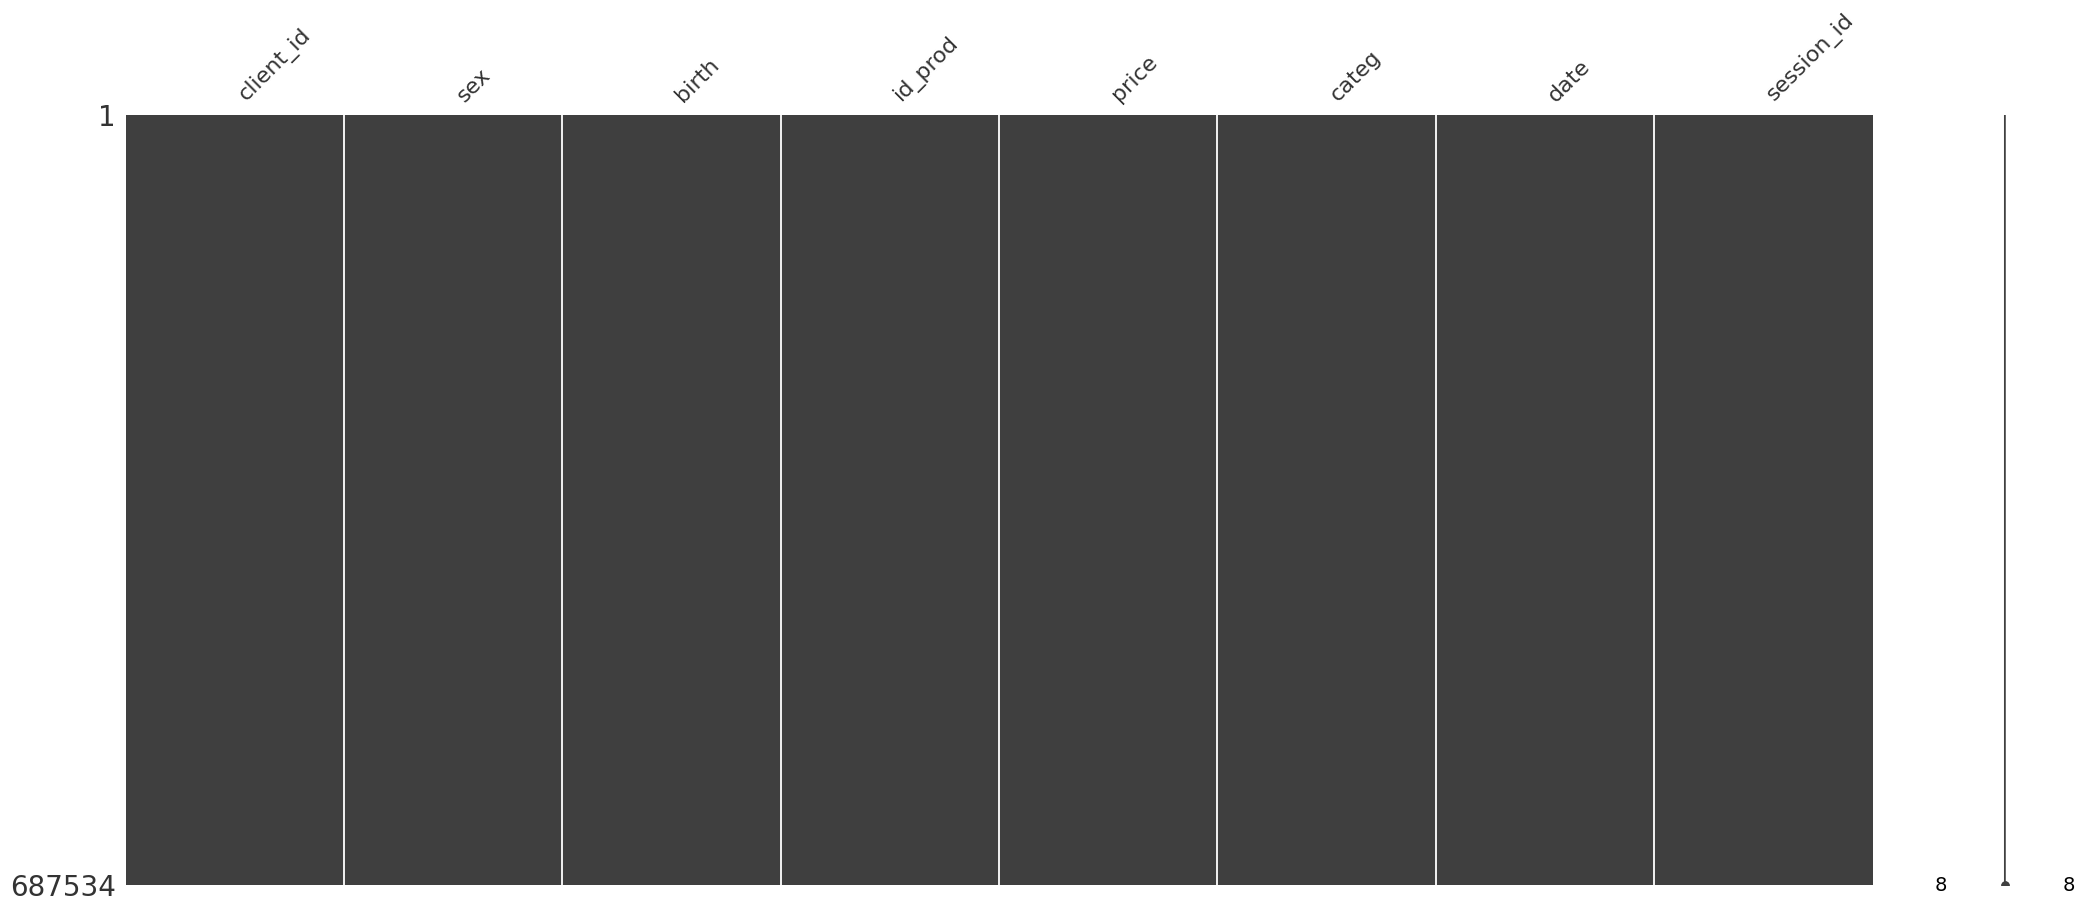

In [42]:
# Visualiser les données manquantes
msno.matrix(df_ventes)

c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\cluster\hierarchy.py:2820: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([dvw, 0])


<Axes: >

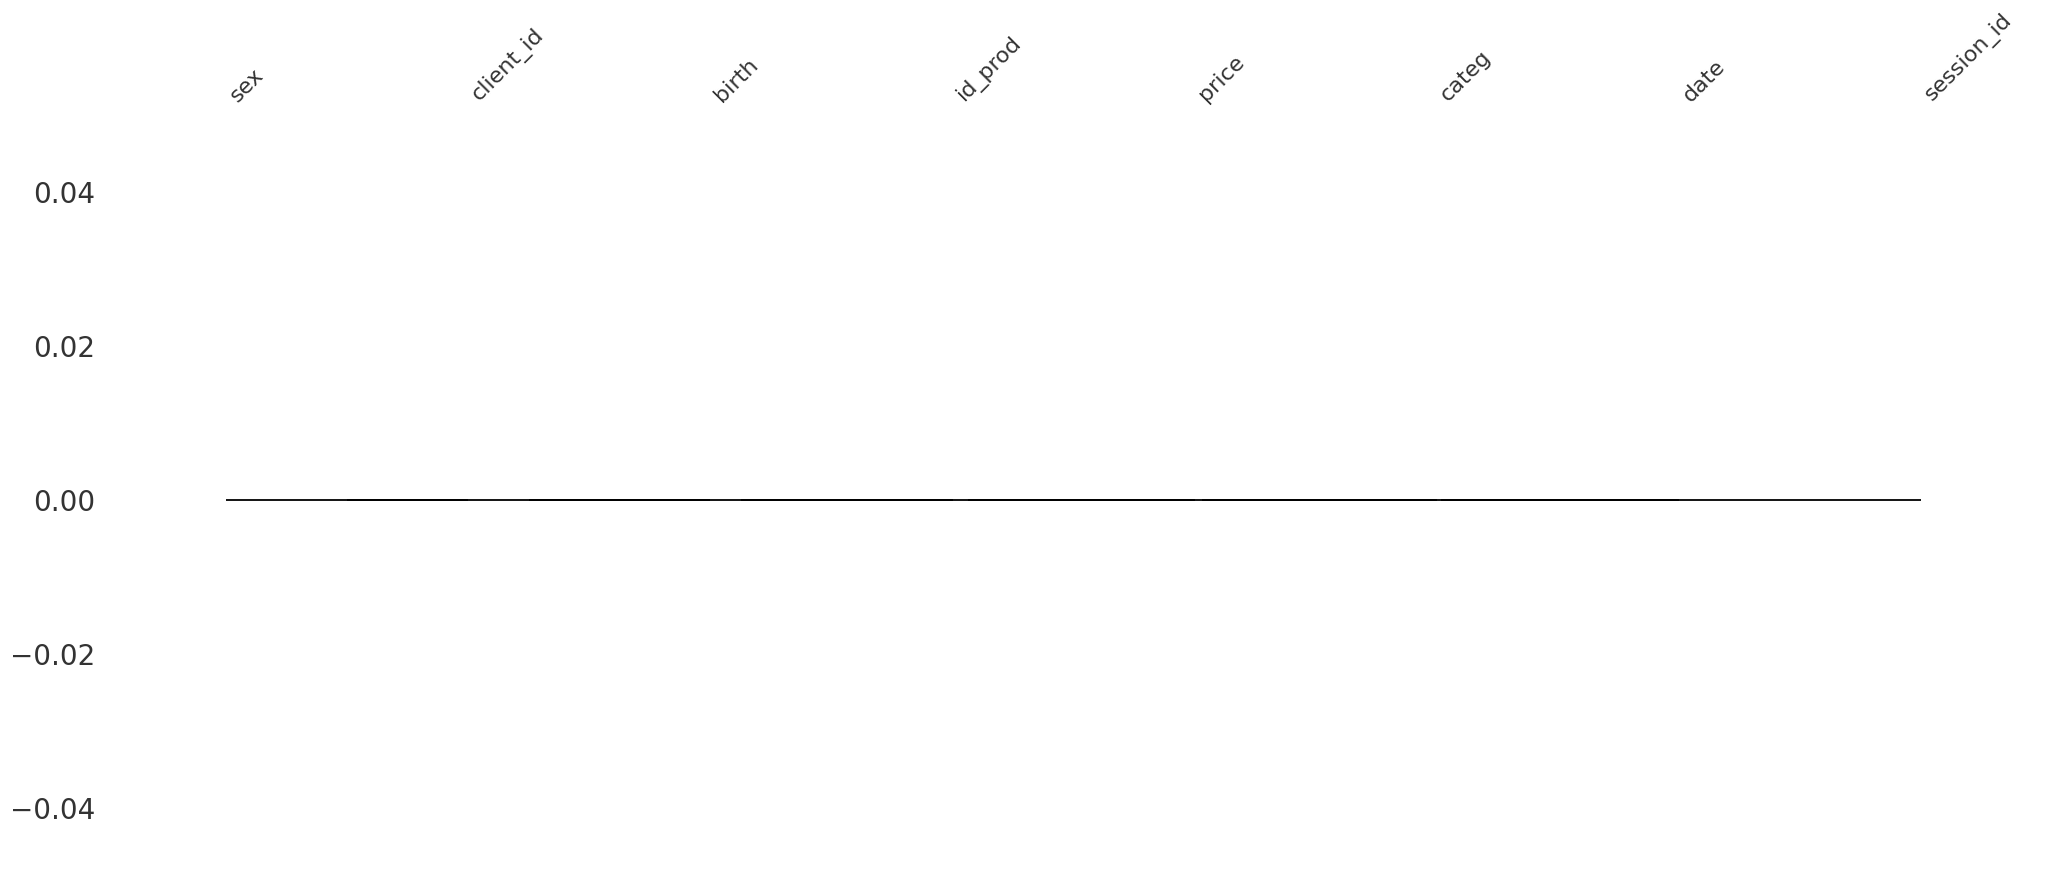

In [43]:
# Visualiser les données manquantes
msno.dendrogram(df_ventes)

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Créer de nouvelles variables</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Créer la variable age client</h3>
</div>

In [44]:
from datetime import datetime

# Obtenir l'année actuelle
annee_en_cours = datetime.today().year

# Afficher l'année actuelle
print(annee_en_cours)

2024


In [45]:
# Extraire la date au format date avec un type date
df_ventes['date_achat'] = pd.to_datetime(df_ventes['date'].dt.date)


In [46]:
description_variables(df_ventes)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 9 colonne(s)


type   total       n  unique  NaN  pourcentage_(NaN)
client_id           object  687534  687534    8600    0                0.0
sex               category  687534  687534       2    0                0.0
birth       datetime64[ns]  687534  687534      76    0                0.0
id_prod             object  687534  687534    3265    0                0.0
price              float64  687534  687534    1442    0                0.0
categ             category  687534  687534       3    0                0.0
date        datetime64[ns]  687534  687534  687415    0                0.0
session_id          object  687534  687534  345505    0                0.0
date_achat  datetime64[ns]  687534  687534     730    0                0.0

In [47]:
# Extraire l'année de session_id et créer la colone annee_achat
df_ventes['annee_achat'] = df_ventes['date'].dt.year

In [48]:
# Créer une colonne 'mois_achat' qui contient l'année et le mois (au format YYYY-MM)
df_ventes['mois_achat'] = df_ventes['date_achat'].dt.to_period('M')

In [49]:
# Extraire l'année de session_id et créer la colone annee_naissance
df_ventes['annee_naissance'] = df_ventes['birth'].dt.year

In [50]:
df_ventes.head()

client_id sex      birth id_prod  price categ                       date  \
0       c_1   m 1955-01-01  0_1090  13.78     0 2021-12-19 02:44:12.827475   
1       c_1   m 1955-01-01  0_1186  12.30     0 2021-07-25 12:17:34.446678   
2       c_1   m 1955-01-01  0_1186  12.30     0 2022-08-25 12:17:34.446678   
3       c_1   m 1955-01-01  0_1378  13.96     0 2021-08-23 16:56:15.401655   
4       c_1   m 1955-01-01  0_1378  13.96     0 2022-07-23 16:56:15.401655   

  session_id date_achat  annee_achat mois_achat  annee_naissance  
0   s_136532 2021-12-19         2021    2021-12             1955  
1    s_66947 2021-07-25         2021    2021-07             1955  
2   s_258252 2022-08-25         2022    2022-08             1955  
3    s_79696 2021-08-23         2021    2021-08             1955  
4   s_242617 2022-07-23         2022    2022-07             1955

In [51]:
# Création de la colonne age client (au moment de l'achat)
df_ventes['age_client'] = df_ventes['annee_achat'] - df_ventes['annee_naissance']
df_ventes.head()

client_id sex      birth id_prod  price categ                       date  \
0       c_1   m 1955-01-01  0_1090  13.78     0 2021-12-19 02:44:12.827475   
1       c_1   m 1955-01-01  0_1186  12.30     0 2021-07-25 12:17:34.446678   
2       c_1   m 1955-01-01  0_1186  12.30     0 2022-08-25 12:17:34.446678   
3       c_1   m 1955-01-01  0_1378  13.96     0 2021-08-23 16:56:15.401655   
4       c_1   m 1955-01-01  0_1378  13.96     0 2022-07-23 16:56:15.401655   

  session_id date_achat  annee_achat mois_achat  annee_naissance  age_client  
0   s_136532 2021-12-19         2021    2021-12             1955          66  
1    s_66947 2021-07-25         2021    2021-07             1955          66  
2   s_258252 2022-08-25         2022    2022-08             1955          67  
3    s_79696 2021-08-23         2021    2021-08             1955          66  
4   s_242617 2022-07-23         2022    2022-07             1955          67

In [52]:
statistiques_descriptives(df_ventes)

Statistiques descriptives:


n  unique      min     max          moy  mediane  \
price            687534    1442     0.62   300.0    17.493918    13.99   
annee_achat      687534       3  2021.00  2023.0  2021.662289  2022.00   
annee_naissance  687534      76  1929.00  2004.0  1977.817391  1980.00   
age_client       687534      78    17.00    94.0    43.844898    42.00   

                      q1    iqr       q3        std         var      skew  \
price               8.99  10.09    19.08  18.238337  332.636939  5.400139   
annee_achat      2021.00   1.00  2022.00   0.618184    0.382151  0.372395   
annee_naissance  1970.00  17.00  1987.00  13.607935  185.175908 -0.564249   
age_client         35.00  16.00    51.00  13.623882  185.610160  0.563901   

                      kurt  
price            43.374211  
annee_achat      -0.668233  
annee_naissance   0.403406  
age_client        0.401511

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.2 - Créer la variable tranche_age</h3>
</div>

In [53]:
# Créer des tranches d'âge
bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 99]  # Intervalles pour les tranches d'âge
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80p']  # Noms des tranches

# Ajouter une colonne 'tranche_age' en utilisant pd.cut()
df_ventes['tranche_age'] = pd.cut(df_ventes['age_client'], bins=bins, labels=labels, right=True)
df_ventes.head()

client_id sex      birth id_prod  price categ                       date  \
0       c_1   m 1955-01-01  0_1090  13.78     0 2021-12-19 02:44:12.827475   
1       c_1   m 1955-01-01  0_1186  12.30     0 2021-07-25 12:17:34.446678   
2       c_1   m 1955-01-01  0_1186  12.30     0 2022-08-25 12:17:34.446678   
3       c_1   m 1955-01-01  0_1378  13.96     0 2021-08-23 16:56:15.401655   
4       c_1   m 1955-01-01  0_1378  13.96     0 2022-07-23 16:56:15.401655   

  session_id date_achat  annee_achat mois_achat  annee_naissance  age_client  \
0   s_136532 2021-12-19         2021    2021-12             1955          66   
1    s_66947 2021-07-25         2021    2021-07             1955          66   
2   s_258252 2022-08-25         2022    2022-08             1955          67   
3    s_79696 2021-08-23         2021    2021-08             1955          66   
4   s_242617 2022-07-23         2022    2022-07             1955          67   

  tranche_age  
0       60-69  
1       60-69  
2       60-69  
3       60-69  
4       60-69

In [54]:
description_variables(df_ventes)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 14 colonne(s)


type   total       n  unique  NaN  \
client_id                object  687534  687534    8600    0   
sex                    category  687534  687534       2    0   
birth            datetime64[ns]  687534  687534      76    0   
id_prod                  object  687534  687534    3265    0   
price                   float64  687534  687534    1442    0   
categ                  category  687534  687534       3    0   
date             datetime64[ns]  687534  687534  687415    0   
session_id               object  687534  687534  345505    0   
date_achat       datetime64[ns]  687534  687534     730    0   
annee_achat               int32  687534  687534       3    0   
mois_achat            period[M]  687534  687534      24    0   
annee_naissance           int32  687534  687534      76    0   
age_client                int32  687534  687534      78    0   
tranche_age            category  687534  687534       8    0   

                 pourcentage_(NaN)  
client_id                      0.0  
sex                            0.0  
birth                          0.0  
id_prod                        0.0  
price                          0.0  
categ                          0.0  
date                           0.0  
session_id                     0.0  
date_achat                     0.0  
annee_achat                    0.0  
mois_achat                     0.0  
annee_naissance                0.0  
age_client                     0.0  
tranche_age                    0.0

In [55]:
# Recoder la variable annee_naissance au format datetime
df_ventes['annee_naissance'] = pd.to_datetime(df_ventes['annee_naissance'])

In [56]:
description_variables(df_ventes)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 14 colonne(s)


type   total       n  unique  NaN  \
client_id                object  687534  687534    8600    0   
sex                    category  687534  687534       2    0   
birth            datetime64[ns]  687534  687534      76    0   
id_prod                  object  687534  687534    3265    0   
price                   float64  687534  687534    1442    0   
categ                  category  687534  687534       3    0   
date             datetime64[ns]  687534  687534  687415    0   
session_id               object  687534  687534  345505    0   
date_achat       datetime64[ns]  687534  687534     730    0   
annee_achat               int32  687534  687534       3    0   
mois_achat            period[M]  687534  687534      24    0   
annee_naissance  datetime64[ns]  687534  687534      76    0   
age_client                int32  687534  687534      78    0   
tranche_age            category  687534  687534       8    0   

                 pourcentage_(NaN)  
client_id                      0.0  
sex                            0.0  
birth                          0.0  
id_prod                        0.0  
price                          0.0  
categ                          0.0  
date                           0.0  
session_id                     0.0  
date_achat                     0.0  
annee_achat                    0.0  
mois_achat                     0.0  
annee_naissance                0.0  
age_client                     0.0  
tranche_age                    0.0

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Analyse du chiffre d'affaires</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.1 - Analyse univariée</h3>
</div>

In [57]:
# Statistiques descriptives des variables numeriques
statistiques_descriptives(df_ventes)

Statistiques descriptives:


n  unique      min     max          moy  mediane       q1  \
price        687534    1442     0.62   300.0    17.493918    13.99     8.99   
annee_achat  687534       3  2021.00  2023.0  2021.662289  2022.00  2021.00   
age_client   687534      78    17.00    94.0    43.844898    42.00    35.00   

               iqr       q3        std         var      skew       kurt  
price        10.09    19.08  18.238337  332.636939  5.400139  43.374211  
annee_achat   1.00  2022.00   0.618184    0.382151  0.372395  -0.668233  
age_client   16.00    51.00  13.623882  185.610160  0.563901   0.401511

In [58]:
df_graph = df_ventes.loc[:, ['price', 'age_client']]

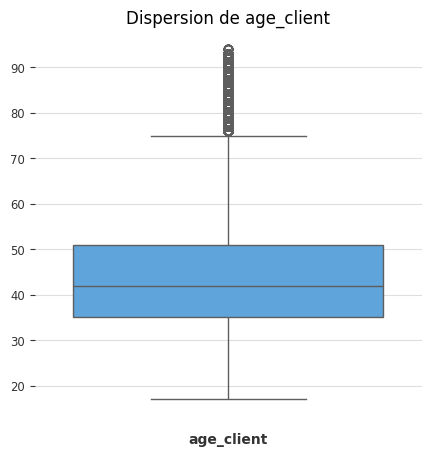

In [59]:
# Réaliser une boucle à travers chaque colonne du dataframe df_graph
for column in df_graph.columns:
    plt.figure(figsize=(5, 5))  # Taille du graphique

    # Créer un boxplot pour chaque colonne avec la couleur spécifiée
    sns.boxplot(y=df_graph[column], color='#4BA6EE')

    # Ajouter un titre
    plt.title(f'Dispersion de {column}')

    # Ajouter les labels
    plt.xlabel(column)
    plt.ylabel('')  # Pas de label pour l'axe Y

    # Afficher le graphique
    plt.show()

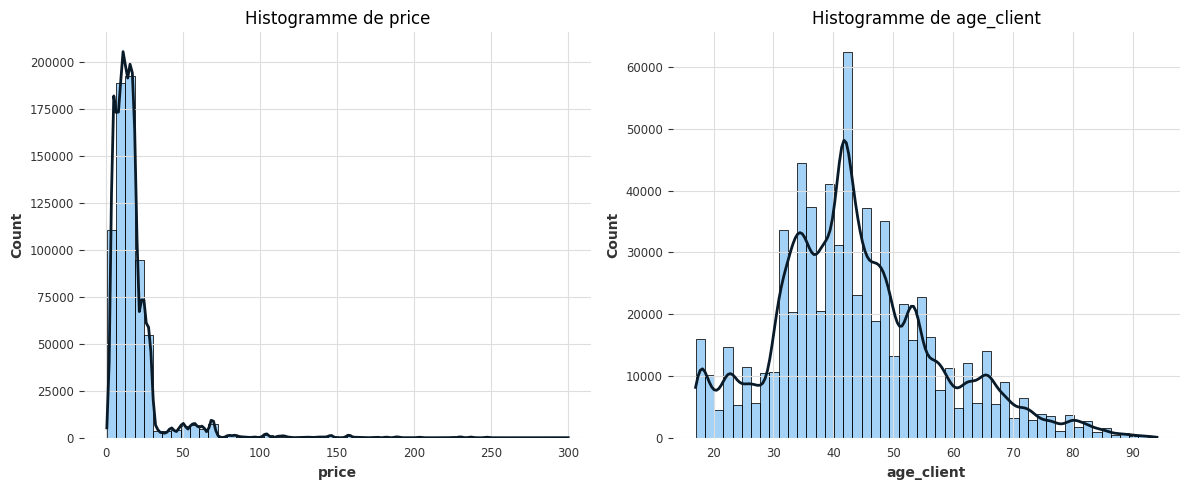

In [60]:
# Définir la taille et la grille des sous-graphiques (2 colonnes)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boucler sur chaque colonne du DataFrame et ajouter les histogrammes avec courbes de densité
for i, column in enumerate(df_graph.columns):
    # Créer un histogramme avec la couleur spécifiée
    sns.histplot(df_graph[column], bins=50, kde=True, ax=axes[i], color='#4BA6EE')

    # Modifier la couleur de la courbe de densité après sa création
    kde = axes[i].lines[0]
    kde.set_color('#091A29')
    kde.set_linewidth(2)

    # Ajouter un titre à chaque histogramme
    axes[i].set_title(f'Histogramme de {column}')

# Ajuster l'espace entre les sous-graphiques
plt.tight_layout()

# Afficher les sous-graphiques
plt.show()


In [61]:
# Statistiques des variables catégorielles
categorielles_statistiques(df_ventes)

nobs  missing  distinct       top    freq
client_id    687534        0      8600    c_1609   25586
sex          687534        0         2         m  344841
id_prod      687534        0      3265     1_369    2340
categ        687534        0         3         0  415459
session_id   687534        0    345505  s_118668      14
tranche_age  687534        0         8     40-49  228044

In [62]:
freq_table_sex = frequency_table(df_ventes, 'sex')

In [63]:
freq_table_sex.to_excel('freq_table_sexe.xlsx')

In [64]:
freq_table_categ = frequency_table(df_ventes, 'categ')

In [65]:
freq_table_categ.to_excel('freq_table_categ.xlsx')

In [66]:
freq_table_tranche_age = frequency_table(df_ventes, 'tranche_age')

In [67]:
freq_table_tranche_age.to_excel('freq_table_tranche_age.xlsx')

In [68]:
frequency_table(df_ventes, 'id_prod')

id_prod  Frequency  Percentage  Cumulative Frequency  \
0      1_369       2340    0.340347                  2340   
1      1_417       2269    0.330020                  4609   
2      1_414       2246    0.326675                  6855   
3      1_498       2202    0.320275                  9057   
4      1_425       2163    0.314603                 11220   
...      ...        ...         ...                   ...   
3260    2_98          1    0.000145                687530   
3261  0_2201          1    0.000145                687531   
3262  0_1683          1    0.000145                687532   
3263    2_23          1    0.000145                687533   
3264  0_1539          1    0.000145                687534   

      Cumulative Percentage  
0                  0.340347  
1                  0.670367  
2                  0.997042  
3                  1.317317  
4                  1.631919  
...                     ...  
3260              99.999418  
3261              99.999564  
3262              99.999709  
3263              99.999855  
3264             100.000000  

[3265 rows x 5 columns]

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.2 - Identifier les outliers</h3>
</div>

Identifier les outliers des variables quantitatives

In [69]:
# Identification à partir de l'interval inter quartile (IQR) - variable price
price_iqr_outliers = iqr_outliers(df_products, 'price')

Nombre d'outliers : 302
Pourcentage d'outliers : 9.19%
Borne inférieure : -17.01
Borne supérieure : 46.99

Liste des outliers :
     id_prod   price categ
10     2_228  225.17     2
11     1_178   51.92     1
38     2_100   72.11     2
49      1_48   47.22     1
64      2_89  107.99     2
...      ...     ...   ...
3266   2_101   63.99     2
3268   1_543   51.99     1
3270   2_123  147.99     2
3278   1_331   55.99     1
3281    2_23  115.99     2

[302 rows x 3 columns]


In [70]:
# Afficher les 5 premières valeurs
price_iqr_outliers.head()

id_prod   price categ
10   2_228  225.17     2
11   1_178   51.92     1
38   2_100   72.11     2
49    1_48   47.22     1
64    2_89  107.99     2

In [71]:
# Identification à partir du zscore - variable price
price_zscore = zscore(df_products, 'id_prod','price', as_dataframe=True)
price_zscore

id_prod   price  price_zscore
0     0_1421   19.99     -0.062768
1     0_1368    5.13     -0.560594
2      0_731   17.99     -0.129770
3      1_587    4.99     -0.565284
4     0_1507    3.99     -0.598785
...      ...     ...           ...
3281    2_23  115.99      3.153336
3282   0_146   17.14     -0.158246
3283   0_802   11.22     -0.356572
3284   1_140   38.56      0.559347
3285  0_1920   25.16      0.110433

[3286 rows x 3 columns]

In [72]:
# Filtrer les valeurs dont le Z-score est supérieur à 3
price_zscore.loc[price_zscore['price_zscore'] > 3].info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 10 to 3281
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_prod       97 non-null     object 
 1   price         97 non-null     float64
 2   price_zscore  97 non-null     float64
dtypes: float64(2), object(1)
memory usage: 3.0+ KB


In [73]:
# Identification à partir de l'interval inter quartile (IQR) - variable age_client en nombre de transactions
age_client_iqr_outliers = iqr_outliers(df_ventes, 'age_client')

Nombre d'outliers : 17304
Pourcentage d'outliers : 2.52%
Borne inférieure : 11.00
Borne supérieure : 75.00

Liste des outliers :
       client_id sex      birth id_prod  price categ  \
549       c_1005   f 1941-01-01  0_1052   3.79     0   
550       c_1005   f 1941-01-01  0_1277   7.99     0   
551       c_1005   f 1941-01-01  0_1465   3.99     0   
552       c_1005   f 1941-01-01  0_1465   3.99     0   
553       c_1005   f 1941-01-01  0_1465   3.99     0   
...          ...  ..        ...     ...    ...   ...   
685917     c_978   f 1940-01-01   1_630  10.75     1   
685918     c_978   f 1940-01-01   1_639  10.99     1   
685919     c_978   f 1940-01-01   1_639  10.99     1   
685920     c_978   f 1940-01-01   1_640  11.90     1   
685921     c_978   f 1940-01-01   1_640  11.90     1   

                             date session_id date_achat  annee_achat  \
549    2021-09-09 03:58:18.471061    s_87125 2021-09-09         2021   
550    2021-03-07 01:29:23.941625     s_2821 2021-03-0

In [74]:
# Affichage sous forme d'un dataframe
age_client_iqr_outliers.head()

client_id sex      birth id_prod  price categ                       date  \
549    c_1005   f 1941-01-01  0_1052   3.79     0 2021-09-09 03:58:18.471061   
550    c_1005   f 1941-01-01  0_1277   7.99     0 2021-03-07 01:29:23.941625   
551    c_1005   f 1941-01-01  0_1465   3.99     0 2021-05-09 20:07:07.743524   
552    c_1005   f 1941-01-01  0_1465   3.99     0 2022-05-09 20:07:07.743524   
553    c_1005   f 1941-01-01  0_1465   3.99     0 2022-07-09 20:07:07.743524   

    session_id date_achat  annee_achat mois_achat  \
549    s_87125 2021-09-09         2021    2021-09   
550     s_2821 2021-03-07         2021    2021-03   
551    s_32262 2021-05-09         2021    2021-05   
552   s_206088 2022-05-09         2022    2022-05   
553   s_236023 2022-07-09         2022    2022-07   

                  annee_naissance  age_client tranche_age  
549 1970-01-01 00:00:00.000001941          80         80p  
550 1970-01-01 00:00:00.000001941          80         80p  
551 1970-01-01 00:00:00.000001941          80         80p  
552 1970-01-01 00:00:00.000001941          81         80p  
553 1970-01-01 00:00:00.000001941          81         80p

In [75]:
list_colonne = ['client_id', 'age_client']
list_colonne

['client_id', 'age_client']

In [76]:
# Nombre d'outliers en nombre de clients uniques (360)
age_client_iqr_outliers[list_colonne].drop_duplicates()

client_id  age_client
549       c_1005          80
552       c_1005          81
554       c_1005          82
907       c_1007          80
908       c_1007          82
...          ...         ...
684360     c_955          88
684754     c_960          76
685850     c_978          81
685852     c_978          83
685853     c_978          82

[947 rows x 2 columns]

In [77]:
# Nombre d'outliers en nombre de clients uniques (360)
age_client_iqr_outliers[['client_id']].drop_duplicates()

client_id
549       c_1005
907       c_1007
5264      c_1063
7104      c_1082
11456     c_1136
...          ...
683170     c_936
684098     c_949
684338     c_955
684754     c_960
685850     c_978

[360 rows x 1 columns]

In [78]:
# Identification à partir du zscore - variable age client
age_client_zscore = zscore(df_ventes, 'client_id','age_client', as_dataframe=True)
age_client_zscore

client_id  age_client  age_client_zscore
0            c_1          66           1.626196
1            c_1          66           1.626196
2            c_1          67           1.699597
3            c_1          66           1.626196
4            c_1          67           1.699597
...          ...         ...                ...
687550     c_999          58           1.038992
687551     c_999          57           0.965591
687552     c_999          58           1.038992
687553     c_999          58           1.038992
687554     c_999          59           1.112392

[687534 rows x 3 columns]

In [79]:
# Filtrer les valeurs dont le Z-score est supérieur à 3
age_client_zscore.loc[age_client_zscore['age_client_zscore'] > 3].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3526 entries, 11456 to 684363
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          3526 non-null   object 
 1   age_client         3526 non-null   int32  
 2   age_client_zscore  3526 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 96.4+ KB


In [80]:
# Filtrer les valeurs dont le Z-score est supérieur à 3 pour les clients uniques
age_client_zscore.loc[age_client_zscore['age_client_zscore'] > 3].client_id.nunique()

88

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.3 - Evolution du chiffre d'affaires</h3>
</div>

Extraire la série temporelle journalière du chiffre d'affaires (toutes catégories).

In [81]:
# Série temporelle des ventes journalières
series_journaliere = df_ventes[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='D')]).sum()

# S'assurer que l'index est de type datetime
series_journaliere.index = pd.to_datetime(series_journaliere.index)

# Convertir en TimeSeries Darts
series_journaliere_ts = TimeSeries.from_dataframe(series_journaliere, value_cols='price')

Afficher l'évolution du chiffre d'affaires quotidien.

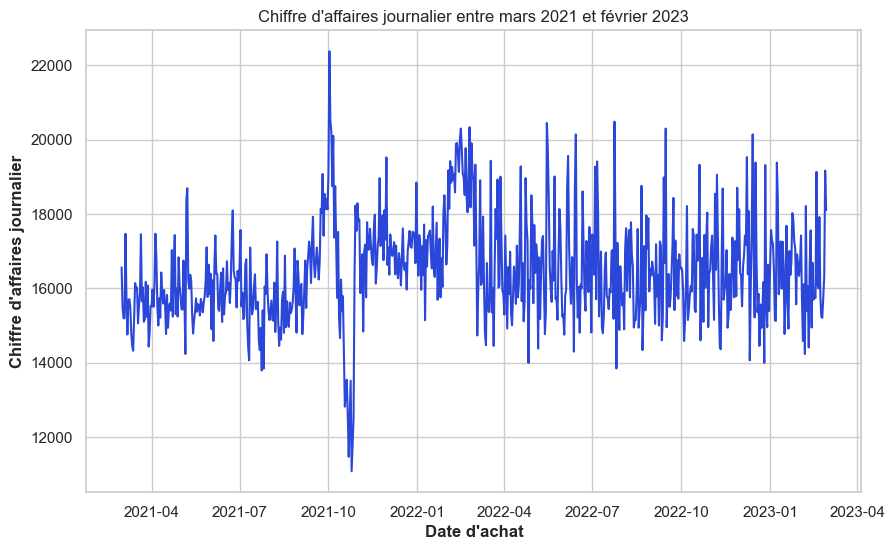

In [82]:
# Créer le graphique en ligne
# Définir le thème
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))  # Définir la taille du graphique
sns.lineplot(data=series_journaliere, x="date_achat", y="price", color='#2B47D9')

# Ajouter un titre et des labels
plt.title("Chiffre d'affaires journalier entre mars 2021 et février 2023")
plt.xlabel("Date d'achat")
plt.ylabel("Chiffre d'affaires journalier")
plt.grid(True)

# Afficher le graphique
plt.show()

Extraire la série temporelle hebdomadaire du chiffre d'affaires (toutes catégories)

In [83]:
# Série temporelle des ventes hebdomadaires
series_hebdo = df_ventes[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='W')]).sum()

# S'assurer que l'index est de type datetime
series_hebdo.index = pd.to_datetime(series_hebdo.index)

# Convertir en TimeSeries Darts
series_hebdo_ts = TimeSeries.from_dataframe(series_hebdo, value_cols='price')


Extraire la série temporelle mensuelle du chiffre d'affaires (toutes catégories)

In [84]:
# Déterminer une série temporelle mensuelle
series_mensuelle = df_ventes[['date_achat', 'price']].groupby(pd.Grouper(key='date_achat', freq='ME')).sum()

# S'assurer que l'index est de type datetime
series_mensuelle.index = pd.to_datetime(series_mensuelle.index)

# Convertir en TimeSeries Darts
series_mensuelle_ts = TimeSeries.from_dataframe(series_mensuelle, value_cols='price')

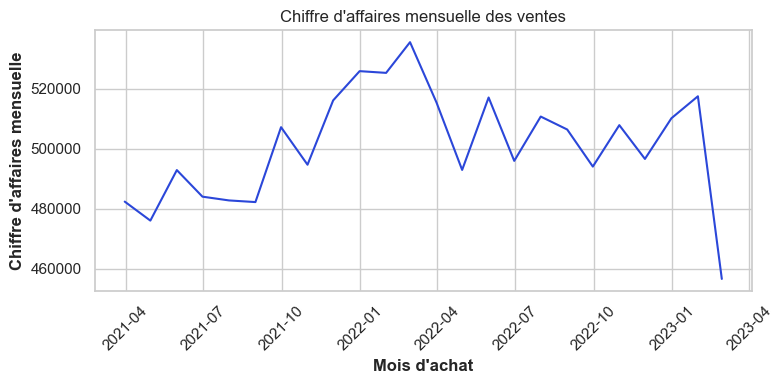

In [85]:
# Créer le graphique en ligne pour le chiffre d'affaires hebdomadaire
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))  # Définir la taille du graphique
sns.lineplot(data=series_mensuelle, x="date_achat", y="price", color='#2B47D9')

# Ajouter un titre et des labels
plt.title("Chiffre d'affaires mensuelle des ventes")
plt.xlabel("Mois d'achat")
plt.ylabel("Chiffre d'affaires mensuelle")

# Ajouter des rotations aux étiquettes de l'axe X si nécessaire
plt.xticks(rotation=45)
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()

In [86]:
series_mensuelle.to_excel('series_mensuelle.xlsx')

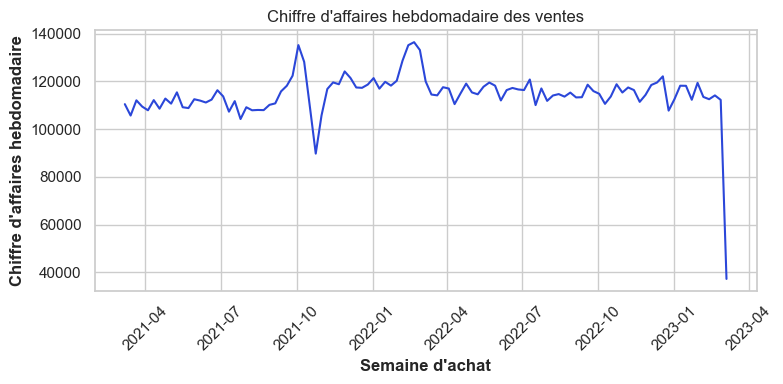

In [87]:
# Créer le graphique en ligne pour le chiffre d'affaires hebdomadaire
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))  # Définir la taille du graphique
sns.lineplot(data=series_hebdo, x="date_achat", y="price", color='#2B47D9')

# Ajouter un titre et des labels
plt.title("Chiffre d'affaires hebdomadaire des ventes")
plt.xlabel("Semaine d'achat")
plt.ylabel("Chiffre d'affaires hebdomadaire")

# Ajouter des rotations aux étiquettes de l'axe X si nécessaire
plt.xticks(rotation=45)
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()

In [88]:
# Séries temporelles des ventes mensuelles par catégories
categ_series_m = df_ventes[['date_achat', 'price', 'categ']].groupby([pd.Grouper(key='date_achat', freq='ME'), 'categ'], observed=True).sum()
categ_series_m

price
date_achat categ           
2021-03-31 0      193629.17
           1      186974.17
           2      101837.27
2021-04-30 0      205222.46
           1      156138.35
...                     ...
2023-01-31 1      210104.41
           2      126153.08
2023-02-28 0      162457.00
           1      180347.24
           2      113875.52

[72 rows x 1 columns]

In [89]:
# Exporter les données au format xlsx
categ_series_m.to_excel('categ_series_m.xlsx')

In [90]:
# Séries temporelles des ventes hebdomadaires par catégories
categ_series_w = df_ventes[['date_achat', 'price', 'categ']].groupby([pd.Grouper(key='date_achat', freq='W'), 'categ'], observed=True).sum()
categ_series_w

price
date_achat categ          
2021-03-07 0      43832.65
           1      42774.98
           2      23855.65
2021-03-14 0      44167.01
           1      40491.84
...                    ...
2023-02-26 1      46376.82
           2      24697.00
2023-03-05 0      12339.29
           1      15688.01
           2       9248.66

[315 rows x 1 columns]

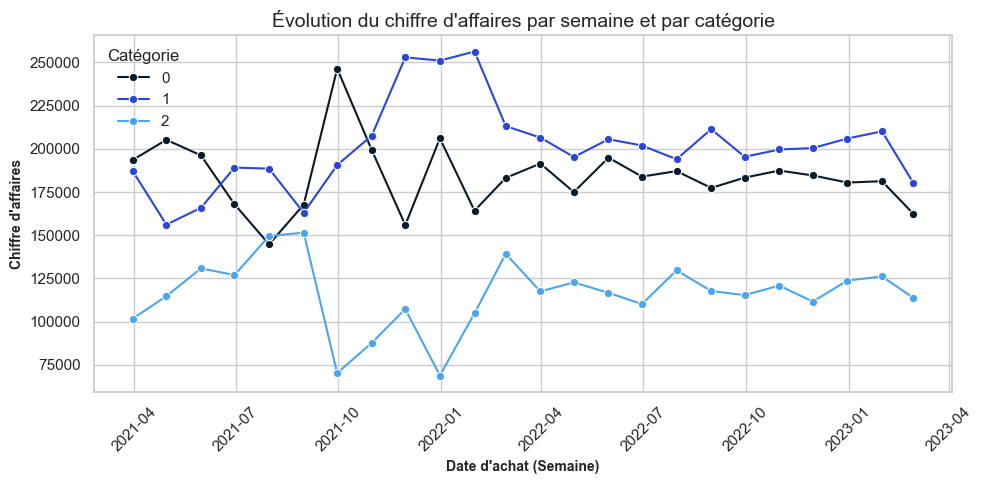

In [91]:
# Initialiser la figure
plt.figure(figsize=(10, 5))

# Déterminer une palette de couleurs
custom_palette = (["#091A29", "#2B47D9", "#4BA6EE"])
sns.set_theme(style="whitegrid", palette=custom_palette)

# Créer un lineplot pour chaque catégorie
sns.lineplot(data=categ_series_m, x='date_achat', y='price', hue='categ', marker='o')

# Ajouter un titre et des labels
plt.title('Évolution du chiffre d\'affaires par semaine et par catégorie', fontsize=14)
plt.xlabel('Date d\'achat (Semaine)', fontsize=10)
plt.ylabel('Chiffre d\'affaires', fontsize=10)

# Rotation des labels de l'axe x pour plus de lisibilité
plt.xticks(rotation=45)

# Afficher la légende
plt.legend(title='Catégorie', loc='upper left')

# Afficher le graphique
plt.tight_layout()
plt.show()

Identifier la saisonnalité

Il ya une saisonnalité d'ordre 5.
Il ya une saisonnalité d'ordre 20.


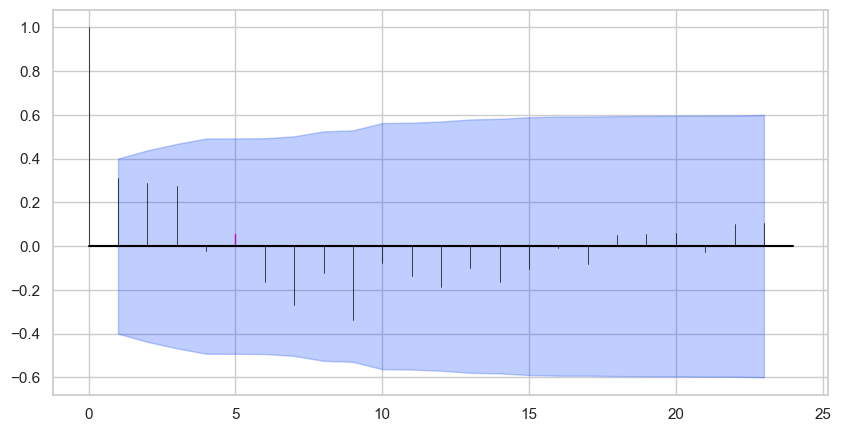

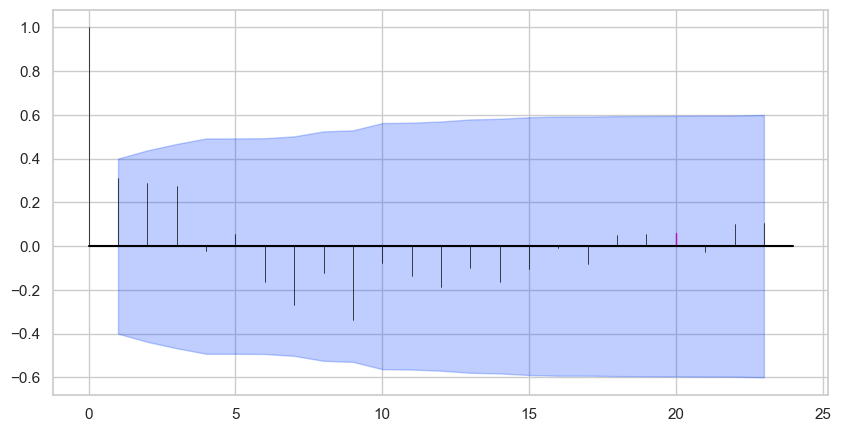

In [92]:
# Vérifier la saisonnalité pour des périodicités allant de 2 à 23 semaines avec Darts
for m in range(2, 23):
    is_seasonal, period = check_seasonality(series_mensuelle_ts, m=m, alpha=0.05)
    if is_seasonal:
        print(f"Il ya une saisonnalité d'ordre {period}.")
        
        # Ajustement dynamique du max_lag pour éviter l'erreur
        max_lag = max(23, period)  # On s'assure que max_lag est au moins égal à la saisonnalité détectée
        plot_acf(series_mensuelle_ts, m=period, alpha=0.05, max_lag=max_lag)

Respecter le principe de conservation des aires

In [93]:
# Calcul de la moyenne, de l'écart-type et du coefficient de variation
sum_price = series_mensuelle['price'].sum()
mean_price = series_mensuelle['price'].mean()
std_price = series_mensuelle['price'].std()
cv_price = (std_price / mean_price)

# Préparer les données pour le tableau
table = [
    ['Somme', sum_price],
    ['Moyenne', mean_price],
    ['Écart-type', std_price],
    ['Coefficient de variation (CV)', f"{cv_price:.2f}%"]
]

# Afficher les résultats dans un tableau avec tabulate
print(tabulate(table, headers=['Mesure', 'Valeur'], tablefmt='github'))


| Mesure                        | Valeur             |
|-------------------------------|--------------------|
| Somme                         | 12027663.100000001 |
| Moyenne                       | 501152.6291666667  |
| Écart-type                    | 18453.13633236954  |
| Coefficient de variation (CV) | 0.04%              |


In [94]:
# Décomposer la série pour obtenir les coefficients saisonniers de la série mensuelle
decomposition = sm.tsa.seasonal_decompose(series_mensuelle['price'], model='additive', period=12)

# Extraire les coefficients saisonniers
seasonal_coefficients = decomposition.seasonal

# Calculer la somme des coefficients saisonniers
sum_seasonal = seasonal_coefficients.sum()

# Calculer la moyenne des coefficients pour l'ajustement
mean_seasonal = sum_seasonal / len(seasonal_coefficients)

# Ajuster les coefficients saisonniers pour que leur somme soit égale à zéro
seasonal_adjusted = seasonal_coefficients - mean_seasonal

# Extraire et créer une nouvelle colonne série CVS ajustée
series_mensuelle['CVS_adjusted'] = series_mensuelle['price'] - seasonal_adjusted

# Vérifier que la somme est maintenant proche de zéro
print(f"Somme des coefficients ajustés : {seasonal_adjusted.sum()}")

# Afficher les coefficients saisonniers ajustés
print("Coefficients saisonniers ajustés :")
print(seasonal_adjusted)

Somme des coefficients ajustés : -2.7284841053187847e-12
Coefficients saisonniers ajustés :
date_achat
2021-03-31       29.647708
2021-04-30   -22430.378125
2021-05-31     1966.539375
2021-06-30   -17683.250208
2021-07-31    -1937.241042
2021-08-31    -2641.000208
2021-09-30     1403.915625
2021-10-31   -13183.002708
2021-11-30     6539.951875
2021-12-31    14784.639792
2022-01-31    12544.879792
2022-02-28    20605.298125
2022-03-31       29.647708
2022-04-30   -22430.378125
2022-05-31     1966.539375
2022-06-30   -17683.250208
2022-07-31    -1937.241042
2022-08-31    -2641.000208
2022-09-30     1403.915625
2022-10-31   -13183.002708
2022-11-30     6539.951875
2022-12-31    14784.639792
2023-01-31    12544.879792
2023-02-28    20605.298125
Freq: ME, Name: seasonal, dtype: float64


In [95]:
# Coefficients saisonniers mensuels
coef_saisonniers = decomposition.seasonal
coef_saisonniers_sum = coef_saisonniers.sum()
coef_saisonniers_mean = coef_saisonniers.mean()

# Préparer les données pour le tableau
table = [
    ['Somme des coefficients', coef_saisonniers_sum],
    ['Moyenne des coefficients', coef_saisonniers_mean],
]

# Afficher les résultats dans un tableau avec tabulate
print(tabulate(table, headers=['Mesure', 'Valeur'], tablefmt='github'))

| Mesure                   |       Valeur |
|--------------------------|--------------|
| Somme des coefficients   | -2.72848e-12 |
| Moyenne des coefficients | -1.13687e-13 |


In [96]:
sum_price_cvs = series_mensuelle['CVS_adjusted'].sum()
mean_price_cvs = series_mensuelle['CVS_adjusted'].mean()
std_price_cvs = series_mensuelle['CVS_adjusted'].std()
cv_price_cvs = (std_price / mean_price)
seasonal_adjusted_sum = seasonal_adjusted.sum()

# Préparer les données pour le tableau
table = [
    ['Somme', sum_price_cvs],
    ['Moyenne', mean_price_cvs],
    ['Écart-type', std_price_cvs],
    ['Coefficients Ajustés', f"{seasonal_adjusted_sum:.1f}"],
    ['Coefficient de variation (CV)', f"{cv_price_cvs:.2f}%"]
]

# Afficher les résultats dans un tableau avec tabulate
print(tabulate(table, headers=['Mesure', 'Valeur'], tablefmt='github'))

| Mesure                        | Valeur             |
|-------------------------------|--------------------|
| Somme                         | 12027663.100000001 |
| Moyenne                       | 501152.6291666667  |
| Écart-type                    | 17926.163370679067 |
| Coefficients Ajustés          | -0.0               |
| Coefficient de variation (CV) | 0.04%              |


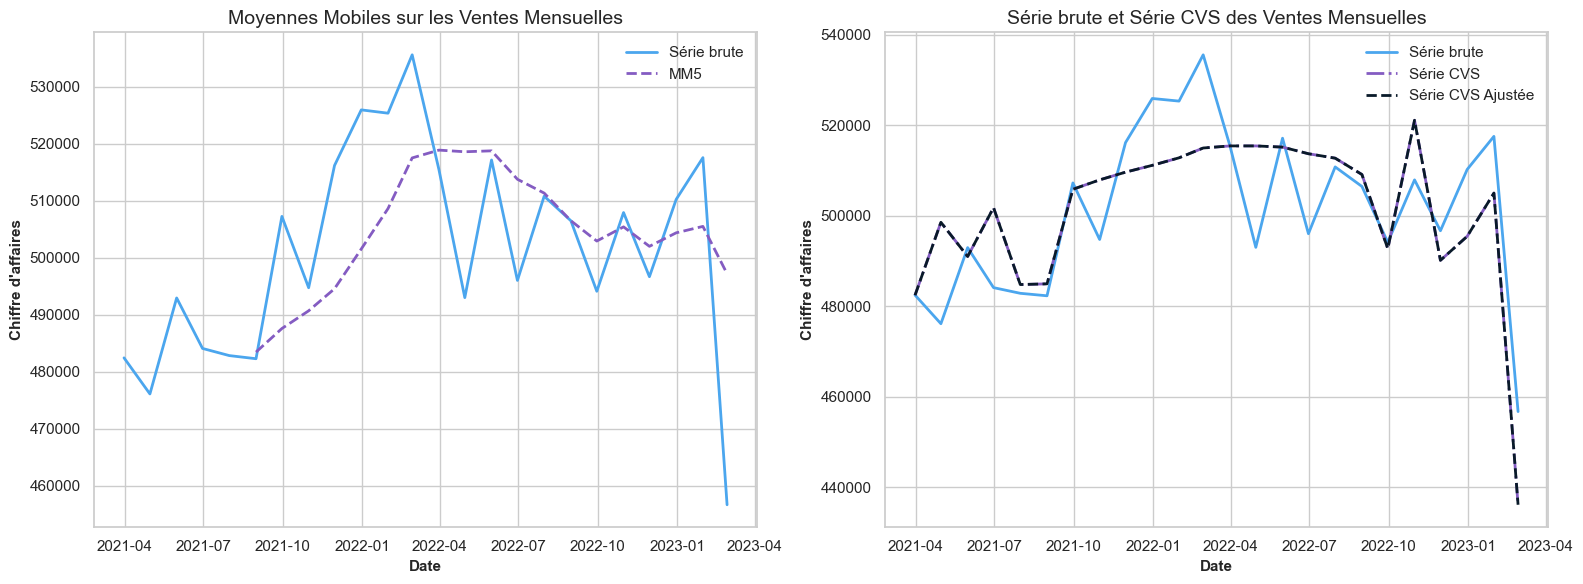

In [97]:
# Calcul des moyennes mobiles pour les périodes détectées
series_mensuelle['MM_5'] = series_mensuelle['price'].rolling(window=6).mean()

# Décomposer la série en tendance, saisonnalité, et résidus (additif ou multiplicatif selon le cas)
decomposition = sm.tsa.seasonal_decompose(series_mensuelle['price'], model='additive', period=12) 

# Calcul de la série CVS (Série corrigée des variations saisonnières)
series_mensuelle['CVS'] = series_mensuelle['price'] - decomposition.seasonal

# Création des subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes
grid = plt.GridSpec(1, 2, wspace=0.5)

# Graphique 1 : Moyennes mobiles
axes[0].plot(series_mensuelle.index, series_mensuelle['price'], label='Série brute', color='#4BA6EE', linewidth=2)
axes[0].plot(series_mensuelle.index, series_mensuelle['MM_5'], label='MM5', color='#845CC2', linestyle='--', linewidth=2)
axes[0].set_title('Moyennes Mobiles sur les Ventes Mensuelles', fontsize=14)
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Chiffre d\'affaires', fontsize=11)
axes[0].legend(loc='best')
axes[0].grid(True)

# Graphique 2 : Série brute et série CVS
axes[1].plot(series_mensuelle.index, series_mensuelle['price'], label='Série brute', color='#4BA6EE', linewidth=2)
axes[1].plot(series_mensuelle.index, series_mensuelle['CVS'], label='Série CVS', color='#845CC2', linewidth=2, linestyle='-.')
axes[1].plot(series_mensuelle.index,series_mensuelle['CVS_adjusted'], label='Série CVS Ajustée', color='#091A29', linewidth=2, linestyle='--')
axes[1].set_title('Série brute et Série CVS des Ventes Mensuelles', fontsize=14)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Chiffre d\'affaires', fontsize=11)
axes[1].legend(loc='best')
axes[1].grid(True)

# Ajustement des espaces
plt.tight_layout()

# Afficher le graphique
plt.show()

In [98]:
# Exporter les données au format xlsx
series_mensuelle.to_excel('serie_mensuelle.xlsx')

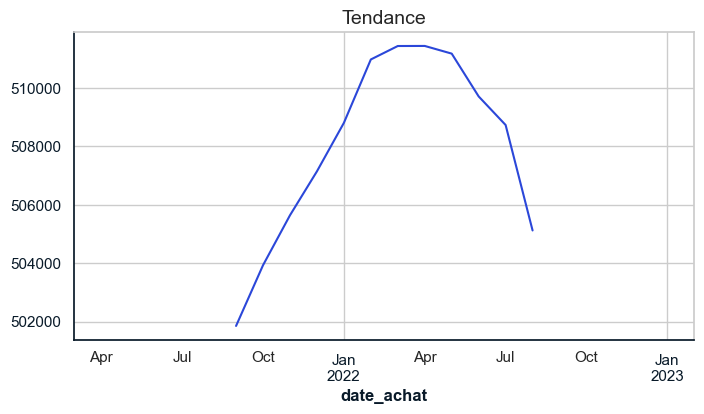

In [99]:
# Appliquer la décomposition saisonnière (modèle additif)
decomposition = sm.tsa.seasonal_decompose(series_mensuelle['price'], model='additive', period=12)

# Créer la figure et afficher la tendance
plt.figure(figsize=(8, 4))  # Définir la taille de la figure
sns.set_theme(style="whitegrid")
decomposition.trend.plot(color='#2B47D9')  # Définir la couleur de la tendance

# Obtenir les axes actuels et modifier la couleur des axes
ax = plt.gca()
ax.spines['bottom'].set_color('#091A29')
ax.spines['left'].set_color('#091A29')

# Personnaliser les étiquettes des axes avec la couleur souhaitée
ax.xaxis.label.set_color('#091A29')
ax.yaxis.label.set_color('#091A29')

# Personnaliser les graduations (ticks) des axes
ax.tick_params(axis='x', colors='#091A29')
ax.tick_params(axis='y', colors='#091A29')

# Ajouter un titre
plt.title('Tendance', fontsize=14)

# Afficher le graphique
plt.show()


In [100]:
# Afficher la tendance
tendance = decomposition.trend
tendance

date_achat
2021-03-31              NaN
2021-04-30              NaN
2021-05-31              NaN
2021-06-30              NaN
2021-07-31              NaN
2021-08-31              NaN
2021-09-30    501848.285833
2021-10-31    503927.684167
2021-11-30    505639.299583
2021-12-31    507144.161667
2022-01-31    508805.631667
2022-02-28    510977.723333
2022-03-31    511438.403750
2022-04-30    511440.839583
2022-05-31    511177.582083
2022-06-30    509710.891667
2022-07-31    508731.882500
2022-08-31    505119.791667
2022-09-30              NaN
2022-10-31              NaN
2022-11-30              NaN
2022-12-31              NaN
2023-01-31              NaN
2023-02-28              NaN
Freq: ME, Name: trend, dtype: float64

In [101]:
# Exporter les données au format xlsx
tendance.to_excel('trend.xlsx')

On observe un changement de tendance à partir de l'année 2022

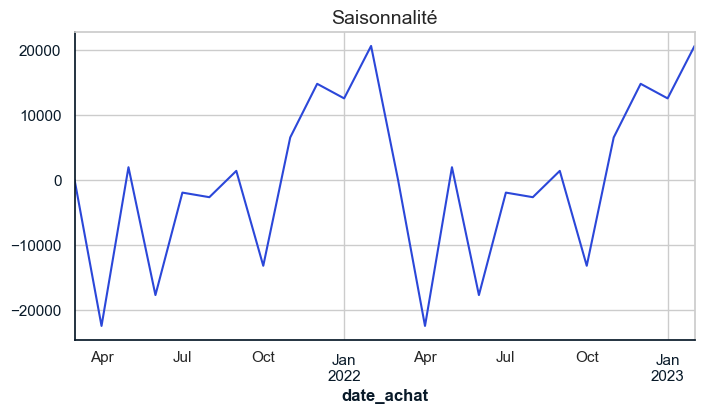

In [102]:
# Afficher la saisonnalité
plt.figure(figsize=(8, 4))  # Définir la taille de la figure
sns.set_theme(style="whitegrid")
decomposition.seasonal.plot(color='#2B47D9')  # Définir la couleur de la saisonnalité

# Obtenir les axes actuels et modifier la couleur des axes
ax = plt.gca()
ax.spines['bottom'].set_color('#091A29')
ax.spines['left'].set_color('#091A29')

# Personnaliser les étiquettes des axes avec la couleur souhaitée
ax.xaxis.label.set_color('#091A29')
ax.yaxis.label.set_color('#091A29')

# Personnaliser les graduations (ticks) des axes
ax.tick_params(axis='x', colors='#091A29')
ax.tick_params(axis='y', colors='#091A29')


# Ajouter un titre
plt.title('Saisonnalité', fontsize=14)

# Afficher le graphique
plt.show()

In [103]:
# Extraire la saisonnalité 
saisonnalite = decomposition.seasonal

In [104]:
# Exporter les données au format xlsx
saisonnalite.to_excel('saisonnalite.xlsx')

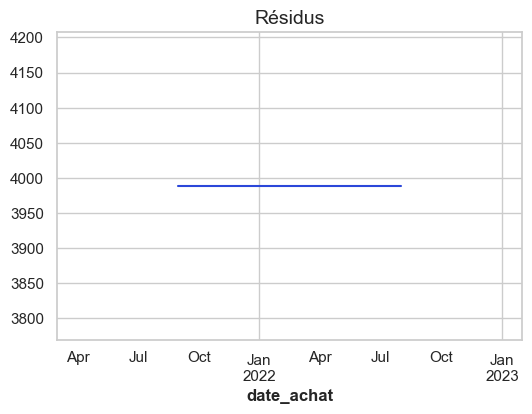

In [105]:
# Afficher les résidus
plt.figure(figsize=(6, 4))  # Définir la taille de la figure
sns.set_theme(style="whitegrid")
decomposition.resid.plot(color='#2B47D9')  # Définir la couleur de la résidus

# Ajouter un titre
plt.title('Résidus', fontsize=14)

# Afficher le graphique
plt.show()

In [106]:
# Calcul du chiffre d'affaires par catégorie 
chiffre_affaires_categ = df_ventes.groupby('categ', observed=True).agg(ca_categorie = ('price', 'sum')).reset_index()
chiffre_affaires_categ.head()

categ  ca_categorie
0     0    4419730.97
1     1    4827657.11
2     2    2780275.02

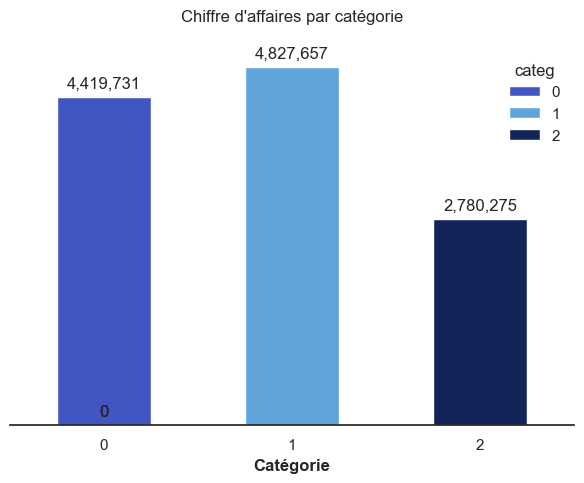

In [267]:
# Créer le graphique en barres pour le chiffre d'affaires par catégorie
custom_params = {"axes.spines.right": False, "axes.spines.left": False,"axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)
plt.figure(figsize=(6, 5))  # Définir la taille du graphique

# Ajouter une palette de couleurs personnalisée et ajuster la largeur des barres
ax = sns.barplot(data=chiffre_affaires_categ, x='categ', y='ca_categorie', hue='categ',
                 palette=['#2B47D9', '#4BA6EE', '#061E64'], width=0.5)

# Ajouter les valeurs du chiffre d'affaires avec séparateur de milliers au-dessus de chaque barre
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),  # Formater avec séparateur de milliers
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)

# Ajouter un titre et des labels
plt.title("Chiffre d'affaires par catégorie", pad=20)
plt.xlabel("Catégorie")
plt.ylabel("")

# Supprimer les étiquettes de l'axe des ordonnées
plt.gca().set_yticklabels([])

# Afficher le graphique
plt.tight_layout()
plt.show()

In [108]:
# Calcul du chiffre d'affaires annuel par catégorie
chiffre_affaires_categ2 = df_ventes.pivot_table(index=['categ', 'annee_achat'], values='price', aggfunc='sum', observed=False).reset_index()
chiffre_affaires_categ2 = chiffre_affaires_categ2.sort_values(by='annee_achat', ascending=True)
chiffre_affaires_categ2.head()

categ  annee_achat       price
0     0         2021  1883020.45
3     1         2021  1951930.27
6     2         2021  1109810.26
1     0         2022  2192970.46
4     1         2022  2485275.19

In [109]:
# Exporter les données au format xlsx
chiffre_affaires_categ2.to_excel('ca_par_categorie.xlsx')

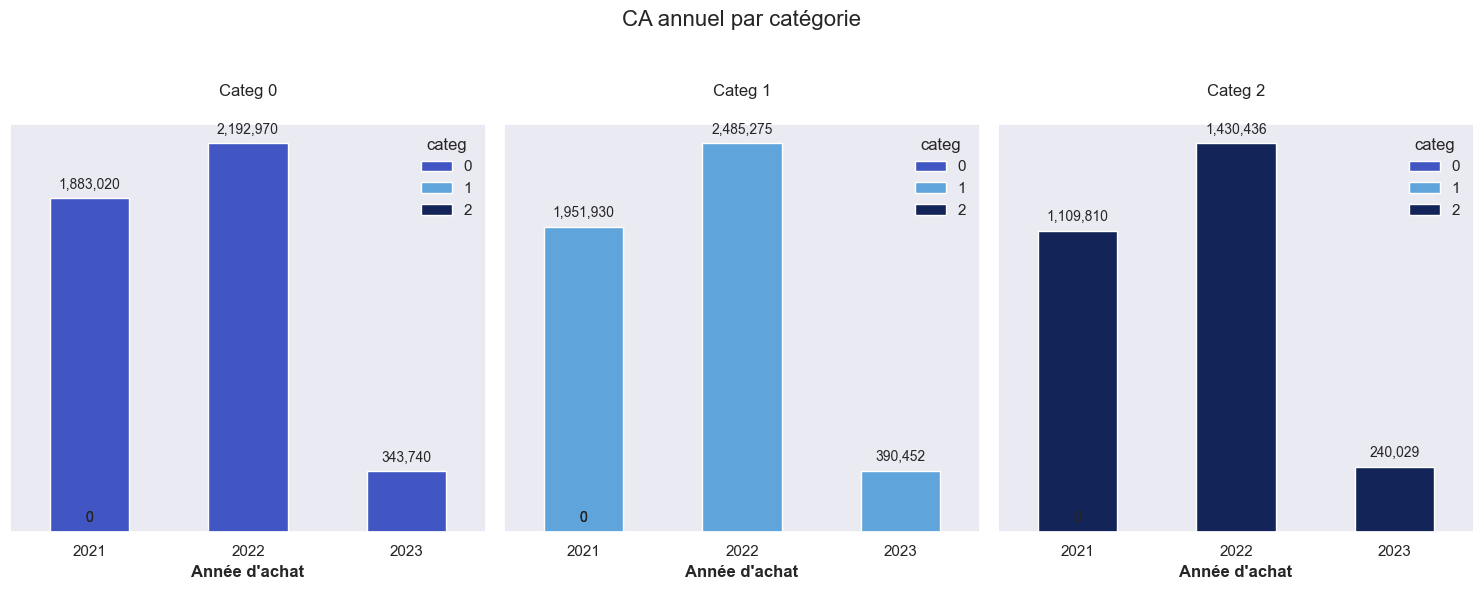

In [269]:
# Lister les catégories uniques
categories = chiffre_affaires_categ2['categ'].unique()

# Créer une palette de couleurs personnalisée
palette = ['#2B47D9', '#4BA6EE', '#061E64']

custom_params = {"axes.spines.right": True, "axes.spines.left": True,"axes.spines.top": True}
sns.set_theme(style="darkgrid", rc=custom_params)

#  Créer des sous-graphiques
fig, axes = plt.subplots(1, len(categories), figsize=(15, 6))  # Définir les sous-graphiques

# Ajouter des graphiques en barres dans chaque subplot
for i, categ in enumerate(categories):
    df_filtered = chiffre_affaires_categ2[chiffre_affaires_categ2['categ'] == categ]
    
    # Vérifier s'il n'y a qu'une seule catégorie (cas où axes ne serait pas un tableau)
    if len(categories) == 1:
        ax = axes
    else:
        ax = axes[i]
    
    # Créer un graphique en barres avec la palette personnalisée
    sns.barplot(x='annee_achat', y='price', data=df_filtered, ax=ax, palette=palette, width=0.5, hue='categ')
    
    # Ajouter les valeurs du chiffre d'affaires au-dessus de chaque barre avec séparateur de milliers
    for p in ax.patches:
        ax.annotate(format(p.get_height(), ',.0f'),  # Formater avec séparateur de milliers
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
    
    # Ajouter un titre à chaque subplot
    ax.set_title(f'Categ {categ}', pad=20)
    ax.set_xlabel('Année d\'achat')
    ax.set_ylabel('Chiffre d\'affaires')
    ax.get_yaxis().set_visible(False)

# 5. Mettre à jour la mise en page du graphique
plt.suptitle("CA annuel par catégorie", fontsize=16)  # Titre général
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuster l'espacement

# Supprimer les étiquettes de l'axe des ordonnées
plt.gca().set_yticklabels([])

# 6. Afficher le graphique
plt.show()


In [111]:
# Agréger les données par année sur la colonne 'session_id'
nbre_transactions = df_ventes.groupby('annee_achat').agg({'session_id': 'count'}).reset_index()

# Renommer la colonne 'session_id' par 'transactions'
nbre_transactions.rename(columns={'session_id': 'transactions'}, inplace=True)

nbre_transactions.head()

annee_achat  transactions
0         2021        286671
1         2022        346380
2         2023         54483

In [112]:
# Exporter les données au format excel
nbre_transactions.to_excel('nbre_transactions.xlsx')

Déterminer le nombre de transactions mensuelles

In [113]:
# Agréger les données par année sur la colonne 'session_id'
nbre_transactions_mois = df_ventes.groupby('mois_achat').agg({'session_id': 'count'}).reset_index()

# Renommer la colonne 'session_id' par 'transactions'
nbre_transactions_mois.rename(columns={'session_id': 'transactions'}, inplace=True)

# Afficher les premières valeurs
nbre_transactions_mois.head()

mois_achat  transactions
0    2021-03         28601
1    2021-04         28443
2    2021-05         28285
3    2021-06         26850
4    2021-07         24738

C:\Users\jerem\AppData\Local\Temp\ipykernel_17296\3653642202.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mois_achat', y='transactions', data=nbre_transactions_mois, palette=palette, width=0.6)
C:\Users\jerem\AppData\Local\Temp\ipykernel_17296\3653642202.py:9: UserWarning: 
The palette list has fewer values (1) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='mois_achat', y='transactions', data=nbre_transactions_mois, palette=palette, width=0.6)


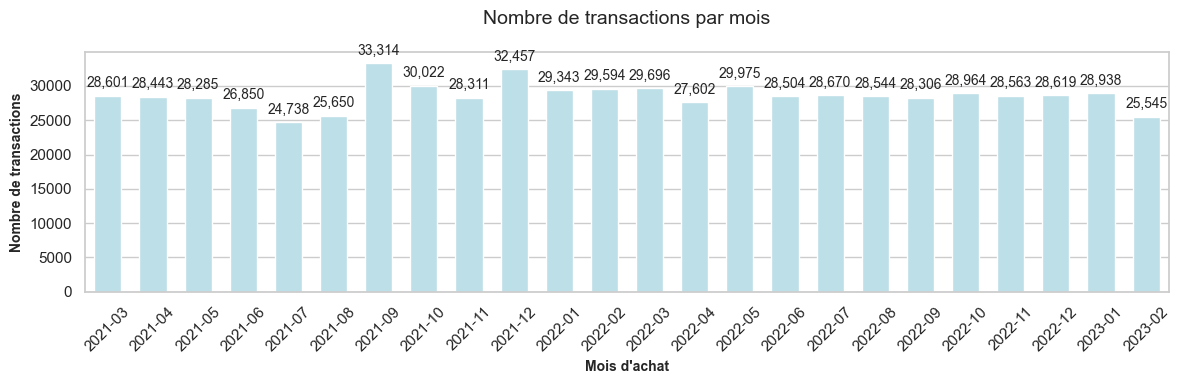

In [114]:
# Créer un graphique en barres avec des couleurs personnalisées et ajustement de la largeur des colonnes
plt.figure(figsize=(12, 4))  # Taille du graphique (largeur=6, hauteur=4)
sns.set_theme(style="whitegrid")

# Palette de couleurs personnalisée
palette = ['#B6E4EE']

# Créer un graphique en barres avec la palette personnalisée et la largeur des colonnes modifiable
sns.barplot(x='mois_achat', y='transactions', data=nbre_transactions_mois, palette=palette, width=0.6)

# Ajouter les valeurs (nombre de transactions) au-dessus de chaque barre avec un séparateur de milliers
for p in plt.gca().patches:
    plt.annotate(format(p.get_height(), ',.0f'),  # Formater avec séparateur de milliers
                 (p.get_x() + p.get_width() / 2., p.get_height()),  # Position de l'annotation
                 ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

# Ajouter un titre et des labels
plt.title('Nombre de transactions par mois', fontsize=14, pad=20)
plt.xlabel('Mois d\'achat', fontsize=10)
plt.ylabel('Nombre de transactions', fontsize=10)

# Ajouter des rotations aux étiquettes de l'axe X si nécessaire
plt.xticks(rotation=45)

# Afficher le graphique avec un ajustement automatique des marges
plt.tight_layout()
plt.show()

In [115]:
# Exporter les données au format xlsx
nbre_transactions_mois.to_excel('nbre_transactions_mois.xlsx')

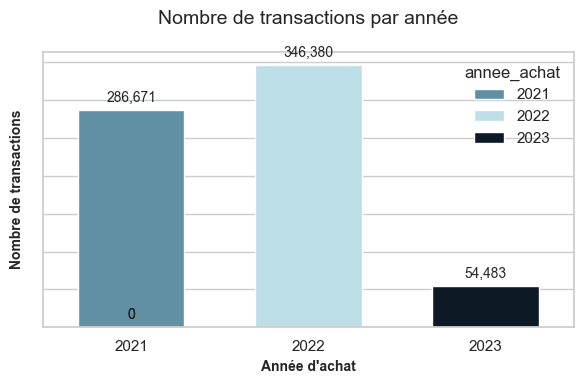

In [116]:
# Créer un graphique en barres avec des couleurs personnalisées et ajustement de la largeur des colonnes
plt.figure(figsize=(6, 4))  # Taille du graphique (largeur=6, hauteur=4)
sns.set_theme(style="whitegrid")

# Palette de couleurs personnalisée
palette = ['#5594B1', '#B6E4EE', '#091A29']

# Créer un graphique en barres avec la palette personnalisée et la largeur des colonnes modifiable
sns.barplot(x='annee_achat', y='transactions', data=nbre_transactions, palette=palette, width=0.6, hue='annee_achat')

# Ajouter les valeurs (nombre de transactions) au-dessus de chaque barre avec un séparateur de milliers
for p in plt.gca().patches:
    plt.annotate(format(p.get_height(), ',.0f'),  # Formater avec séparateur de milliers
                 (p.get_x() + p.get_width() / 2., p.get_height()),  # Position de l'annotation
                 ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

# Ajouter un titre et des labels
plt.title('Nombre de transactions par année', fontsize=14, pad=20)
plt.xlabel('Année d\'achat', fontsize=10)
plt.ylabel('Nombre de transactions', fontsize=10)

# Supprimer les étiquettes de l'axe des ordonnées
plt.gca().set_yticklabels([])


# Afficher le graphique avec un ajustement automatique des marges
plt.tight_layout()
plt.show()


Déterminer le nombre de clients (uniques) par mois

In [117]:
# Agréger les données par année sur la colonne 'client_id'
nbre_clients = df_ventes.groupby('mois_achat').agg({'client_id': 'nunique'}).reset_index()

# Renommer la colonne 'client_id' par 'nbre_clients'
nbre_clients.rename(columns={'client_id': 'nbre_clients_uniques'}, inplace=True)

nbre_clients.head()

mois_achat  nbre_clients_uniques
0    2021-03                  5676
1    2021-04                  5674
2    2021-05                  5644
3    2021-06                  5659
4    2021-07                  5672

In [118]:
# Exporter les données au format xlsx
nbre_clients.to_excel('nbre_clients.xlsx')

In [119]:
nbre_clients['mois_achat'] = nbre_clients['mois_achat'].dt.to_timestamp()

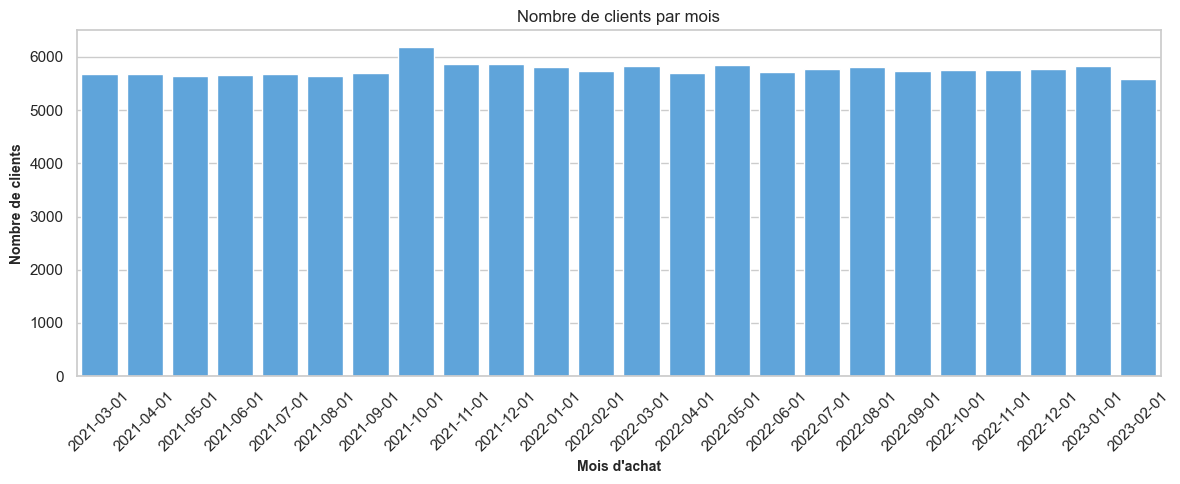

In [120]:
# Créer un graphique en barres
plt.figure(figsize=(12, 5))  # Définir la taille du graphique (width=8, height=4)
sns.set_theme(style="whitegrid")
sns.barplot(x='mois_achat', y='nbre_clients_uniques', data=nbre_clients, color='#4BA6EE')

# Ajouter un titre et des labels
plt.title('Nombre de clients par mois', fontsize=12)
plt.xlabel('Mois d\'achat', fontsize=10)
plt.ylabel('Nombre de clients', fontsize=10)

# Ajouter des rotations aux étiquettes de l'axe X si nécessaire
plt.xticks(rotation=45)

# Afficher le graphique
plt.tight_layout()
plt.show()

Déterminer le nombre de produits (uniques) vendus par mois

In [121]:
# Filter le dataframe df_ventes 
produits_vendus = df_ventes.loc[:, ['id_prod', 'categ', 'mois_achat', 'annee_achat', 'session_id']]
produits_vendus.head()

id_prod categ mois_achat  annee_achat session_id
0  0_1090     0    2021-12         2021   s_136532
1  0_1186     0    2021-07         2021    s_66947
2  0_1186     0    2022-08         2022   s_258252
3  0_1378     0    2021-08         2021    s_79696
4  0_1378     0    2022-07         2022   s_242617

In [122]:
# Agréger les données par année sur la colonne 'client_id'
produits_vendus_annee = produits_vendus.groupby('annee_achat').agg({'id_prod': 'nunique'}).reset_index()

# Renommer la colonne 'client_id' par 'nbre_clients'
produits_vendus_annee.rename(columns={'id_prod': 'nbre_produits_uniques'}, inplace=True)

produits_vendus_annee.head()

annee_achat  nbre_produits_uniques
0         2021                   3253
1         2022                   3220
2         2023                   2791

In [123]:
# Exporter les données au format xlsx
produits_vendus_annee.to_excel('nbre_produits_vendus_an.xlsx')

In [272]:
# Créer un graphique en barres avec des couleurs personnalisées et ajustement de la largeur des colonnes
plt.figure(figsize=(6, 4))  # Taille du graphique (largeur=6, hauteur=4)
sns.set_theme(style="whitegrid")

# Palette de couleurs personnalisée
palette = ['#5594B1', '#B6E4EE', '#091A29']

# Créer un graphique en barres avec la palette personnalisée et la largeur des colonnes modifiable
sns.barplot(x='annee_achat', y='nbre_produits_uniques', data=produits_vendus_annee, palette=palette, width=0.6, hue='annee_achat')

# Ajouter les valeurs (nombre de transactions) au-dessus de chaque barre avec un séparateur de milliers
for p in plt.gca().patches:
    plt.annotate(format(p.get_height(), ',.0f'),  # Formater avec séparateur de milliers
                 (p.get_x() + p.get_width() / 2., p.get_height()),  # Position de l'annotation
                 ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=11)

# Ajouter un titre et des labels
plt.title('Nombre de produits vendus par année', fontsize=14, pad=20)
plt.xlabel('Année d\'achat', fontsize=10)
plt.ylabel('', fontsize=10)

# Supprimer les étiquettes de l'axe des ordonnées
plt.gca().set_yticklabels([])

# Supprimer la légende
plt.legend().remove()

# Afficher le graphique avec un ajustement automatique des marges
plt.tight_layout()
plt.show()

In [125]:
# Agréger les données par mois sur la colonne 'id_prod'
produits_vendus_mois = produits_vendus.groupby('mois_achat').agg({'id_prod': 'nunique'}).reset_index()

# Renommer la colonne 'id_prod' par 'nbre_produits'
produits_vendus_mois.rename(columns={'id_prod': 'nbre_produits_uniques'}, inplace=True)

produits_vendus_mois.head()

mois_achat  nbre_produits_uniques
0    2021-03                   2482
1    2021-04                   2492
2    2021-05                   2471
3    2021-06                   2414
4    2021-07                   2369

In [126]:
# Exporter les données au format xlsx
produits_vendus_mois.to_excel('nbre_produits_vendus_mois.xlsx')

In [127]:
# convertir la colonne mois_achat au format datetime
produits_vendus_mois['mois_achat'] = produits_vendus_mois['mois_achat'].dt.to_timestamp()

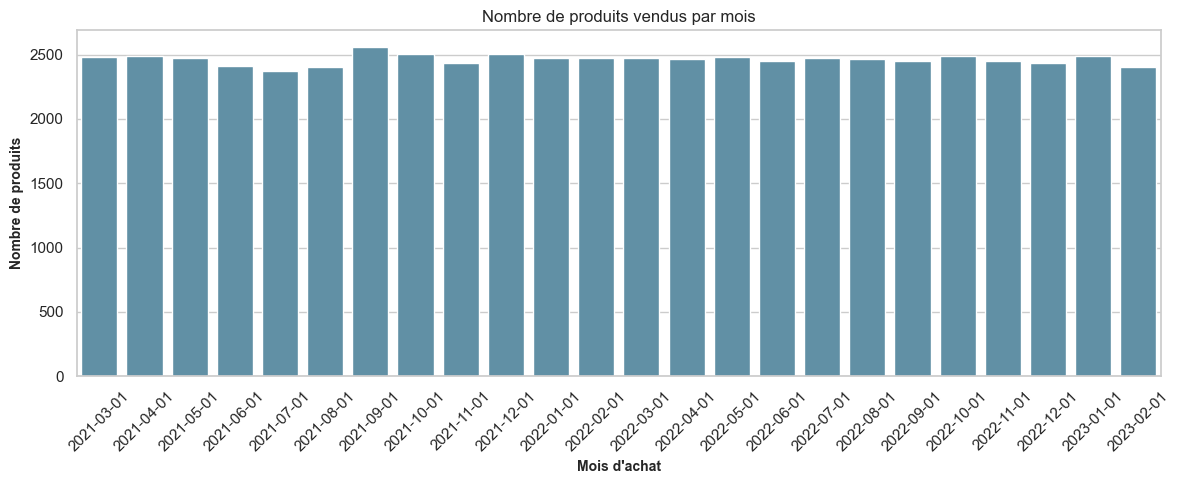

In [128]:
# Créer un graphique en barres
plt.figure(figsize=(12, 5))  # Définir la taille du graphique
sns.set_theme(style="whitegrid")

sns.barplot(x='mois_achat', y='nbre_produits_uniques', data=produits_vendus_mois, color='#5594B1')

# Ajouter un titre et des labels
plt.title('Nombre de produits vendus par mois', fontsize=12)
plt.xlabel('Mois d\'achat', fontsize=10)
plt.ylabel('Nombre de produits', fontsize=10)

# Ajouter des rotations aux étiquettes de l'axe X si nécessaire
plt.xticks(rotation=45)

# Afficher le graphique
plt.tight_layout()
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.4 - Les tops et les flops produits</h3>
</div>

In [129]:
produits_vendus.head()

id_prod categ mois_achat  annee_achat session_id
0  0_1090     0    2021-12         2021   s_136532
1  0_1186     0    2021-07         2021    s_66947
2  0_1186     0    2022-08         2022   s_258252
3  0_1378     0    2021-08         2021    s_79696
4  0_1378     0    2022-07         2022   s_242617

In [130]:
# Agréger les données par moisid_prod sur la colonne 'session_id'
produits_vendus_session = produits_vendus.groupby('id_prod').agg({'session_id': 'count'}).reset_index()

# Renommer la colonne 'id_prod' par 'nbre_produits'
produits_vendus_session.rename(columns={'session_id': 'nbre_session'}, inplace=True)

# Classer le nombre de session par ordre décroissant
produits_vendus_session.sort_values(by='nbre_session', ascending=False ,inplace=True)

# Afficher le top 10
top_10_produits = produits_vendus_session.head(10)
top_10_produits

id_prod  nbre_session
2591   1_369          2340
2644   1_417          2269
2641   1_414          2246
2733   1_498          2202
2653   1_425          2163
2629   1_403          2040
2640   1_413          2036
2639   1_412          2014
2632   1_406          2003
2633   1_407          2001

In [131]:
# Extraire les id_prod du top 10
top_10_ids = top_10_produits['id_prod'].tolist()

# Filtrer le DataFrame df_ventes pour ne garder que les lignes avec les id_prod du top 10
df_ventes_top_10 = df_ventes[df_ventes['id_prod'].isin(top_10_ids)]

# Afficher le DataFrame filtré
df_ventes_top_10.head(10)


client_id sex      birth id_prod  price categ                       date  \
35        c_1   m 1955-01-01   1_425  16.99     1 2021-12-25 03:53:43.623598   
36        c_1   m 1955-01-01   1_425  16.99     1 2022-06-25 03:53:43.623598   
80       c_10   m 1956-01-01   1_425  16.99     1 2021-11-09 22:27:04.957488   
81       c_10   m 1956-01-01   1_425  16.99     1 2022-03-09 22:27:04.957488   
82       c_10   m 1956-01-01   1_425  16.99     1 2022-08-09 22:27:04.957488   
191    c_1000   f 1966-01-01   1_369  23.99     1 2021-10-28 08:49:11.673588   
192    c_1000   f 1966-01-01   1_369  23.99     1 2022-01-30 00:21:48.621749   
193    c_1000   f 1966-01-01   1_369  23.99     1 2022-02-07 07:31:21.209318   
194    c_1000   f 1966-01-01   1_369  23.99     1 2022-03-07 07:31:21.209318   
195    c_1000   f 1966-01-01   1_369  23.99     1 2022-04-30 00:21:48.621749   

    session_id date_achat  annee_achat mois_achat  \
35    s_139610 2021-12-25         2021    2021-12   
36    s_228867 2022-06-25         2022    2022-06   
80    s_117253 2021-11-09         2021    2021-11   
81    s_176854 2022-03-09         2022    2022-03   
82    s_250920 2022-08-09         2022    2022-08   
191   s_111262 2021-10-28         2021    2021-10   
192   s_157161 2022-01-30         2022    2022-01   
193   s_161277 2022-02-07         2022    2022-02   
194   s_175577 2022-03-07         2022    2022-03   
195   s_201343 2022-04-30         2022    2022-04   

                  annee_naissance  age_client tranche_age  
35  1970-01-01 00:00:00.000001955          66       60-69  
36  1970-01-01 00:00:00.000001955          67       60-69  
80  1970-01-01 00:00:00.000001956          65       60-69  
81  1970-01-01 00:00:00.000001956          66       60-69  
82  1970-01-01 00:00:00.000001956          66       60-69  
191 1970-01-01 00:00:00.000001966          55       50-59  
192 1970-01-01 00:00:00.000001966          56       50-59  
193 1970-01-01 00:00:00.000001966          56       50-59  
194 1970-01-01 00:00:00.000001966          56       50-59  
195 1970-01-01 00:00:00.000001966          56       50-59

On observe que les 10 meilleurs ventes sont issues de la catégorie 1.

In [132]:
# Exporter les données au format xlsx
top_10_produits.to_excel('top_10_produits.xlsx')

In [133]:
# Définir la taille du graphique
plt.figure(figsize=(12, 5))

# Créer une palette de couleurs en dégradé
cmap = sns.light_palette("#845CC2", as_cmap=True)
norm = plt.Normalize(top_10_produits['nbre_session'].min(), top_10_produits['nbre_session'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Créer le barplot avec le dégradé
ax = sns.barplot(x='id_prod', y='nbre_session', data=top_10_produits,
                 hue='nbre_session', palette=cmap, dodge=False, legend=False)

# Ajouter un titre et des labels
plt.title('Les 10 produits les plus vendus', fontsize=14, pad=20)
plt.xlabel('ID Produit', fontsize=10)
plt.ylabel('', fontsize=10)

# Ajouter les étiquettes de données au-dessus de chaque barre
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9),  # décaler l'étiquette de 9 points au-dessus de la barre
                textcoords='offset points')

# Supprimer les étiquettes de l'axe des ordonnées
plt.gca().set_yticklabels([])

# Ajuster l'affichage
plt.tight_layout()
plt.show()



In [134]:
# Afficher les 10 produits les moins vendus
flop_10_produits = produits_vendus_session.tail(10)
flop_10_produits

id_prod  nbre_session
595   0_1539             1
166   0_1151             1
802   0_1728             1
3247    2_81             1
1327  0_2201             1
1792   0_549             1
2166   0_886             1
549   0_1498             1
1784   0_541             1
313   0_1284             1

In [135]:
# Extraire les id_prod du top 10
flop_10_ids = flop_10_produits['id_prod'].tolist()

# Filtrer le DataFrame df_ventes pour ne garder que les lignes avec les id_prod du top 10
df_ventes_flop_10 = df_ventes[df_ventes['id_prod'].isin(flop_10_ids)]

# Afficher le DataFrame filtré
df_ventes_flop_10.head(10)

client_id sex      birth id_prod  price categ  \
21718     c_1261   m 1985-01-01  0_2201  20.99     0   
46495     c_1551   m 1972-01-01  0_1284   1.38     0   
97206     c_1869   f 1985-01-01   0_541   1.99     0   
102618    c_1938   f 1979-01-01  0_1498   2.48     0   
116994    c_2103   f 1973-01-01  0_1151   2.99     0   
171961    c_2768   f 1989-01-01  0_1728   2.27     0   
292369    c_4202   f 1987-01-01   0_549   2.99     0   
560802    c_7219   f 1966-01-01   0_886  21.82     0   
592697    c_7616   m 1993-01-01    2_81  86.99     2   
679899     c_881   f 1988-01-01  0_1539   0.99     0   

                             date session_id date_achat  annee_achat  \
21718  2021-10-15 09:59:39.794285   s_105077 2021-10-15         2021   
46495  2021-04-14 13:13:06.560397    s_20477 2021-04-14         2021   
97206  2021-03-08 23:45:11.524853     s_3676 2021-03-08         2021   
102618 2022-02-19 08:31:04.439133   s_167516 2022-02-19         2022   
116994 2021-09-17 05:58:49.213439    s_91113 2021-09-17         2021   
171961 2021-04-19 13:48:18.949260    s_22772 2021-04-19         2021   
292369 2021-04-11 04:42:10.308957    s_18930 2021-04-11         2021   
560802 2021-03-17 03:34:14.461358     s_7410 2021-03-17         2021   
592697 2022-02-19 14:51:58.078656   s_167662 2022-02-19         2022   
679899 2021-06-01 08:53:24.523722    s_42501 2021-06-01         2021   

       mois_achat               annee_naissance  age_client tranche_age  
21718     2021-10 1970-01-01 00:00:00.000001985          36       30-39  
46495     2021-04 1970-01-01 00:00:00.000001972          49       40-49  
97206     2021-03 1970-01-01 00:00:00.000001985          36       30-39  
102618    2022-02 1970-01-01 00:00:00.000001979          43       40-49  
116994    2021-09 1970-01-01 00:00:00.000001973          48       40-49  
171961    2021-04 1970-01-01 00:00:00.000001989          32       30-39  
292369    2021-04 1970-01-01 00:00:00.000001987          34       30-39  
560802    2021-03 1970-01-01 00:00:00.000001966          55       50-59  
592697    2022-02 1970-01-01 00:00:00.000001993          29       20-29  
679899    2021-06 1970-01-01 00:00:00.000001988          33       30-39

En revanche, les 10 plus mauvaises ventes sont associées à la catégorie 0.

In [136]:
# Exporter les données au format xlsx
flop_10_produits.to_excel('flop_10_produits.xlsx')

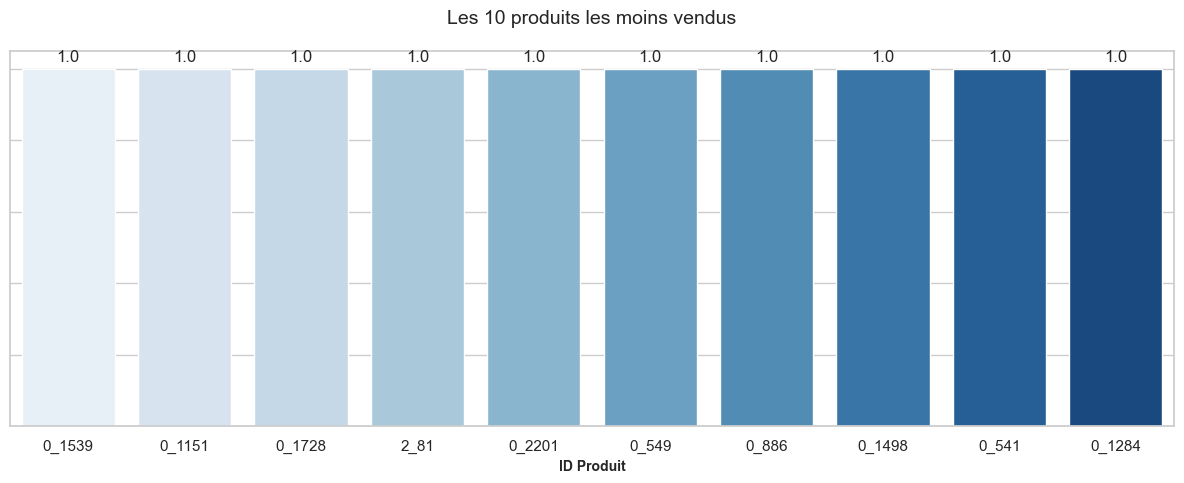

In [137]:
# Définir la taille du graphique
plt.figure(figsize=(12, 5))

# Créer une palette de couleurs en dégradé pour le nombre total de produits
cmap = sns.color_palette("Blues", n_colors=len(flop_10_produits))

# Créer le barplot avec le dégradé
ax = sns.barplot(x='id_prod', y='nbre_session', data=flop_10_produits,
                 palette=cmap, dodge=False, hue='id_prod', legend=False)

# Ajouter un titre et des labels
plt.title('Les 10 produits les moins vendus', fontsize=14, pad=20)
plt.xlabel('ID Produit', fontsize=10)
plt.ylabel('', fontsize=10)

# Ajouter les étiquettes de données au-dessus de chaque barre
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','),  # Format pour le séparateur de milliers
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9),  # décaler l'étiquette de 9 points au-dessus de la barre
                textcoords='offset points')

# Supprimer les étiquettes de l'axe des ordonnées
plt.gca().set_yticklabels([])

# Ajuster l'affichage
plt.tight_layout()
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.5 - Déterminer le nombre de produits qui représentent 80% du CA en 2022.</h3>
</div>

In [138]:
# Filtrer les données pour l'année 2022
df_ventes_2022 = df_ventes[df_ventes['annee_achat'] == 2022]

# Calcul du chiffre d'affaires par produit
ca_par_prod = df_ventes_2022.groupby('id_prod')['price'].sum().reset_index()

# Classer les produits par ordre décroissant de CA
ca_par_prod.sort_values(by='price', ascending=False, inplace=True)

# Créer une colonne calculant la part du CA de chaque produit dans le dataset
ca_par_prod['ca_%'] = ca_par_prod['price'] / ca_par_prod['price'].sum() * 100

# Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
ca_par_prod['ca_%_cumul'] = ca_par_prod['ca_%'].cumsum()

# Calculer le nombre de produits représentant 80% du CA
produits_80_perc_ca = ca_par_prod.loc[ca_par_prod['ca_%_cumul'] <= 80]
nombre_produits_80_perc = len(produits_80_perc_ca['id_prod'])

print(f"Nombre de produits uniques qui représentent 80% du CA en 2022: {nombre_produits_80_perc}")


Nombre de produits uniques qui représentent 80% du CA en 2022: 690


In [139]:
# Extraire le nombre de produits uniques
total_articles_uniques = df_ventes_2022['id_prod'].nunique()
print(f"Nombre total d'articles uniques en 2022: {total_articles_uniques}")

print(f"Nombre de produits uniques qui représentent 80% du CA en 2022: {nombre_produits_80_perc}")

# Calcul de la proportion que représente ce groupe d'articles dans le catalogue entier
proportion_groupe_articles = round(nombre_produits_80_perc / total_articles_uniques * 100, 1)
print(f"Proportion de ce groupe d'articles dans le catalogue: {proportion_groupe_articles}%")


Nombre total d'articles uniques en 2022: 3220
Nombre de produits uniques qui représentent 80% du CA en 2022: 690
Proportion de ce groupe d'articles dans le catalogue: 21.4%


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 6 - Analyse des comportements clients</h2>
</div>

Calculer le chiffre d'affaires par clients

In [140]:
ca_par_clients = df_ventes.groupby(['client_id', 'annee_achat']).agg({'price': 'sum'}, observed=False).reset_index()
ca_par_clients = ca_par_clients.sort_values(by='price', ascending=False)
ca_par_clients.head(15)

client_id  annee_achat      price
1913     c_1609         2022  164358.02
12335    c_4958         2022  150247.66
1912     c_1609         2021  137155.90
12334    c_4958         2021  116987.31
17808    c_6714         2022   78655.94
17807    c_6714         2021   61287.03
7650     c_3454         2022   59999.26
7649     c_3454         2021   44354.60
1914     c_1609         2023   24525.97
12336    c_4958         2023   22992.06
17809    c_6714         2023   13975.63
7651     c_3454         2023    9756.71
1320     c_1422         2022    3157.75
7062     c_3263         2022    3072.44
9024     c_3892         2022    3010.07

In [141]:
ca_par_clients.head(12).to_excel('clients_btob.xlsx')

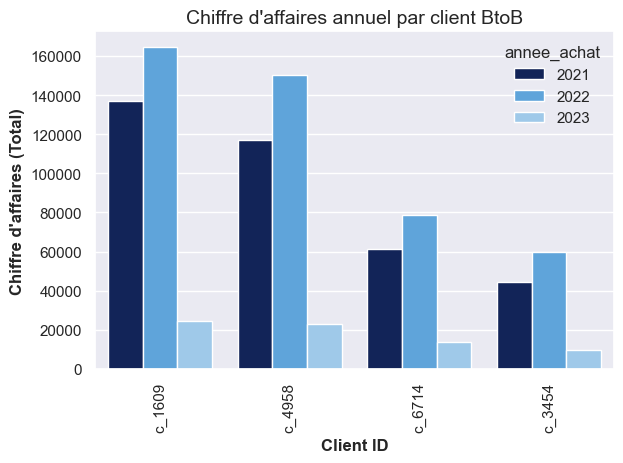

In [142]:
# Utilisation de seaborn pour une meilleure présentation des barres
sns.set_theme(style='darkgrid')
custom_palette = ['#061E64', '#4BA6EE', '#93CAF5']
sns.barplot(x='client_id', y='price', hue='annee_achat', data=ca_par_clients.head(12), palette=custom_palette)

# Ajouter des titres et labels
plt.title('Chiffre d\'affaires annuel par client BtoB', fontsize=14)
plt.xlabel('Client ID', fontsize=12)
plt.ylabel('Chiffre d\'affaires (Total)', fontsize=12)
plt.xticks(rotation=90)  # Rotation des labels des clients pour mieux les visualiser

# Afficher le graphique
plt.tight_layout()
plt.show()

Plusieurs acheteurs ont un montant de dépenses supérieure à 3200 €.

4 clients BtoB se trouvent au sein de notre portefeuille clients

In [143]:
# Extraire les clients btob dans un dataframe
ca_par_clients_btob = ca_par_clients.loc[ca_par_clients['price']> 3200]
ca_par_clients_btob

client_id  annee_achat      price
1913     c_1609         2022  164358.02
12335    c_4958         2022  150247.66
1912     c_1609         2021  137155.90
12334    c_4958         2021  116987.31
17808    c_6714         2022   78655.94
17807    c_6714         2021   61287.03
7650     c_3454         2022   59999.26
7649     c_3454         2021   44354.60
1914     c_1609         2023   24525.97
12336    c_4958         2023   22992.06
17809    c_6714         2023   13975.63
7651     c_3454         2023    9756.71

In [144]:
analyse_correlation = df_ventes.groupby(['client_id', 'age_client']).agg({
    'session_id':'count',
    'price':['sum','mean']}).reset_index()

# Afficher le dataframe
analyse_correlation.head()

client_id age_client session_id   price           
                            count     sum       mean
0       c_1         66         23  365.50  15.891304
1       c_1         67         18  219.23  12.179444
2       c_1         68          2   44.29  22.145000
3      c_10         65         28  586.18  20.935000
4      c_10         66         25  602.93  24.117200

Matrice de corrélation:
                 age_client  frequence_achat  montant_total  panier_moyen
age_client         1.000000        -0.001081      -0.043157     -0.452262
frequence_achat   -0.001081         1.000000       0.884342     -0.060472
montant_total     -0.043157         0.884342       1.000000      0.026086
panier_moyen      -0.452262        -0.060472       0.026086      1.000000


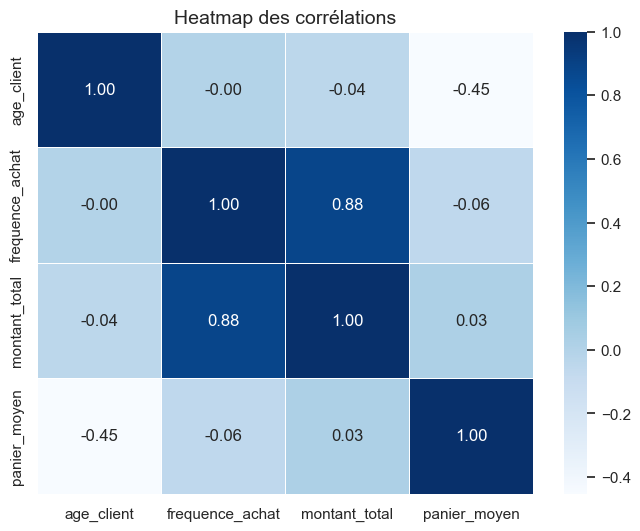

In [145]:
# Renommer les colonnes pour faciliter la manipulation
analyse_correlation.columns = ['client_id', 'age_client', 'frequence_achat', 'montant_total', 'panier_moyen']

# Calcul de la matrice de corrélation
correlation_matrix = analyse_correlation[['age_client', 'frequence_achat','montant_total', 'panier_moyen']].corr()

# Affichage de la matrice de corrélation
print('Matrice de corrélation:')
print(correlation_matrix)

# Visualisation de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Heatmap des corrélations', fontsize=14)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.1 - Lien entre le genre d’un client et les catégories des livres achetés</h3>
</div>

In [146]:
analyse_1 = df_ventes.loc[:, ['sex', 'categ', 'session_id', 'annee_achat']]
analyse_1.head()

sex categ session_id  annee_achat
0   m     0   s_136532         2021
1   m     0    s_66947         2021
2   m     0   s_258252         2022
3   m     0    s_79696         2021
4   m     0   s_242617         2022

In [147]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Agréger les données par mois sur la colonne 'id_prod'
analyse_1 = analyse_1.groupby(['sex','categ', 'annee_achat']).agg({'session_id': 'count'}, observed=False).reset_index()

# Renommer la colonne 'id_prod' par 'nbre_produits'
analyse_1.rename(columns={'session_id': 'nbre_achats'}, inplace=True)

analyse_1.head()

sex categ  annee_achat  nbre_achats
0   f     0         2021        87456
1   f     0         2022       102518
2   f     0         2023        16129
3   f     1         2021        48165
4   f     1         2022        61509

In [148]:
# Transformer en tableau de contingence
table_contingence = pd.pivot_table(analyse_1, 
                                   values='nbre_achats', 
                                   index=['sex'],       # Variable sur l'axe des lignes
                                   columns=['categ'],   # Variable sur l'axe des colonnes
                                   aggfunc='sum',       # Fonction d'agrégation
                                   fill_value=0,
                                   observed=False,
                                   margins=True,
                                   margins_name='Total')        # Remplacer les valeurs manquantes par 0

# Afficher le tableau de contingence
table_contingence.head()

categ       0       1      2   Total
sex                                 
f      206103  119307  17283  342693
m      209356  116285  19200  344841
Total  415459  235592  36483  687534

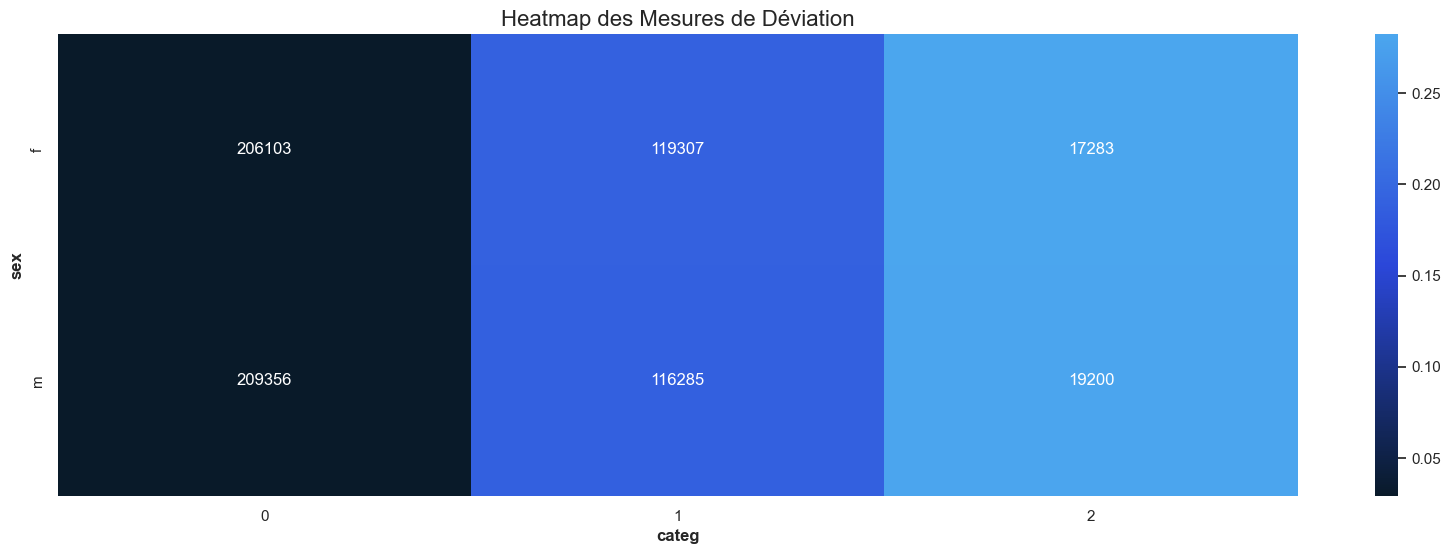

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Créer une palette de couleurs personnalisée
custom_palette = LinearSegmentedColormap.from_list("custom_palette", ["#091A29", "#2B47D9", "#4BA6EE"])

# Calculs (garde ton code original pour ces parties)
tx = table_contingence.loc[:,["Total"]]
ty = table_contingence.loc[["Total"],:]
n = len(df_ventes)
indep = tx.dot(ty) / n
c = table_contingence.fillna(0) # Remplacer les valeurs nulles par 0

measure = (c - indep)**2 / indep
xi_n = measure.sum().sum()
table = (measure / xi_n)

# Créer la heatmap avec la palette de couleurs personnalisée
plt.figure(figsize=(20, 6))
sns.heatmap(table.iloc[:-1, :-1], annot=c.iloc[:-1, :-1], fmt=".0f", cmap=custom_palette)

# Titre du graphique
plt.title("Heatmap des Mesures de Déviation", fontsize=16)
plt.show()


In [150]:
# Exporter les données au format xlsx
table_contingence.to_excel('tab_contingence_sex_categ.xlsx')

In [275]:
# Lister les catégories uniques
categories = analyse_1['categ'].unique()

# Définir un thème
sns.set_theme(style="whitegrid")
custom_palette = (["#061E64", "#4BA6EE"])

# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(1, len(categories), figsize=(15, 6), sharey=True)

# Ajouter chaque graphique en barre dans le subplot correspondant
for i, categ in enumerate(categories):
    df_filtered = analyse_1[analyse_1['categ'] == categ]
    sns.barplot(x='sex', y='nbre_achats', data=df_filtered, hue='sex', ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_title(f'Categ {categ}')
    axes[i].set_xlabel('Sexe')
    axes[i].set_ylabel('Nombre d\'achats')

# Mettre à jour le titre principal et ajuster la mise en page
plt.suptitle("Nombre de ventes par catégories et sexe", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuster pour le titre principal

# Afficher le graphique
plt.show()

In [152]:
# Réaliser le test du Chi²
chi2_stat, p_val, dof, expected = st.chi2_contingency(table_contingence)

# Afficher les résultats
print("Tableau de contingence :")
print(table_contingence)
print("\nStatistique Chi² :", chi2_stat)
print("p-valeur :", p_val)
print("Degrés de liberté :", dof)
print("\nTableau attendu sous H0 (indépendance) :")
print(expected)

# Conclusion selon la p-valeur
if p_val < 0.05:
    print("\nIl existe une association significative entre 'sex' et 'categ' (p < 0.05).")
else:
    print("\nAucune association significative entre 'sex' et 'categ' (p >= 0.05).")


Tableau de contingence :
categ       0       1      2   Total
sex                                 
f      206103  119307  17283  342693
m      209356  116285  19200  344841
Total  415459  235592  36483  687534

Statistique Chi² : 158.25417617304882
p-valeur : 1.3871985875925787e-31
Degrés de liberté : 6

Tableau attendu sous H0 (indépendance) :
[[207080.50959953 117427.98066132  18184.50973915 342693.        ]
 [208378.49040047 118164.01933868  18298.49026085 344841.        ]
 [415459.         235592.          36483.         687534.        ]]

Il existe une association significative entre 'sex' et 'categ' (p < 0.05).


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.2 - Lien entre l'âge des clients et le montant total des achats</h3>
</div>

In [153]:
analyse_2 = df_ventes.groupby(['client_id','age_client', 'annee_achat']).agg({'price': 'sum'}).reset_index()
analyse_2.head()

client_id  age_client  annee_achat   price
0       c_1          66         2021  365.50
1       c_1          67         2022  219.23
2       c_1          68         2023   44.29
3      c_10          65         2021  586.18
4      c_10          66         2022  602.93

In [278]:
# Afficher la nuage de points
analyse_2 = analyse_2.reset_index()

sns.scatterplot(analyse_2, x='age_client', y='price', color='')
plt.ylabel('Montant total')
plt.xlabel('Age des clients')
plt.title('Montant total des achats par âge')

ValueError: cannot insert level_0, already exists

In [155]:
analyse_2 = analyse_2.reset_index()

x = analyse_2['age_client']  
y = analyse_2['price'] 

# La fonction pearsonr retourne deux valeurs : coefficient de corrélation et p-value
correlation_coefficient, p_valeur = st.pearsonr(x, y)

# Afficher les résultats
print(f"Corrélation de Pearson : {correlation_coefficient}")
print(f"P-value : {p_valeur}")

# Conclusion selon la p-value
if p_valeur < 0.05:
    print("La corrélation est significative (p-value < 0.05). Il existe une corrélation entre l'âge du client et le montant total.")
else:
    print("La corrélation n'est pas significative (p-value >= 0.05). Il n'y a pas de corrélation statistiquement significative entre l'âge du client et le montant total.")

Corrélation de Pearson : -0.04315725201968771
P-value : 1.879537913514373e-11
La corrélation est significative (p-value < 0.05). Il existe une corrélation entre l'âge du client et le montant total.


In [156]:
# Exporter au format xlsx
analyse_2.to_excel('analyse_2.xlsx')

In [157]:
import statsmodels.api as sm

# Variables indépendantes et dépendantes
x = analyse_2['age_client']  # Variable indépendante (age_client)
y = analyse_2['price']       # Variable dépendante (price)

# Ajouter une constante (pour l'intercept) à la variable X
x = sm.add_constant(x)

# Ajuster le modèle de régression linéaire
reg_lin_1 = sm.OLS(y, x)
results_1 = reg_lin_1.fit()

# Afficher le résumé du modèle
print(results_1.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     45.14
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           1.88e-11
Time:                        17:04:15   Log-Likelihood:            -2.1892e+05
No. Observations:               24190   AIC:                         4.379e+05
Df Residuals:                   24188   BIC:                         4.379e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        729.5646     37.038     19.698      0.0

In [158]:
# Récupérer les coefficients
coefficients = results_1.params
intercept = coefficients.iloc[0]  # Constante (β0) avec .iloc
t_value = results_1.tvalues[1] 
slope = coefficients.iloc[1]       # Pente (β1) avec .iloc
p_value = results_1.pvalues.iloc[1]  # p-value associée à l'age_client avec .iloc
r_squared = results_1.rsquared

# Créer un tableau avec les résultats
table = [
    ['Intercept', intercept],
    ['Statistique t du coefficient age_client', t_value],
    ['Pente', slope],
    ['P-value', p_value],
    ['R2', r_squared]
]

# Afficher les résultats avec tabulate
print(tabulate(table, headers=['Metric', 'Value'], tablefmt='github'))

| Metric                                  |         Value |
|-----------------------------------------|---------------|
| Intercept                               | 729.565       |
| Statistique t du coefficient age_client |  -6.71829     |
| Pente                                   |  -5.28974     |
| P-value                                 |   1.87954e-11 |
| R2                                      |   0.00186255  |


In [159]:
# Conclusion selon la p-valeur
if p_value < 0.05:
    print("\nIl existe une association significative entre 'age et 'montant total des achats' (p < 0.05).")
else:
    print("\nAucune association significative entre 'age' et 'montant total des achats' (p >= 0.05).")


Il existe une association significative entre 'age et 'montant total des achats' (p < 0.05).


In [160]:
# Extraire les coefficients
coefficients = results_1.params
intercept = coefficients[0]  # Intercept
slope = coefficients[1]      # Pente
print(f"Intercept : {intercept}, Slope : {slope}")

# Extraire la p-value pour la pente
p_value = results_1.pvalues[1]

# Visualisation avec la droite de régression et la p-value
plt.figure(figsize=(6, 4))
sns.regplot(x='age_client', y='price', color='#2B47D9', data=analyse_2, line_kws={'color': 'red'})
plt.xlabel('Age')
plt.ylabel('Montant total')
plt.title('Régression Linéaire: Age vs Montant total des achats')

# Ajouter la p-value et l'équation de la droite de régression sur le graphique
equation_text = f'y = {intercept:.2f} + {slope:.2f}x'

# Affichage de l'équation de la droite de régression (au-dessus de la p-value)
plt.text(x=analyse_2['age_client'].max() * 0.7, 
         y=analyse_2['price'].max() * 0.9, 
         s=equation_text, fontsize=10, color='black')

# Affichage de la p-value
plt.text(x=analyse_2['age_client'].max() * 0.8, 
         y=analyse_2['price'].max() * 0.8, 
         s=f'p-value: {p_value:.3f}', fontsize=10, color='black')

# Afficher le graphique
plt.show()

Intercept : 729.5646046112196, Slope : -5.289737405574812


Le R2 est içi très faible : 0.002

Les points influents pourraient fortement affecter les résultats du modèle, faussant ainsi son calcul. 

Les clients BtoB par l'importance de leurs montants vont être supprimés du modèle. Ainsi seul, les clients BtoC sont conservés. On peut considérer la pertinence de distinguer les 2 activités (BtoB et BtoC séparement)

In [161]:
# Filtrer les lignes de l'analyse_2 en excluant celles dont les client_id sont dans clients_btob

analyse_2_filtered = analyse_2[~analyse_2['client_id'].isin(ca_par_clients_btob['client_id'])]

# Afficher le DataFrame filtré
analyse_2_filtered.head()

level_0  index client_id  age_client  annee_achat   price
0        0      0       c_1          66         2021  365.50
1        1      1       c_1          67         2022  219.23
2        2      2       c_1          68         2023   44.29
3        3      3      c_10          65         2021  586.18
4        4      4      c_10          66         2022  602.93

In [162]:
# Afficher la nuage de points
sns.scatterplot(analyse_2_filtered, x='age_client', y='price', color='#2B47D9')
plt.ylabel('Montant total')
plt.xlabel('Age des clients')
plt.title('Montant total des achats par âge')

Text(0.5, 1.0, 'Montant total des achats par âge')

Calcul du nouveau coefficient de corrélation de pearson

In [167]:
x = analyse_2_filtered['age_client']  
y = analyse_2_filtered['price'] 

# La fonction pearsonr retourne deux valeurs : coefficient de corrélation et p-value
correlation_coefficient, p_valeur = st.pearsonr(x, y)

# Afficher les résultats
print(f"Corrélation de Pearson : {correlation_coefficient}")
print(f"P-value : {p_valeur}")

# Conclusion selon la p-value
if p_valeur < 0.05:
    print("La corrélation est significative (p-value < 0.05). Il existe une corrélation entre l'âge du client et le montant total.")
else:
    print("La corrélation n'est pas significative (p-value >= 0.05). Il n'y a pas de corrélation statistiquement significative entre l'âge du client et le montant total.")

Corrélation de Pearson : -0.17501378302131307
P-value : 1.4240977991595343e-165
La corrélation est significative (p-value < 0.05). Il existe une corrélation entre l'âge du client et le montant total.


La suppression des clients BtoB améliore les résultats du test de corrélation de pearson, dans le sens ou plus l'âge des clients est élevé et plus le montant total des dépenses diminue puisque celui-ci est négatif.

Effectuer une nouvelle modélisation sur les données filtrées

In [168]:
# Variables indépendantes et dépendantes
x_filtered = analyse_2_filtered['age_client']  # Variable indépendante (age_client)
y_filtered = analyse_2_filtered['price']       # Variable dépendante (price)

# Ajouter une constante (pour l'intercept) à la variable X
x_filtered = sm.add_constant(x_filtered)

# Ajuster le modèle de régression linéaire
reg_lin_1_filtered = sm.OLS(y_filtered, x_filtered)
results_1_filtered = reg_lin_1_filtered.fit()

# Afficher le résumé du modèle
print(results_1_filtered.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     763.9
Date:                Sat, 26 Oct 2024   Prob (F-statistic):          1.42e-165
Time:                        13:04:56   Log-Likelihood:            -1.8150e+05
No. Observations:               24178   AIC:                         3.630e+05
Df Residuals:                   24176   BIC:                         3.630e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        665.1270      7.914     84.046      0.0

Intercept : 665.1269763838728, Slope : -4.649724980093745


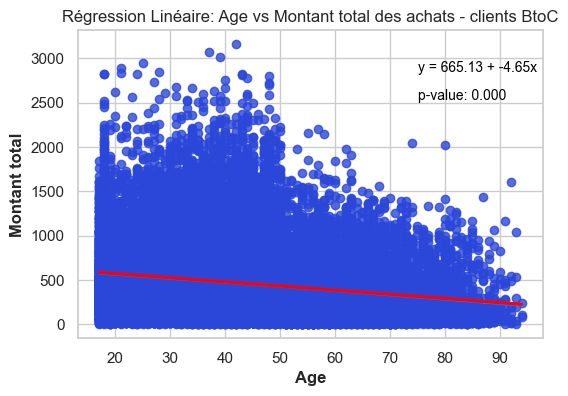

In [169]:
# Extraire les coefficients
coefficients = results_1_filtered.params
intercept = coefficients[0]  # Intercept
slope = coefficients[1]      # Pente
print(f"Intercept : {intercept}, Slope : {slope}")

# Extraire la p-value pour la pente
p_value = results_1_filtered.pvalues[1]

# Visualisation avec la droite de régression et la p-value
plt.figure(figsize=(6, 4))
sns.regplot(x='age_client', y='price', color='#2B47D9', data=analyse_2_filtered, line_kws={'color': 'red'})
plt.xlabel('Age')
plt.ylabel('Montant total')
plt.title('Régression Linéaire: Age vs Montant total des achats - clients BtoC')

# Ajouter la p-value et l'équation de la droite de régression sur le graphique
equation_text = f'y = {intercept:.2f} + {slope:.2f}x'

# Affichage de l'équation de la droite de régression (au-dessus de la p-value)
plt.text(x=analyse_2_filtered['age_client'].max() * 0.8, 
         y=analyse_2_filtered['price'].max() * 0.9, 
         s=equation_text, fontsize=10, color='black')

# Affichage de la p-value
plt.text(x=analyse_2_filtered['age_client'].max() * 0.8, 
         y=analyse_2_filtered['price'].max() * 0.8, 
         s=f'p-value: {p_value:.3f}', fontsize=10, color='black')

# Afficher le graphique
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.3 - Lien entre l'âge des clients et la fréquence d’achat</h3>
</div>

Pour une analyse granulaire, tenant compte de la fréquence d'achat par client et par âge.

Regrouper chaque client individuellement, en tenant compte de leur âge, puis compter le nombre de sessions pour chaque client. Cela permet d'observer la fréquence d'achat par client et par âge.

In [281]:
analyse_3 = df_ventes.groupby(['client_id','age_client', 'annee_achat']).agg({'session_id':'count'}).reset_index()
analyse_3.head()

client_id  age_client  annee_achat  session_id
0       c_1          66         2021          23
1       c_1          67         2022          18
2       c_1          68         2023           2
3      c_10          65         2021          28
4      c_10          66         2022          25

Afficher le nuage de points

Text(0.5, 1.0, "Fréquence d'achat par âges")

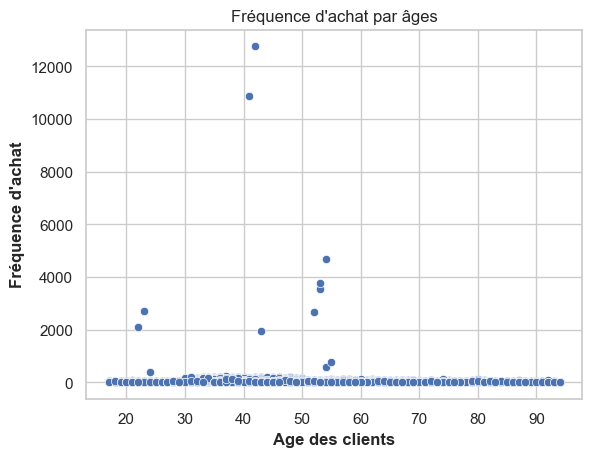

In [282]:
analyse_3 = analyse_3.reset_index()

sns.scatterplot(analyse_3, x='age_client', y='session_id')
plt.ylabel('Fréquence d\'achat')
plt.xlabel('Age des clients')
plt.title('Fréquence d\'achat par âges')

In [283]:
# Calcul de la corrélation de Pearson avec scipy
# Réinitialiser l'index pour pouvoir accéder aux colonnes groupées

x = analyse_3['age_client']  
y = analyse_3['session_id']  

correlation_coefficient = st.pearsonr(x, y)
print(f"Corrélation de Pearson : {correlation_coefficient}")

Corrélation de Pearson : PearsonRResult(statistic=-0.0010805934458584263, pvalue=0.8665380291094233)


Les clients BtoB représentent les frequences d'achats les plus importantes.

Il convient de filtrer le jeu de données afin de retrouver que les clients BtoC.

In [284]:
# Filtrer les lignes de l'analyse_3 en excluant celles dont les client_id sont dans clients_btob

analyse_3_filtered = analyse_3[~analyse_3['client_id'].isin(ca_par_clients_btob['client_id'])]

# Afficher le DataFrame filtré
analyse_3_filtered.head()


index client_id  age_client  annee_achat  session_id
0      0       c_1          66         2021          23
1      1       c_1          67         2022          18
2      2       c_1          68         2023           2
3      3      c_10          65         2021          28
4      4      c_10          66         2022          25

Text(0.5, 1.0, "Fréquence d'achat par âges")

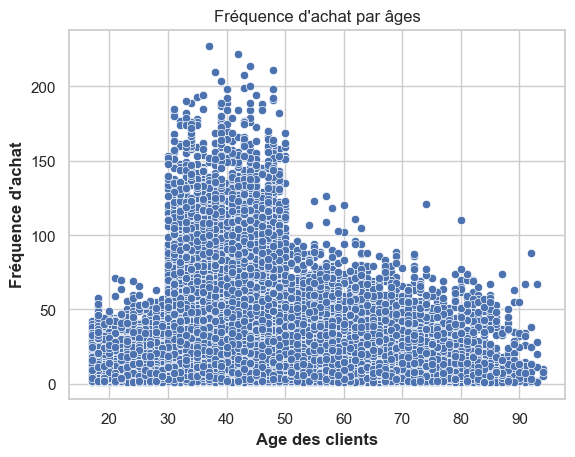

In [285]:
# Afficher le graphique
sns.scatterplot(analyse_3_filtered, x='age_client', y='session_id')
plt.ylabel('Fréquence d\'achat')
plt.xlabel('Age des clients')
plt.title('Fréquence d\'achat par âges')

In [286]:
# Calcul de la corrélation de Pearson avec scipy
# Réinitialiser l'index pour pouvoir accéder aux colonnes groupées
analyse_3 = analyse_3_filtered.reset_index()

x = analyse_3_filtered['age_client']  
y = analyse_3_filtered['session_id']  

correlation_coefficient_2 = st.pearsonr(x, y)
print(f"Corrélation de Pearson : {correlation_coefficient_2}")

Corrélation de Pearson : PearsonRResult(statistic=-0.00287056433785984, pvalue=0.6553590124905763)


Une valeur de -0.003 est très proche de 0, ce qui indique qu'il n'y a pratiquement aucune corrélation linéaire entre l'âge des clients et la fréquence d'achat.

La p-value permet de tester l'hypothèse nulle selon laquelle il n'existe aucune **corrélation linéaire** entre les deux variables.

La p-value de 0.65 est beaucoup plus élevée que le seuil standard de 0.05. Cela signifie qu'il n'est pas possible de rejeter l'hypothèse nulle. Autrement dit, la corrélation observée n'est pas statistiquement significative.

Cependant, absence de relation linéaire ne signifie pas pour autant qu'il n'y a pas d'effet ou de relation entre l'âge et la fréquence d'achat.

Des investigations complémentaires sont à mener: ANOVA ou régression linéaire à l'aide de la variable catégorielle tranche_age.

In [287]:
# Exporter les données au format xlsx
analyse_3.to_excel('analyse_3.xlsx')

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.4 - Lien entre l'âge des clients et la taille du panier moyen</h3>
</div>

In [176]:
analyse_4 = df_ventes.groupby(['client_id','age_client', 'annee_achat']).agg({'price': 'mean','session_id':'count'}).reset_index()
analyse_4.head()

client_id  age_client  annee_achat      price  session_id
0       c_1          66         2021  15.891304          23
1       c_1          67         2022  12.179444          18
2       c_1          68         2023  22.145000           2
3      c_10          65         2021  20.935000          28
4      c_10          66         2022  24.117200          25

In [177]:
# Classer par ordre décroissant du panier moyen
analyse_4.sort_values(by='price', ascending=False)

client_id  age_client  annee_achat   price  session_id
23810     c_876          25         2023  247.22           1
16891    c_6420          30         2023  230.04           1
20780    c_7661          28         2023  230.04           1
23756    c_8617          27         2023  230.04           1
5278      c_269          27         2023  230.04           2
...         ...         ...          ...     ...         ...
1519     c_1485          64         2023    3.28           1
14734    c_5729          52         2023    3.24           1
23341    c_8483          42         2023    2.99           1
184      c_1056          28         2023    2.95           1
1289     c_1411          40         2023    2.64           1

[24190 rows x 5 columns]

Text(0.5, 1.0, 'Panier moyen par âges')

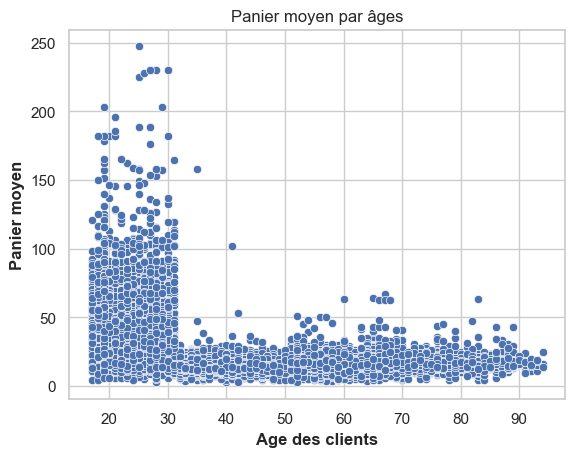

In [178]:
# Afficher le nuage de points
sns.scatterplot(analyse_4, x='age_client', y='price')
plt.ylabel('Panier moyen')
plt.xlabel('Age des clients')
plt.title('Panier moyen par âges')

In [179]:
# Filtrer les lignes de analyse_4 en excluant celles dont les client_id sont dans clients_btob

analyse_4_filtered = analyse_4[~analyse_4['client_id'].isin(ca_par_clients_btob['client_id'])]

# Afficher le DataFrame filtré
analyse_4_filtered.head()


client_id  age_client  annee_achat      price  session_id
0       c_1          66         2021  15.891304          23
1       c_1          67         2022  12.179444          18
2       c_1          68         2023  22.145000           2
3      c_10          65         2021  20.935000          28
4      c_10          66         2022  24.117200          25

Text(0.5, 1.0, 'Panier moyen par âges')

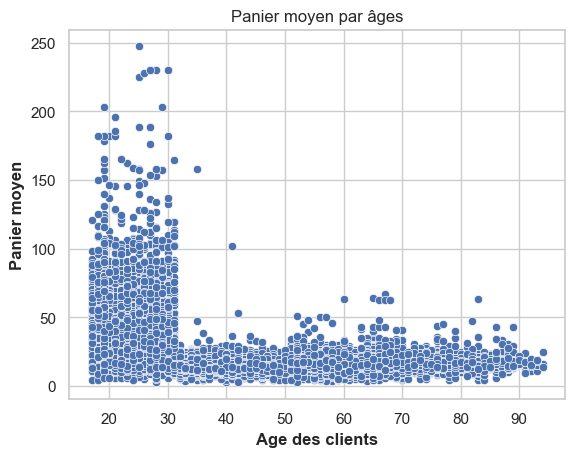

In [180]:
# Afficher le graphique nuage de points
sns.scatterplot(analyse_4_filtered, x='age_client', y='price')
plt.ylabel('Panier moyen')
plt.xlabel('Age des clients')
plt.title('Panier moyen par âges')

A priori, les 4 clients BtoB n'influencent pas l'analyse

In [181]:
x = analyse_4['age_client']  
y = analyse_4['price'] 

# La fonction pearsonr retourne deux valeurs : coefficient de corrélation et p-value
correlation_coefficient_4, p_valeur4 = st.pearsonr(x, y)

# Afficher les résultats
print(f"Corrélation de Pearson : {correlation_coefficient_4}")
print(f"P-value : {p_valeur4}")

# Conclusion selon la p-value
if p_valeur4 < 0.05:
    print("La corrélation est significative (p-value < 0.05). Il existe une corrélation entre l'âge du client et le panier moyen.")
else:
    print("La corrélation n'est pas significative (p-value >= 0.05). Il n'y a pas de corrélation statistiquement significative entre l'âge du client et le panier moyen.")

Corrélation de Pearson : -0.4522615919002697
P-value : 0.0
La corrélation est significative (p-value < 0.05). Il existe une corrélation entre l'âge du client et le panier moyen.


In [182]:
# Exporter les données au format xlsx
analyse_4.to_excel('panier_moyen_age.xlsx')

In [183]:
# Effectuer une regression linéaire simple (MCO)
import statsmodels.api as sm

x = analyse_4['age_client']  # Variable indépendante (age_client)
y = analyse_4['price']  # Variable dépendante (price)

# Ajouter une constante (pour l'intercept) à la variable X
x = sm.add_constant(x)

# Ajuster le modèle de régression linéaire
reg_lin_2 = sm.OLS(y, x)  
results_2 = reg_lin_2.fit()

# Afficher le résumé du modèle
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     6220.
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:05:10   Log-Likelihood:            -1.0012e+05
No. Observations:               24190   AIC:                         2.002e+05
Df Residuals:                   24188   BIC:                         2.003e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.0735      0.273    154.264      0.0

In [184]:
# Récupérer les coefficients
coefficients = results_2.params
intercept = coefficients.iloc[0]  # Constante (β0) avec .iloc
t_value = results_2.tvalues[1] 
slope = coefficients.iloc[1]       # Pente (β1) avec .iloc
p_value = results_2.pvalues.iloc[1]  # p-value associée à l'age_client avec .iloc
r_squared = results_2.rsquared

# Créer un tableau avec les résultats
table = [
    ['Intercept', intercept],
    ['Statistique t du coefficient age_client', t_value],
    ['Pente', slope],
    ['P-value', p_value],
    ['R2', r_squared]
]

# Afficher les résultats avec tabulate
print(tabulate(table, headers=['Metric', 'Value'], tablefmt='github'))

| Metric                                  |      Value |
|-----------------------------------------|------------|
| Intercept                               |  42.0735   |
| Statistique t du coefficient age_client | -78.8643   |
| Pente                                   |  -0.457249 |
| P-value                                 |   0        |
| R2                                      |   0.204541 |


In [185]:
# Conclusion selon la p-valeur
if p_value < 0.05:
    print("\nIl existe une association significative entre 'age et 'Panier moyen' (p < 0.05).")
else:
    print("\nAucune association significative entre 'age et 'Panier moyen' (p >= 0.05).")


Il existe une association significative entre 'age et 'Panier moyen' (p < 0.05).


Intercept : 42.073523586413636, Slope : -0.45724888764149035


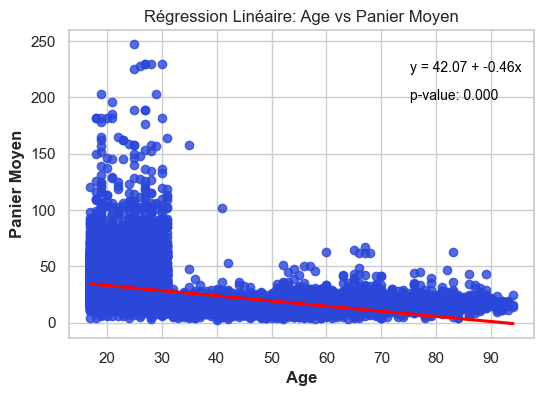

In [186]:
# Extraire les coefficients
coefficients = results_2.params
intercept = coefficients[0]  # Intercept
slope = coefficients[1]      # Pente
print(f"Intercept : {intercept}, Slope : {slope}")

# Extraire la p-value pour la pente
p_value = results_2.pvalues[1]

# Visualisation avec la droite de régression et la p-value
plt.figure(figsize=(6, 4))
sns.regplot(x='age_client', y='price', color='#2B47D9', data=analyse_4, line_kws={'color': 'red'})
plt.xlabel('Age')
plt.ylabel('Panier Moyen')
plt.title('Régression Linéaire: Age vs Panier Moyen')

# Ajouter la p-value et l'équation de la droite de régression sur le graphique
equation_text = f'y = {intercept:.2f} + {slope:.2f}x'

# Affichage de l'équation de la droite de régression (au-dessus de la p-value)
plt.text(x=analyse_4['age_client'].max() * 0.8, 
         y=analyse_4['price'].max() * 0.9, 
         s=equation_text, fontsize=10, color='black')

# Affichage de la p-value
plt.text(x=analyse_4['age_client'].max() * 0.8, 
         y=analyse_4['price'].max() * 0.8, 
         s=f'p-value: {p_value:.3f}', fontsize=10, color='black')

# Afficher le graphique
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.5 - Lien entre l'âge des clients et la catégorie des livres achetés</h3>
</div>

On veut connaître l ’effet des achats des trois catégories de livres sur l'age des clients.

In [187]:
# Agreger les données de catégories avec l'âge des clients
df_anova = df_ventes.groupby('categ').agg(
    nb_obs = ('age_client', 'count'),
    age_moy = ('age_client', 'mean'),
    ecart_type = ('age_client', 'std')
)

# Transformer le résultat en DataFrame
df_anova = df_anova.reset_index()
df_anova

categ  nb_obs    age_moy  ecart_type
0     0  415459  43.549250   11.225998
1     1  235592  47.186224   15.551439
2     2   36483  25.634761    9.814535

In [188]:
# Exporter les données au format xlsx
df_anova.to_excel('anova.xlsx')

Attention : 25366 valeurs aberrantes détectées et supprimées.


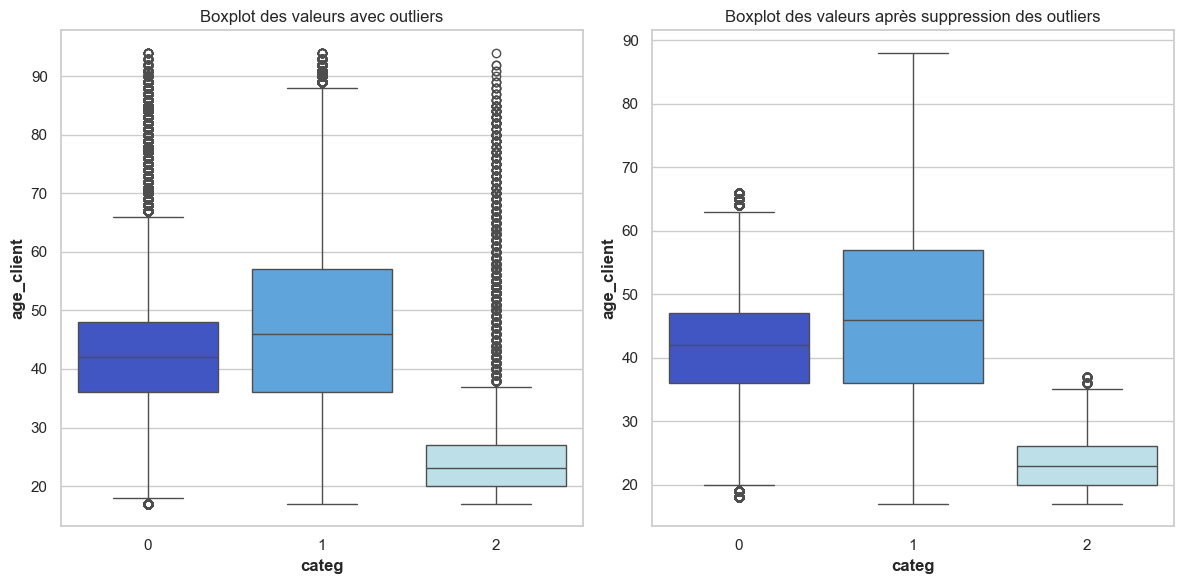

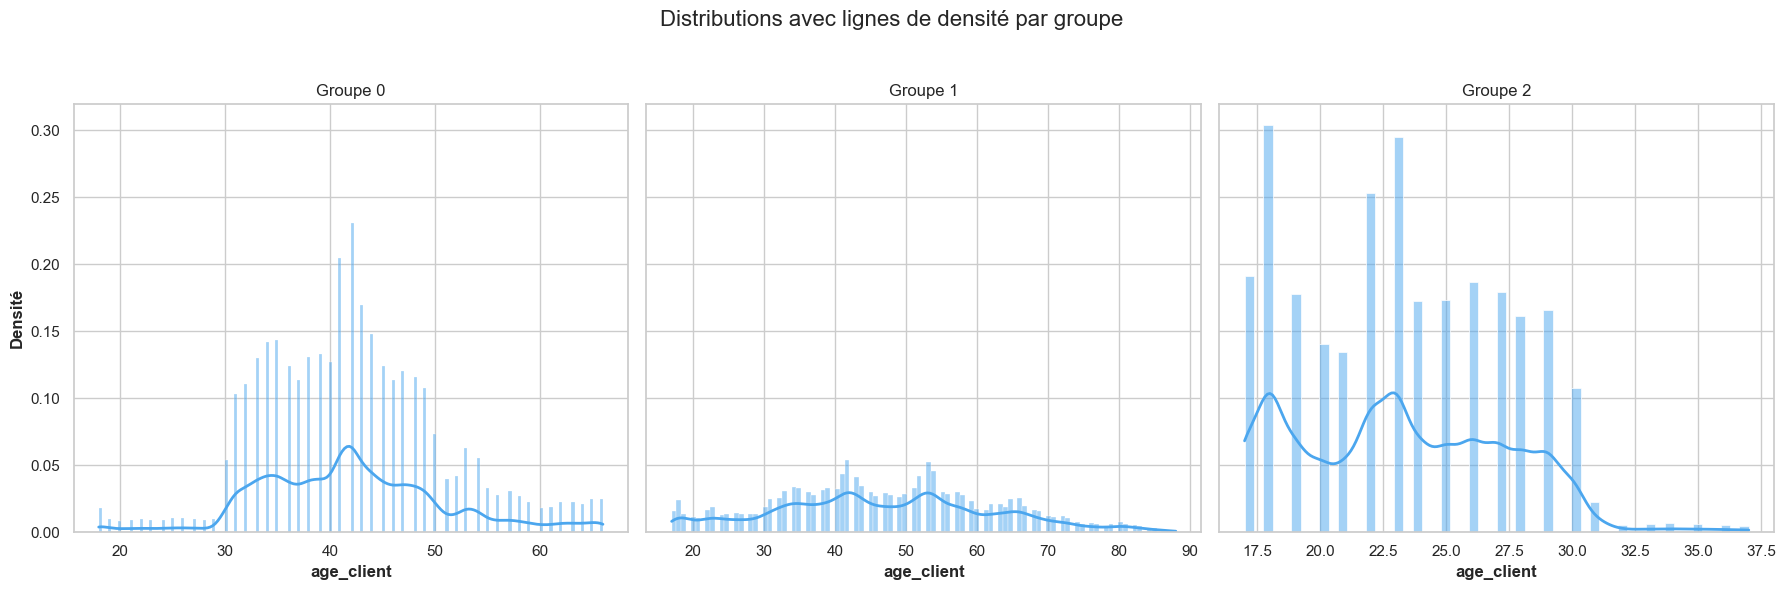


Résultats du test Jarque-Bera pour le groupe 0 :
| Métrique                   | Valeur                                              |
|----------------------------|-----------------------------------------------------|
| Statistique de Jarque-Bera | 9954.827056163087                                   |
| P-valeur                   | 0.0                                                 |
| Conclusion                 | Les résidus ne suivent pas une distribution normale |

Résultats du test Jarque-Bera pour le groupe 1 :
| Métrique                   | Valeur                                              |
|----------------------------|-----------------------------------------------------|
| Statistique de Jarque-Bera | 3259.7140442732893                                  |
| P-valeur                   | 0.0                                                 |
| Conclusion                 | Les résidus ne suivent pas une distribution normale |

Résultats du test Jarque-Bera pour le groupe 2 :


In [189]:
anova_type_2(df_ventes, 'categ', 'age_client', remove_outliers=True)

Effectuer un test non paramétrique : Kruskal - wallis

Lorsque l'on effectue ce test, il n'est généralement pas nécessaire de supprimer les outliers, car ce test est non paramétrique et ne repose pas sur des hypothèses strictes de normalité des données ou d'homogénéité des variances. Cela le rend plus robuste aux valeurs aberrantes (outliers)

Kruskal-Wallis: Stat=78410.39360495954, p-value=0.0
Eta-carré pour Kruskal-Wallis : 0.1140430984475793
Test Kruskal-Wallis significatif, exécution des tests post-hoc de Dunn
Test post-hoc de Dunn :
     0    1    2
0  1.0  0.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  1.0


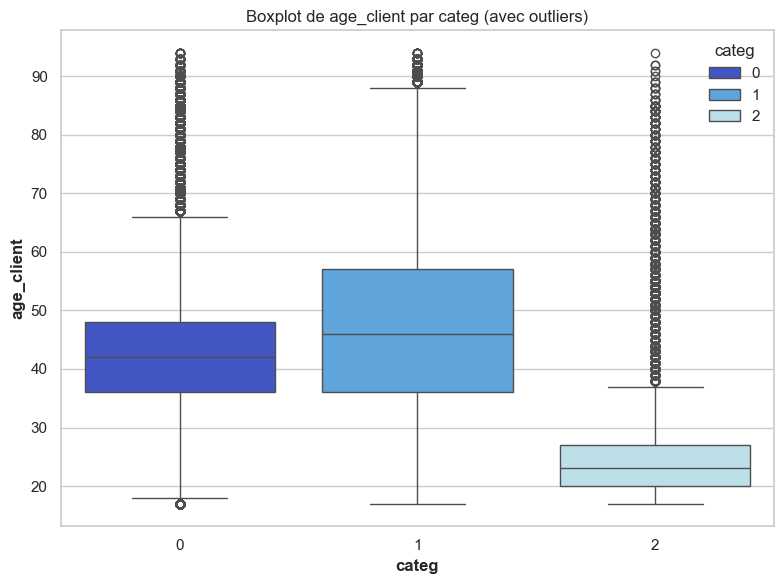

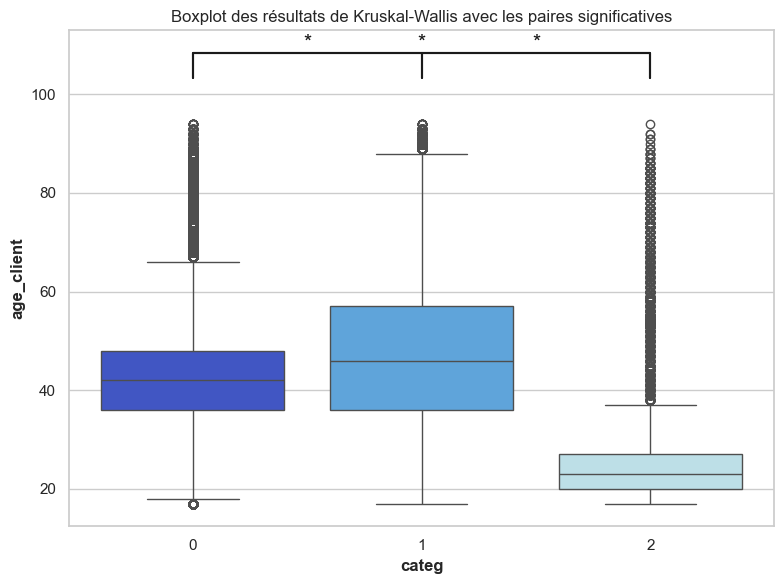

Conclusion : Significatif

Synthèse des résultats :
| Test                 | Statistique   | p-value   | Conclusion                 |
|----------------------|---------------|-----------|----------------------------|
| Kruskal-Wallis       | 78410.394     | 0.00000   | Différences significatives |
| Eta-carré            | 0.114         | -         | Taille de l'effet          |
| Dunn post-hoc 0 vs 1 | -             | 0.00000   | Significatif               |
| Dunn post-hoc 0 vs 2 | -             | 0.00000   | Significatif               |
| Dunn post-hoc 1 vs 2 | -             | 0.00000   | Significatif               |


'Significatif'

In [190]:
# Effectuer le test non paramétrique de kruskal-wallis et un test post hoc
kruskal_wallis_test(df_ventes, 'categ', 'age_client', alpha=0.05)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6 - Analyse des profils clients</h3>
</div>

<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6.1 - Répartition du chiffre d'affaires</h4>

In [191]:
# Grouper par client pour obtenir le chiffre d'affaires total par client
df_ca_client = df_ventes.groupby('client_id')['price'].sum().reset_index()

# Trier les clients par chiffre d'affaires croissant
df_ca_client = df_ca_client.sort_values(by='price')

# Calcul du chiffre d'affaires cumulé et proportion cumulée des clients
df_ca_client['ca_cumule'] = df_ca_client['price'].cumsum() / df_ca_client['price'].sum()
df_ca_client['proportion_clients'] = np.arange(1, len(df_ca_client) + 1) / len(df_ca_client)


In [192]:
# Tracer la courbe de Lorenz
plt.figure(figsize=(8, 6))
plt.plot(df_ca_client['proportion_clients'], df_ca_client['ca_cumule'], label='Courbe de Lorenz', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='')  # La ligne de parfaite égalité
plt.xlabel('Proportion des clients')
plt.ylabel('Proportion du chiffre d\'affaires cumulé')
plt.title('Courbe de Lorenz du chiffre d\'affaires entre les clients')
plt.legend()
plt.grid(True)
plt.show()


In [193]:
# Calcul de l'indice de Gini
lorenz_area = np.trapz(df_ca_client['ca_cumule'], df_ca_client['proportion_clients'])  # Aire sous la courbe de Lorenz
gini_index = 1 - 2 * lorenz_area
print(f"Indice de Gini : {gini_index:.4f}")

Indice de Gini : 0.4419


L'indice de Gini de 0.4419 signifie qu'il existe une inégalité modérée dans la répartition du chiffre d'affaires entre les clients.  certains clients contribuent plus que d'autres au chiffre d'affaires global, mais l'inégalité n'est pas extrêmement forte.

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6.2 - Analyse des nouveaux clients</h4>
</div>

In [194]:
# Extraire les heures, minutes et secondes
df_ventes['heure'] = df_ventes['date'].dt.hour
df_ventes['minute'] = df_ventes['date'].dt.minute
df_ventes['seconde'] = df_ventes['date'].dt.second

# Fonction pour déterminer la période de la journée
def determiner_periode(heure):
    if 23 <= heure or heure < 6:
        return 'nuit'
    elif 6 <= heure < 12:
        return 'matin'
    elif 12 <= heure < 14:
        return 'midi'
    elif 14 <= heure < 18:
        return 'apres-midi'
    else:
        return 'soir'

# Ajouter la colonne période de la journée
df_ventes['periode_journee'] = df_ventes['heure'].apply(determiner_periode)

# Afficher les premières lignes du DataFrame pour vérifier
df_ventes.head()


client_id sex      birth id_prod  price categ                       date  \
0       c_1   m 1955-01-01  0_1090  13.78     0 2021-12-19 02:44:12.827475   
1       c_1   m 1955-01-01  0_1186  12.30     0 2021-07-25 12:17:34.446678   
2       c_1   m 1955-01-01  0_1186  12.30     0 2022-08-25 12:17:34.446678   
3       c_1   m 1955-01-01  0_1378  13.96     0 2021-08-23 16:56:15.401655   
4       c_1   m 1955-01-01  0_1378  13.96     0 2022-07-23 16:56:15.401655   

  session_id date_achat  annee_achat mois_achat               annee_naissance  \
0   s_136532 2021-12-19         2021    2021-12 1970-01-01 00:00:00.000001955   
1    s_66947 2021-07-25         2021    2021-07 1970-01-01 00:00:00.000001955   
2   s_258252 2022-08-25         2022    2022-08 1970-01-01 00:00:00.000001955   
3    s_79696 2021-08-23         2021    2021-08 1970-01-01 00:00:00.000001955   
4   s_242617 2022-07-23         2022    2022-07 1970-01-01 00:00:00.000001955   

   age_client tranche_age  heure  minute  seconde periode_journee  
0          66       60-69      2      44       12            nuit  
1          66       60-69     12      17       34            midi  
2          67       60-69     12      17       34            midi  
3          66       60-69     16      56       15      apres-midi  
4          67       60-69     16      56       15      apres-midi

In [195]:
# Extraire le mois
df_ventes['mois'] = df_ventes['date'].dt.month

# Dictionnaire pour mapper les chiffres aux noms des mois
mois_mapping = {
    '1': 'janvier', '2': 'février', '3': 'mars', '4': 'avril',
    '5': 'mai', '6': 'juin', '7': 'juillet', '8': 'août',
    '9': 'septembre', '10': 'octobre', '11': 'novembre', '12': 'décembre'
}

# Ajouter la colonne 'nom_mois' au dataframe
df_ventes['nom_mois'] = df_ventes['mois'].astype(str).map(mois_mapping)

# Afficher les premières lignes pour vérifier
df_ventes.head()


client_id sex      birth id_prod  price categ                       date  \
0       c_1   m 1955-01-01  0_1090  13.78     0 2021-12-19 02:44:12.827475   
1       c_1   m 1955-01-01  0_1186  12.30     0 2021-07-25 12:17:34.446678   
2       c_1   m 1955-01-01  0_1186  12.30     0 2022-08-25 12:17:34.446678   
3       c_1   m 1955-01-01  0_1378  13.96     0 2021-08-23 16:56:15.401655   
4       c_1   m 1955-01-01  0_1378  13.96     0 2022-07-23 16:56:15.401655   

  session_id date_achat  annee_achat mois_achat               annee_naissance  \
0   s_136532 2021-12-19         2021    2021-12 1970-01-01 00:00:00.000001955   
1    s_66947 2021-07-25         2021    2021-07 1970-01-01 00:00:00.000001955   
2   s_258252 2022-08-25         2022    2022-08 1970-01-01 00:00:00.000001955   
3    s_79696 2021-08-23         2021    2021-08 1970-01-01 00:00:00.000001955   
4   s_242617 2022-07-23         2022    2022-07 1970-01-01 00:00:00.000001955   

   age_client tranche_age  heure  minute  seconde periode_journee  mois  \
0          66       60-69      2      44       12            nuit    12   
1          66       60-69     12      17       34            midi     7   
2          67       60-69     12      17       34            midi     8   
3          66       60-69     16      56       15      apres-midi     8   
4          67       60-69     16      56       15      apres-midi     7   

   nom_mois  
0  décembre  
1   juillet  
2      août  
3      août  
4   juillet

In [196]:
# Statistiques des clients en 2021
clients_2021 = df_ventes[df_ventes['date_achat'].dt.year == 2021]

# Aggrégation par catégorie
resultat_2021 = clients_2021.groupby('categ').agg(
    nbre_clients=('client_id', 'nunique'),
    nbre_transactions=('session_id', 'count'),
    age_moyen=('age_client', 'mean'),
    ca_annuel=('price', 'sum'),
    panier_moyen=('price', 'mean'),
    sex_frequent=('sex', lambda x: x.mode()[0]),
    top_produit=('id_prod', lambda x: x.mode()[0]), # Produit le plus vendu
    top_periode = ('periode_journee', lambda x: x.mode()[0]),
    flop_mois = ('nom_mois', lambda x: x.value_counts().idxmin()),
    top_mois = ('nom_mois', lambda x: x.mode()[0]),
    flop_periode =('periode_journee', lambda x: x.value_counts().idxmin()),  # Période de la journée la plus fréquente
    top_heure =('heure', lambda x: x.mode()[0]),
    flop_heure=('heure', lambda x: x.value_counts().idxmin())   # Heure la plus fréquente  # Pour obtenir le sexe le plus fréquent
).reset_index()

# Afficher le résultat
print('Statistiques des clients entre mars et décembre 2021')
resultat_2021

Statistiques des clients entre mars et décembre 2021


categ  nbre_clients  nbre_transactions  age_moyen   ca_annuel  panier_moyen  \
0     0          7749             176984  42.913874  1883020.45     10.639495   
1     1          8387              95139  46.260041  1951930.27     20.516615   
2     2          3192              14548  25.012029  1109810.26     76.286105   

  sex_frequent top_produit top_periode flop_mois   top_mois flop_periode  \
0            m      0_1422        nuit   juillet  septembre         midi   
1            f       1_369        nuit     avril   novembre         midi   
2            m       2_135        nuit  décembre    juillet         midi   

   top_heure  flop_heure  
0          9           8  
1         23           0  
2          7          15

In [197]:
# Filtrer les clients ayant fait des achats en 2021
clients_2021 = df_ventes[df_ventes['annee_achat'] == 2021]['client_id'].unique()

# Filtrer les nouveaux clients en 2022 (ceux qui ne sont pas dans la liste des clients de 2021)
nouveaux_clients_2022 = df_ventes[(df_ventes['annee_achat'] == 2022) & (~df_ventes['client_id'].isin(clients_2021))]

# Fusionner pour obtenir les informations des nouveaux clients
df_nouveaux_clients_2022 = df_ventes.merge(nouveaux_clients_2022[['client_id']], on='client_id')

# Agrégation par catégorie pour les nouveaux clients en 2022
resultats_nouveaux_clients = df_nouveaux_clients_2022.groupby('categ').agg(
    nbre_nouveaux_clients=('client_id', 'nunique'),  # Nombre de nouveaux clients
    nbre_transactions=('session_id', 'count'),       # Nombre de transactions
    age_moyen=('age_client', 'mean'),                # Age moyen
    ca_annuel=('price', 'sum'),                      # CA annuel
    panier_moyen=('price', 'mean'),                  # Panier moyen
    sex_frequent=('sex', lambda x: x.mode()[0]),     # Sexe le plus fréquent
    top_produit=('id_prod', lambda x: x.mode()[0]),  # Produit le plus fréquent
    top_mois=('nom_mois', lambda x: x.mode()[0]),    # Mois le plus fréquent
    flop_mois=('nom_mois', lambda x: x.value_counts().idxmin()),  # Mois le moins fréquent
    top_periode=('periode_journee', lambda x: x.mode()[0]),       # Période de la journée la plus fréquente
    flop_periode=('periode_journee', lambda x: x.value_counts().idxmin()),  # Période de la journée la moins fréquente
    top_heure=('heure', lambda x: x.mode()[0]),  # Heure la plus fréquente
    flop_heure=('heure', lambda x: x.value_counts().idxmin())  # Heure la moins fréquente
).reset_index()

# Afficher le résultat
print('Statistiques des nouveaux clients en 2022')
resultats_nouveaux_clients


Statistiques des nouveaux clients en 2022


categ  nbre_nouveaux_clients  nbre_transactions  age_moyen  ca_annuel  \
0     0                      6                417  35.326139    4058.66   
1     1                     13                584  29.835616   10628.94   
2     2                      9                630  24.636508   47340.32   

   panier_moyen sex_frequent top_produit top_mois flop_mois top_periode  \
0      9.732998            m      0_1464  février  novembre        nuit   
1     18.200240            f       1_237  janvier   juillet        soir   
2     75.143365            f       2_102  février     avril        soir   

  flop_periode  top_heure  flop_heure  
0         soir          9           0  
1   apres-midi         18          17  
2        matin         17           4

On constate un problème en matière de développement commercial et plus précisement dans la conquête de nouveaux clients.
On observe également un panier moyen légèrement inférieur des nouveaux clients par rapport au panier moyen global des clients en 2022. 
Cependant, ces nouveaux clients sont aussi plus jeunes et cela concerne les achats au sein de chaque catégorie.

In [198]:
# Exporter les données au format xlsx
resultats_nouveaux_clients.to_excel('stats_nouveaux_clients_2022.xlsx')

In [199]:
clients_2022 = df_ventes[df_ventes['date_achat'].dt.year == 2022]

# Aggrégation par catégorie
resultat_2022 = clients_2022.groupby('categ').agg(
    nbre_clients=('client_id', 'nunique'),
    nbre_transactions=('session_id', 'count'),
    age_moyen=('age_client', 'mean'),
    ca_annuel=('price', 'sum'),
    panier_moyen=('price', 'mean'),
    sex_frequent=('sex', lambda x: x.mode()[0]),
    top_produit=('id_prod', lambda x: x.mode()[0]), # Produit le plus vendu
    top_periode = ('periode_journee', lambda x: x.mode()[0]),
    flop_mois = ('nom_mois', lambda x: x.value_counts().idxmin()),
    top_mois = ('nom_mois', lambda x: x.mode()[0]),
    flop_periode =('periode_journee', lambda x: x.value_counts().idxmin()),  # Période de la journée la plus fréquente
    top_heure =('heure', lambda x: x.mode()[0]),
    flop_heure=('heure', lambda x: x.value_counts().idxmin())   # Heure la plus fréquente  # Pour obtenir le sexe le plus fréquent
).reset_index()

# Afficher le résultat
print('Statistiques des clients en 2022')
resultat_2022

Statistiques des clients en 2022


categ  nbre_clients  nbre_transactions  age_moyen   ca_annuel  panier_moyen  \
0     0          7464             206152  43.885987  2192970.46     10.637639   
1     1          8220             121412  47.685319  2485275.19     20.469766   
2     2          2975              18816  25.911724  1430436.16     76.022330   

  sex_frequent top_produit top_periode flop_mois top_mois flop_periode  \
0            m      0_1431        nuit   janvier      mai         midi   
1            f       1_369        nuit   juillet  janvier         midi   
2            m       2_102        nuit   janvier  février         midi   

   top_heure  flop_heure  
0          9           4  
1         12           0  
2         23           8

In [200]:
profil_clients_2022 = df_ventes[df_ventes['date_achat'].dt.year == 2022]

# Aggrégation par catégorie
profil_2022 = profil_clients_2022.groupby('sex').agg(
    nbre_clients=('client_id', 'nunique'),
    nbre_transactions=('session_id', 'count'),
    age_moyen=('age_client', 'mean'),
    ca_annuel=('price', 'sum'),
    panier_moyen=('price', 'mean'),
    top_categ =('categ', lambda x: x.mode()[0]), # Produit le plus vendu
    top_produit=('id_prod', lambda x: x.mode()[0]), # Produit le plus vendu
    top_periode = ('periode_journee', lambda x: x.mode()[0]),
    flop_mois = ('nom_mois', lambda x: x.value_counts().idxmin()),
    top_mois = ('nom_mois', lambda x: x.mode()[0]),
    flop_periode =('periode_journee', lambda x: x.value_counts().idxmin()),  # Période de la journée la plus fréquente
    top_heure =('heure', lambda x: x.mode()[0]),
    flop_heure=('heure', lambda x: x.value_counts().idxmin())   # Heure la plus fréquente  # Pour obtenir le sexe le plus fréquent
).reset_index()

# Afficher le résultat
print('Statistiques des clients en 2022')
profil_2022

Statistiques des clients en 2022


sex  nbre_clients  nbre_transactions  age_moyen   ca_annuel  panier_moyen  \
0   f          4442             172930  44.793003  3021043.17     17.469746   
1   m          4080             173450  43.691294  3087638.64     17.801318   

  top_categ top_produit top_periode flop_mois top_mois flop_periode  \
0         0       1_417        nuit     avril     mars         midi   
1         0       1_369        nuit     avril      mai         midi   

   top_heure  flop_heure  
0         23          15  
1          9          22

In [201]:
# Exporter les données au format xlsx
profil_2022.to_excel('profil_clients_2022.xlsx')

In [202]:
# Aggrégation par catégorie
CA_annuel = df_ventes.groupby('annee_achat').agg(
                    ca_annuel=('price', 'sum'),
                    panier_moyen=('price', 'mean')
)
CA_annuel

ca_annuel  panier_moyen
annee_achat                          
2021         4944760.98     17.248905
2022         6108681.81     17.635781
2023          974220.31     17.881180

Identifier les heures d'achats les plus performantes de chaque mois de l'année 2022

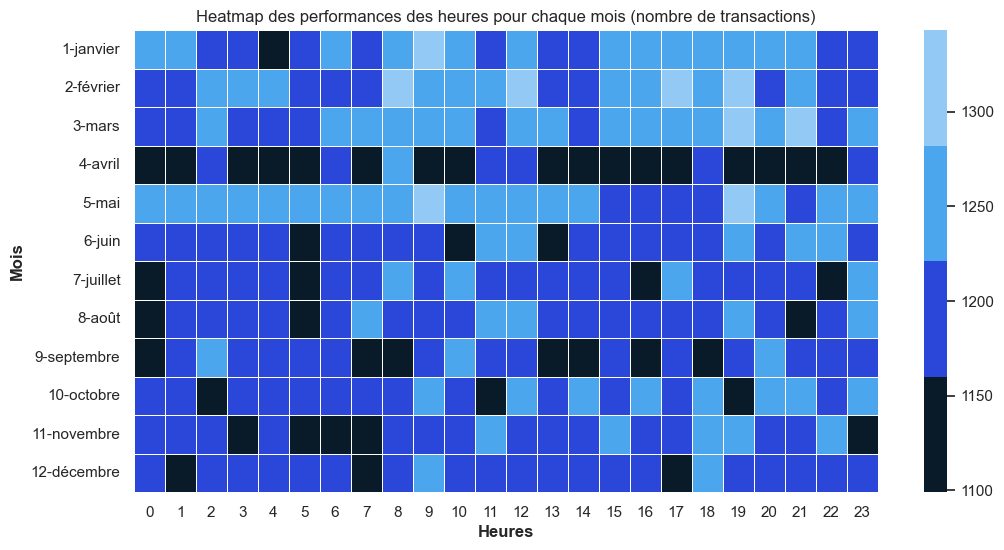

In [203]:
# Groupement des données par heure et par mois, et comptage des sessions
heatmap_data = profil_clients_2022.groupby(['mois','nom_mois', 'heure'])['session_id'].count().unstack()
heatmap_data_sorted = heatmap_data.sort_values('mois')  # Trier par le mois

# Définir une palette de couleurs personnalisée
custom_palette = ["#091A29", "#2B47D9", "#4BA6EE", "#93CAF5"]

# Tracer la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_sorted, cmap=custom_palette, annot=False, fmt='d', linewidths=0.5)

# Ajouter un titre et les labels
plt.title("Heatmap des performances des heures pour chaque mois (nombre de transactions)")
plt.xlabel("Heures")
plt.ylabel("Mois")
plt.show()

In [204]:
df_test = df_ventes.groupby(['client_id','id_prod','nom_mois', 'date','heure'])['session_id'].count().reset_index()

# Renommer la colonne de comptage pour plus de clarté
df_test = df_test.rename(columns={'session_id': 'nombre_session_id'})

# Afficher le DataFrame résultant
df_test

client_id id_prod  nom_mois                       date  heure  \
0            c_1  0_1090  décembre 2021-12-19 02:44:12.827475      2   
1            c_1  0_1186      août 2022-08-25 12:17:34.446678     12   
2            c_1  0_1186   juillet 2021-07-25 12:17:34.446678     12   
3            c_1  0_1378      août 2021-08-23 16:56:15.401655     16   
4            c_1  0_1378      août 2022-08-23 16:56:15.401655     16   
...          ...     ...       ...                        ...    ...   
687529     c_999   1_724   janvier 2022-01-19 09:10:14.900805      9   
687530     c_999   1_727   janvier 2023-01-21 17:40:50.856434     17   
687531     c_999   1_727   juillet 2022-07-21 17:40:50.856434     17   
687532     c_999   1_727       mai 2022-05-21 17:40:50.856434     17   
687533     c_999   1_727  novembre 2021-11-21 17:40:50.856434     17   

        nombre_session_id  
0                       1  
1                       1  
2                       1  
3                       1  
4                       1  
...                   ...  
687529                  1  
687530                  1  
687531                  1  
687532                  1  
687533                  1  

[687534 rows x 6 columns]

In [205]:
# Compte le nombre de 'session_id' par 'client_id', 'mois', 'nom_mois', et 'heure'
df_test = df_ventes.groupby(['client_id', 'mois', 'nom_mois','date', 'heure', 'id_prod'])['session_id'].count()

# Transformer en DataFrame
df_test = df_test.reset_index()

# Renommer la colonne de comptage pour plus de clarté
df_test = df_test.rename(columns={'session_id': 'count_session_id'})

# Afficher le DataFrame résultant
print(df_test)


       client_id  mois  nom_mois                       date  heure id_prod  \
0            c_1     1   janvier 2023-01-15 20:40:00.586010     20   1_713   
1            c_1     1   janvier 2023-01-15 20:46:25.222740     20   1_364   
2            c_1     2   février 2022-02-01 01:47:04.355850      1  0_1571   
3            c_1     3      mars 2022-03-01 01:47:04.355850      1  0_1571   
4            c_1     3      mars 2022-03-21 22:41:38.769525     22   0_513   
...          ...   ...       ...                        ...    ...     ...   
687529     c_999    11  novembre 2021-11-21 17:40:50.856434     17   1_727   
687530     c_999    11  novembre 2022-11-10 23:59:59.414026     23   1_676   
687531     c_999    11  novembre 2022-11-14 07:48:55.723362      7   1_381   
687532     c_999    12  décembre 2021-12-17 03:28:47.129085      3  0_1467   
687533     c_999    12  décembre 2022-12-13 15:31:15.583770     15   1_407   

        count_session_id  
0                      1  
1        

In [206]:
# Groupement des données par heure et par mois, et comptage des sessions
heatmap_data_2 = profil_clients_2022.groupby(['mois','nom_mois', 'periode_journee'])['session_id'].count().unstack()
heatmap_data_2_sorted = heatmap_data_2.sort_values('mois')  # Trier par le mois

# Définir une palette de couleurs personnalisée
#custom_palette = sns.dark_palette("#2B47D9", reverse=True, as_cmap=True)
custom_palette = ["#091A29", "#2B47D9", "#4BA6EE", "#93CAF5"]

# Tracer la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_2_sorted, cmap=custom_palette, annot=False, fmt='d', linewidths=0.5)

# Ajouter un titre et les labels
plt.title("Heatmap des performances des périodes de la journée pour chaque mois (nombre de sessions)")
plt.xlabel("Période journée")
plt.ylabel("Mois")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6.3 - Analyse des nouveaux produits</h4>
</div>

In [207]:
description_variables(df_ventes)

Description donnée(s):
Le jeu de données comporte: 687534 observation(s)
Le jeu de données comporte: 20 colonne(s)


type   total       n  unique  NaN  \
client_id                object  687534  687534    8600    0   
sex                    category  687534  687534       2    0   
mois                      int32  687534  687534      12    0   
periode_journee          object  687534  687534       5    0   
seconde                   int32  687534  687534      60    0   
minute                    int32  687534  687534      60    0   
heure                     int32  687534  687534      24    0   
tranche_age            category  687534  687534       8    0   
age_client                int32  687534  687534      78    0   
annee_naissance  datetime64[ns]  687534  687534      76    0   
mois_achat            period[M]  687534  687534      24    0   
annee_achat               int32  687534  687534       3    0   
date_achat       datetime64[ns]  687534  687534     730    0   
session_id               object  687534  687534  345505    0   
date             datetime64[ns]  687534  687534  687415    0   
categ                  category  687534  687534       3    0   
price                   float64  687534  687534    1442    0   
id_prod                  object  687534  687534    3265    0   
birth            datetime64[ns]  687534  687534      76    0   
nom_mois                 object  687534  687534      12    0   

                 pourcentage_(NaN)  
client_id                      0.0  
sex                            0.0  
mois                           0.0  
periode_journee                0.0  
seconde                        0.0  
minute                         0.0  
heure                          0.0  
tranche_age                    0.0  
age_client                     0.0  
annee_naissance                0.0  
mois_achat                     0.0  
annee_achat                    0.0  
date_achat                     0.0  
session_id                     0.0  
date                           0.0  
categ                          0.0  
price                          0.0  
id_prod                        0.0  
birth                          0.0  
nom_mois                       0.0

In [208]:
# Filtrer les produits achetés en 2021
produits_2021 = df_ventes.loc[df_ventes['annee_achat'] == 2021]['id_prod'].unique()

# Filtrer les nouveaux produits en 2022 (ceux qui ne sont pas dans la liste des produits de 2021)
nouveaux_produits_2022 = df_ventes.loc[(df_ventes['annee_achat'] == 2022) & (~df_ventes['id_prod'].isin(produits_2021))]

# Vérifier s'il y a des nouveaux produits en 2022
if nouveaux_produits_2022.empty:
    print("Aucun nouveau produit trouvé en 2022.")
else:
    # Fusionner pour obtenir les informations des nouveaux produits en 2022
    df_nouveaux_produits_2022 = df_ventes.loc[df_ventes['id_prod'].isin(nouveaux_produits_2022['id_prod'].unique())]

    # Agrégation par catégorie pour les nouveaux produits en 2022
    resultats_nouveaux_produits = df_nouveaux_produits_2022.groupby('categ').agg(
        nbre_nouveaux_produits=('id_prod', 'nunique'),   # Nombre de nouveaux produits
        nbre_clients = ('client_id', 'nunique'),         # Nombre de clients
        nbre_transactions=('session_id', 'count'),       # Nombre de transactions
        age_moyen=('age_client', 'mean'),                # Age moyen
        ca_annuel=('price', 'sum'),                      # CA annuel
        panier_moyen=('price', 'mean'),                  # Panier moyen
    ).reset_index()

    # Afficher le résultat
    print('Statistiques nouveaux produits en 2022')
    print(resultats_nouveaux_produits)

Statistiques nouveaux produits en 2022
  categ  nbre_nouveaux_produits  nbre_clients  nbre_transactions  age_moyen  \
0     0                       9            10                 24  42.750000   
1     1                       0             0                  0        NaN   
2     2                       3             5                 11  23.818182   

   ca_annuel  panier_moyen  
0     269.23     11.217917  
1       0.00           NaN  
2     932.09     84.735455  


On constate que 12 nouveautés, dans 2 catégories ont été proposées à la clientèle en 2022. 

Celles-ci ont été achetées par 15 clients et ont générés 1201,32€ de revenus en 2022.

De nouvelles offres qui ne rencontrent pas leur public cible, ce qui implique peu de ventes et donc peu de chiffre d'affaires.


In [209]:
# Exporter les données au format xlsx
resultats_nouveaux_produits.to_excel('stats_nouveaux_produits_2022.xlsx')

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.8 - Prévision du chiffre d'affaires par catégorie</h3>
</div>

<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.8.1 - Extraction des séries temporelles par catégorie</h4>

In [164]:
# Extraire les séries temporelles pour chaque catégorie
serie_categ_0 = df_ventes.loc[df_ventes['categ'] == 0, :]
serie_categ_1 = df_ventes.loc[df_ventes['categ'] == 1, :]
serie_categ_2 = df_ventes.loc[df_ventes['categ'] == 2, :]

Extraction des séries temporelles hebdomadaires

In [165]:
# Série temporelle des ventes hebdomadaires pour la catégorie 0
serie_hebdo_categ_0 = serie_categ_0[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='W')]).sum()

# Série temporelle des ventes hebdomadaires pour la catégorie 1
serie_hebdo_categ_1 = serie_categ_1[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='W')]).sum()

# Série temporelle des ventes hebdomadaires pour la catégorie 2
serie_hebdo_categ_2 = serie_categ_2[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='W')]).sum()

# S'assurer que l'index est de type datetime pour la catégorie 0
serie_hebdo_categ_0.index = pd.to_datetime(serie_hebdo_categ_0.index)

# S'assurer que l'index est de type datetime pour la catégorie 1
serie_hebdo_categ_1.index = pd.to_datetime(serie_hebdo_categ_1.index)

# S'assurer que l'index est de type datetime pour la catégorie 2
serie_hebdo_categ_2.index = pd.to_datetime(serie_hebdo_categ_2.index)

# Convertir en TimeSeries pour Darts pour la catégorie 0
serie_hebdo_categ_0_ts = TimeSeries.from_dataframe(serie_hebdo_categ_0 , value_cols='price')

# Convertir en TimeSeries pour Darts pour la catégorie 1
serie_hebdo_categ_1_ts = TimeSeries.from_dataframe(serie_hebdo_categ_1 , value_cols='price')

# Convertir en TimeSeries pour Darts pour la catégorie 2
serie_hebdo_categ_2_ts = TimeSeries.from_dataframe(serie_hebdo_categ_2 , value_cols='price')

Extraction des séries temporelles mensuelles

In [166]:
# Série temporelle des ventes mensuelle pour la catégorie 0
serie_mensuelle_categ_0 = serie_categ_0[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='ME')]).sum()

# Série temporelle des ventes hebdomadaires pour la catégorie 1
serie_mensuelle_categ_1 = serie_categ_1[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='ME')]).sum()

# Série temporelle des ventes hebdomadaires pour la catégorie 2
serie_mensuelle_categ_2 = serie_categ_2[['date_achat', 'price']].groupby([pd.Grouper(key='date_achat', freq='ME')]).sum()

# S'assurer que l'index est de type datetime pour la catégorie 0
serie_mensuelle_categ_0.index = pd.to_datetime(serie_mensuelle_categ_0.index)

# S'assurer que l'index est de type datetime pour la catégorie 1
serie_mensuelle_categ_1.index = pd.to_datetime(serie_mensuelle_categ_1.index)

# S'assurer que l'index est de type datetime pour la catégorie 2
serie_mensuelle_categ_2.index = pd.to_datetime(serie_mensuelle_categ_2.index)

# Convertir en TimeSeries pour Darts pour la catégorie 0
serie_mensuelle_categ_0_ts = TimeSeries.from_dataframe(serie_mensuelle_categ_0 , value_cols='price')

# Convertir en TimeSeries pour Darts pour la catégorie 1
serie_mensuelle_categ_1_ts = TimeSeries.from_dataframe(serie_mensuelle_categ_1 , value_cols='price')

# Convertir en TimeSeries pour Darts pour la catégorie 2
serie_mensuelle_categ_2_ts = TimeSeries.from_dataframe(serie_mensuelle_categ_2 , value_cols='price')

Splitter les séries hebdomadaires

In [167]:
# Splitter la catégorie 0
train_hebdo_0 = serie_hebdo_categ_0[:-32]
test_hebdo_0 = serie_hebdo_categ_0[-32:]

# Splitter la catégorie 1
train_hebdo_1 = serie_hebdo_categ_1[:-32]
test_hebdo_1 = serie_hebdo_categ_1[-32:]

# Splitter la catégorie 2
train_hebdo_2 = serie_hebdo_categ_2[:-32]
test_hebdo_2 = serie_hebdo_categ_2[-32:]

Splitter les séries mensuelles

In [168]:
# Splitter la catégorie 0
train_mensuelle_0 = serie_mensuelle_categ_0[:-6]
test_mensuelle_0 = serie_mensuelle_categ_0[-6:]

# Splitter la catégorie 1
train_mensuelle_1 = serie_mensuelle_categ_1[:-6]
test_mensuelle_1 = serie_mensuelle_categ_1[-6:]

# Splitter la catégorie 2
train_mensuelle_2 = serie_mensuelle_categ_2[:-6]
test_mensuelle_2 = serie_mensuelle_categ_2[-6:]

<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.8.2 - Estimer un modèle de prévision des ventes de la catégorie 0</h4></div>

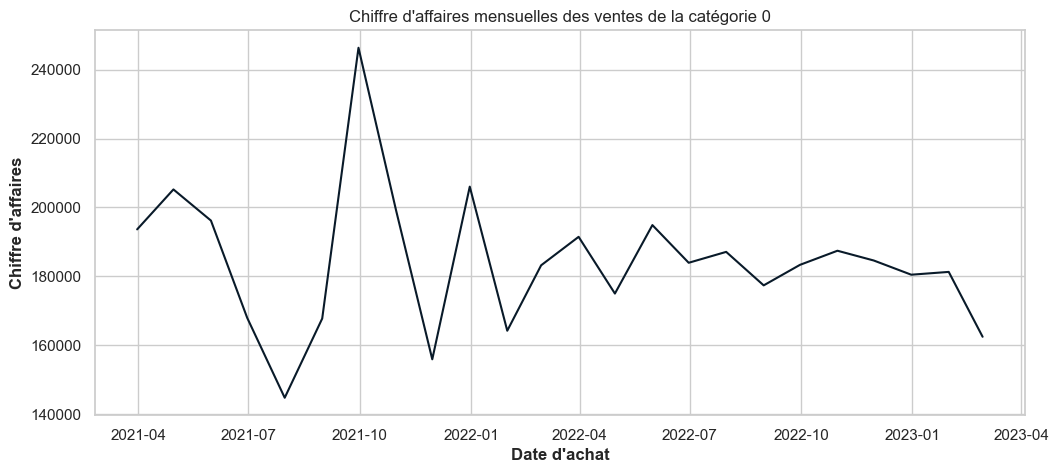

In [169]:
# Créer le graphique en ligne
sns.set_theme(style="whitegrid")


plt.figure(figsize=(12, 5))  # Définir la taille du graphique
sns.lineplot(data=serie_mensuelle_categ_0, x="date_achat", y="price", color='#091A29')

# Ajouter un titre et des labels
plt.title("Chiffre d'affaires mensuelles des ventes de la catégorie 0")
plt.xlabel("Date d'achat")
plt.ylabel("Chiffre d'affaires")
plt.grid(True)

# Afficher le graphique
plt.show()

Identifier une éventuelle saisonnalité

In [170]:
# Utiliser la fonction check seasonnality de Darts
# Vérifier la saisonnalité pour des périodicités allant de 2 à 24 semaines
for m in range(2, 12):
    is_seasonal, period = check_seasonality(serie_mensuelle_categ_0_ts, m=m, alpha=0.05)
    if is_seasonal:
        print(f"Il ya une saisonnalité d'ordre {period}.")
        
        # Ajustement dynamique du max_lag pour éviter l'erreur
        #max_lag = max(12, period)  # On s'assure que max_lag est au moins égal à la saisonnalité détectée
        #plot_acf(serie_mensuelle_categ_0_ts, m=period, alpha=0.05, max_lag=max_lag)

Il ya une saisonnalité d'ordre 5.
Il ya une saisonnalité d'ordre 8.


In [171]:
# Décomposer la série
decompose = sm.tsa.seasonal_decompose(serie_mensuelle_categ_0, model='additive', period=5).plot()

Réaliser les tests de racines unitaire : adfuller, KPSS

In [172]:
# Réaliser un test de racine unitaire : dicker fuller

categ_mensuelle_0 = serie_mensuelle_categ_0['price']


# Effectuer le test ADF
adfuller_result = sm.tsa.stattools.adfuller(categ_mensuelle_0, autolag='AIC')

# Formater les résultats dans un tableau
table = [
    ['Valeur du test ADF', adfuller_result[0]],
    ['P-valeur', adfuller_result[1]],
    ['Nombre de retards utilisés', adfuller_result[2]],
    ['Valeur critique (1%)', adfuller_result[4]['1%']],
    ['Valeur critique (5%)', adfuller_result[4]['5%']],
    ['Valeur critique (10%)', adfuller_result[4]['10%']],
    ['Conclusion', 'La série est stationnaire' if adfuller_result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                   | Valeur                    |
|----------------------------|---------------------------|
| Valeur du test ADF         | -4.53940846373152         |
| P-valeur                   | 0.00016679387298982592    |
| Nombre de retards utilisés | 0                         |
| Valeur critique (1%)       | -3.7529275211638033       |
| Valeur critique (5%)       | -2.998499866852963        |
| Valeur critique (10%)      | -2.6389669754253307       |
| Conclusion                 | La série est stationnaire |


In [173]:
# Effectuer le test KPSS

kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_0, regression='c')

# Vérifier les valeurs critiques pour interpréter la statistique KPSS
critical_value_10 = critical_values['10%']
critical_value_5 = critical_values['5%']
critical_value_1 = critical_values['1%']

# Formater les résultats dans un tableau
table = [
    ['Statistique KPSS', kpss_stat],
    ['P-valeur', p_value],
    ['Lags utilisés', lags],
    ['Valeurs critiques (1%)', critical_value_1],
    ['Valeurs critiques (5%)', critical_value_5],
    ['Valeurs critiques (10%)', critical_value_10],
    ['Conclusion', 'La série est stationnaire' if p_value > 0.05 and kpss_stat < critical_value_5 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                | Valeur                        |
|-------------------------|-------------------------------|
| Statistique KPSS        | 0.4649787525133425            |
| P-valeur                | 0.04955433501951747           |
| Lags utilisés           | 19                            |
| Valeurs critiques (1%)  | 0.739                         |
| Valeurs critiques (5%)  | 0.463                         |
| Valeurs critiques (10%) | 0.347                         |
| Conclusion              | La série est non stationnaire |


Graphiques ACF/PACF

In [174]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(categ_mensuelle_0, lags = 23, ax=ax1)
plot_pacf(categ_mensuelle_0, lags = 12, ax=ax2)
plt.show()

In [175]:
# Ajuster le modèle ARIMA avec les paramètres p, d, q
mensuelle_arima_model = ARIMA(categ_mensuelle_0, order=(1, 0, 1))
mensuelle_arima_result_categ_0 = mensuelle_arima_model.fit()

# Afficher le résumé du modèle
print(mensuelle_arima_result_categ_0.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   24
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -268.110
Date:                Sat, 26 Oct 2024   AIC                            544.220
Time:                        17:12:30   BIC                            548.932
Sample:                    03-31-2021   HQIC                           545.470
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.845e+05    960.518    192.053      0.000    1.83e+05    1.86e+05
ar.L1          0.3415      0.146      2.332      0.020       0.055       0.628
ma.L1         -0.9996      0.286     -3.497      0.0

In [176]:
# Extraire les résidus du modèle ARIMA
residuals = pd.DataFrame(mensuelle_arima_result_categ_0.resid)

# Effectuer le test de Jarque-Bera
jb_test = st.jarque_bera(residuals)

# Afficher les résultats
table = [
    ['Statistique de Jarque-Bera', jb_test.statistic],
    ['P-valeur', jb_test.pvalue],
    ['Conclusion', 'Les résidus suivent une distribution normale' if jb_test.pvalue > 0.05 else 'Les résidus ne suivent pas une distribution normale']
]

# Afficher les résultats sous forme de tableau
from tabulate import tabulate
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                   | Valeur                                       |
|----------------------------|----------------------------------------------|
| Statistique de Jarque-Bera | 0.35224248569674516                          |
| P-valeur                   | 0.8385163130675989                           |
| Conclusion                 | Les résidus suivent une distribution normale |


In [177]:
# Diagnostic du modèle
mensuelle_arima_result_categ_0.plot_diagnostics(figsize=(10, 6))
plt.show()

Test de blancheur Ljung-Box

In [178]:
# Effectuer le test de Ljung-Box
ljung_box_result = acorr_ljungbox(residuals, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18], return_df=True)
print(ljung_box_result)

      lb_stat  lb_pvalue
1    0.618447   0.431625
2    4.199992   0.122457
3    5.763420   0.123705
4    6.898010   0.141377
5    7.404298   0.192266
6    7.910001   0.244771
7    7.931837   0.338643
8    8.050226   0.428579
9    8.052477   0.528867
10   8.052602   0.623699
11   8.408792   0.676284
12   8.413428   0.752046
18  13.519077   0.759861


Pas d'autocorrélation des résidus

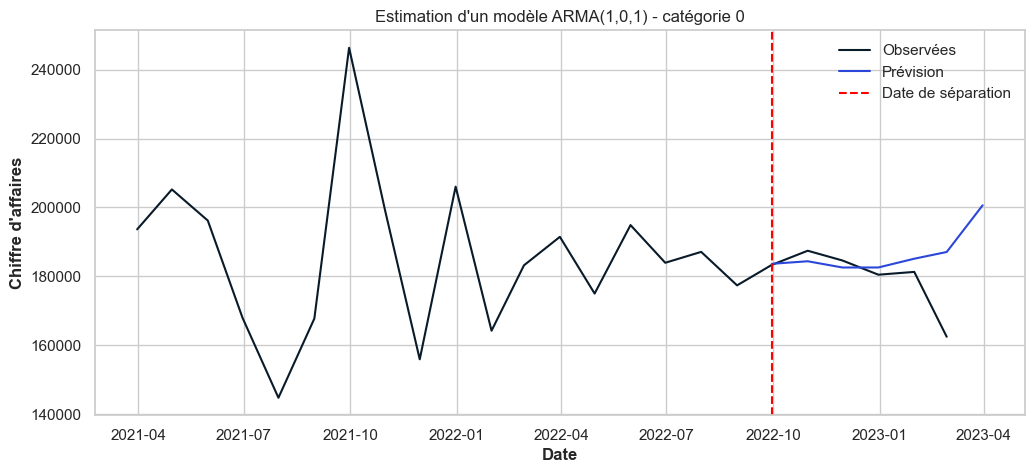

In [179]:
import datetime

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,5))


pred = mensuelle_arima_result_categ_0.predict(18, 24) #Prédiction 

plt.plot(categ_mensuelle_0, color ='#091A29', label='Observées') #Visualisation
plt.plot(pred,color='#2B47D9', label='Prévision')
plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.title('Estimation d\'un modèle ARMA(1,0,1) - catégorie 0')
plt.xlabel("Date")
plt.ylabel('Chiffre d\'affaires')
plt.legend()
plt.grid(True)

Accuracy et performances du modèle

In [180]:
# Calculer le MAE
mae = np.mean(np.abs(categ_mensuelle_0 - pred))

# Calculer le MSE
mse = np.mean((categ_mensuelle_0 - pred) ** 2)

# Calculer le RMSE
rmse = np.sqrt(mse)

# Calculer le MAPE
mape = np.mean(np.abs((categ_mensuelle_0 - pred) / categ_mensuelle_0)) * 100

# Afficher les résultats
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 5988.157008946097
MSE: 106334826.20744999
RMSE: 10311.877918567985
MAPE: 3.553320750400022%


c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


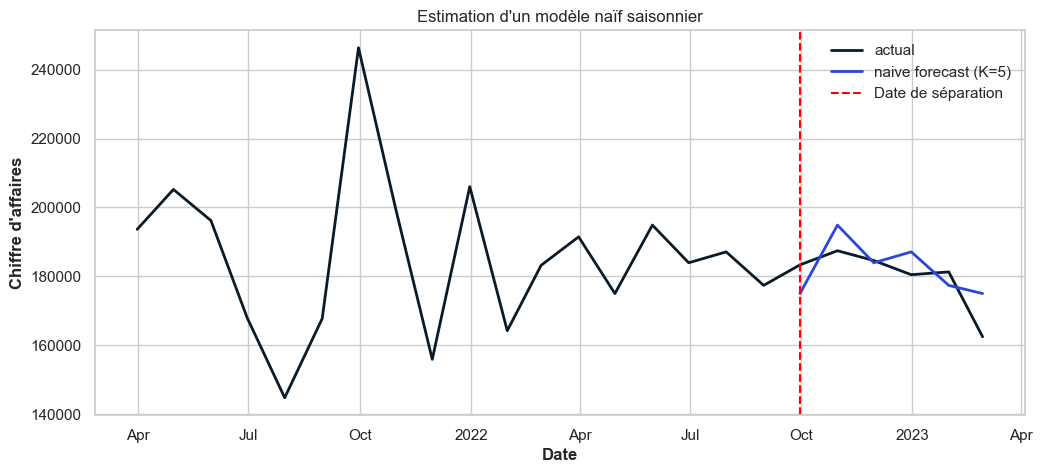

In [181]:
from darts.models import NaiveSeasonal

train, val = serie_mensuelle_categ_0_ts[:-6], serie_mensuelle_categ_0_ts[-6:]

naive_model = NaiveSeasonal(K=5)
naive_model.fit(train)
naive_forecast = naive_model.predict(6)

# Ajouter des légendes et afficher le graphique
plt.figure(figsize=(12,5))
sns.set_theme(style="whitegrid")
serie_mensuelle_categ_0_ts.plot(label="actual", color='#091A29')
naive_forecast.plot(label="naive forecast (K=5)", color='#2B47D9')

plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.title("Estimation d\'un modèle naïf saisonnier")
plt.xlabel("Date")
plt.ylabel('Chiffre d\'affaires')
plt.legend()
plt.grid(True)
plt.show()

Prévision du chiffre d'affaires à un horizon de 3 mois

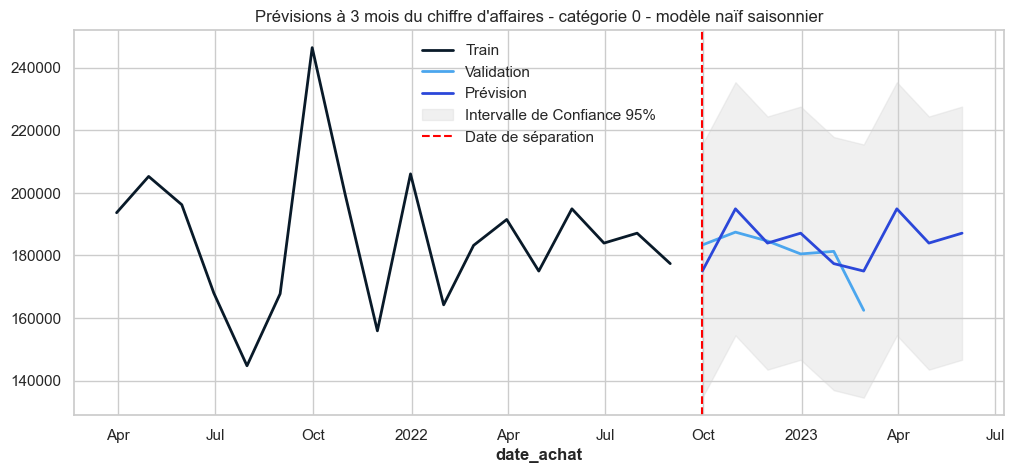

In [182]:
from darts.models import NaiveSeasonal
import numpy as np
import matplotlib.pyplot as plt

# Diviser les données en train et validation
train, val = serie_mensuelle_categ_0_ts[:-6], serie_mensuelle_categ_0_ts[-6:]

# Créer et ajuster le modèle NaiveSeasonal
naive_model = NaiveSeasonal(K=5)
naive_model.fit(train)

# Effectuer la prévision à horizon de 6 mois
naive_forecast = naive_model.predict(9)

# Calculer les résidus sur les données d'entraînement
train_forecast = naive_model.predict(len(train))
residuals = train - train_forecast

# Calculer l'écart-type des résidus
residual_std = np.std(residuals.values())

# Définir un niveau de confiance
z_score = 1.96  # Pour un intervalle de confiance de 95%

# Convertir les valeurs de la prévision en tableau 1D
naive_forecast_values = naive_forecast.values().squeeze()

# Calculer les intervalles de confiance
lower_bound = naive_forecast_values - z_score * residual_std
upper_bound = naive_forecast_values + z_score * residual_std

# Tracer les prévisions avec les intervalles de confiance
plt.figure(figsize=(12, 5))
train.plot(label='Train', color='#091A29')
val.plot(label='Validation', color='#4BA6EE')
naive_forecast.plot(label='Prévision', color='#2B47D9')
plt.fill_between(naive_forecast.time_index, lower_bound, upper_bound, color='#D0D0D0', alpha=0.3, label='Intervalle de Confiance 95%')
plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.title("Prévisions à 3 mois du chiffre d\'affaires - catégorie 0 - modèle naïf saisonnier")
plt.legend()
plt.show()


Calcul des métriques d'évaluation

In [183]:
from darts.metrics import mae, mse, rmse, mape

# Calcul des métriques d'évaluation
mae_value = mae(val, naive_forecast)
mse_value = mse(val, naive_forecast)
rmse_value = rmse(val, naive_forecast)
mape_value = mape(val, naive_forecast)

# Afficher les résultats
print(f"MAE: {mae_value}")
print(f"MSE: {mse_value}")
print(f"RMSE: {rmse_value}")
print(f"MAPE: {mape_value}%")

MAE: 6585.249999999995
MSE: 56952336.01283324
RMSE: 7546.677150430727
MAPE: 3.7368480990537747%


Extraire les prévisions avec les intervalles de confiance sous forme de tableau.

In [184]:
# Organiser les résultats dans un DataFrame
df_forecast = pd.DataFrame({
    'Date': naive_forecast.time_index,  # index temporel des prévisions
    'Prévision': naive_forecast_values,
    'Borne Inférieure (95%)': lower_bound,
    'Borne Supérieure (95%)': upper_bound
})

# Afficher le DataFrame des prévisions avec les intervalles de confiance
print(df_forecast)

        Date  Prévision  Borne Inférieure (95%)  Borne Supérieure (95%)
0 2022-09-30  174997.26           134571.124675           215423.395325
1 2022-10-31  194872.34           154446.204675           235298.475325
2 2022-11-30  183934.86           143508.724675           224360.995325
3 2022-12-31  187097.00           146670.864675           227523.135325
4 2023-01-31  177372.76           136946.624675           217798.895325
5 2023-02-28  174997.26           134571.124675           215423.395325
6 2023-03-31  194872.34           154446.204675           235298.475325
7 2023-04-30  183934.86           143508.724675           224360.995325
8 2023-05-31  187097.00           146670.864675           227523.135325


Estimation d'un modèle Holt-Winters

c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


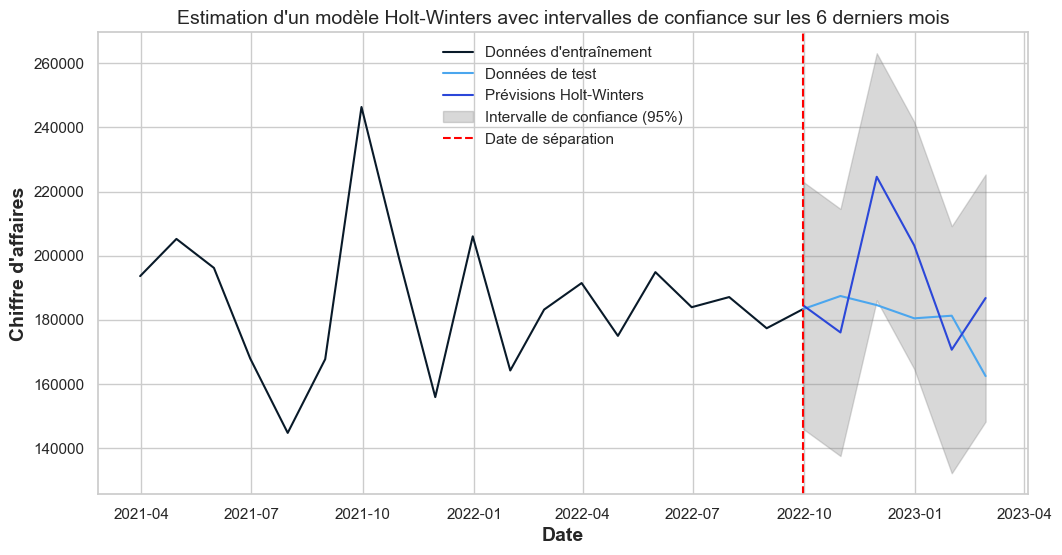

In [185]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Définir la date de séparation pour les 6 derniers mois
date_separation = categ_mensuelle_0.index[-6]  # Prenez la date correspondant au début des 6 derniers mois

# Diviser les données en données d'entraînement et de test
train_data = categ_mensuelle_0[:date_separation]  # Données d'entraînement
test_data = categ_mensuelle_0[date_separation:]  # Données de test (les 6 derniers mois)

# Ajuster le modèle Holt-Winters sur les données d'entraînement
holt_winters_model = ExponentialSmoothing(
    train_data,
    trend='add',  # ou 'mul' selon vos données
    seasonal='add',  # ou 'mul' selon vos données
    seasonal_periods=5  # Ajuster selon la périodicité de votre série
).fit()

# Obtenir les prédictions
pred = holt_winters_model.forecast(steps=len(test_data))

# Calcul des résidus sur l'ensemble des données d'entraînement
residuals = train_data - holt_winters_model.fittedvalues

# Calcul de l'écart-type des résidus
std_residuals = np.std(residuals)

# Calcul des intervalles de confiance (95%)
z_score = 1.96  # Pour un intervalle de confiance à 95%
lower_bound = pred - z_score * std_residuals
upper_bound = pred + z_score * std_residuals

# Tracer le graphique avec les intervalles de confiance
plt.figure(figsize=(12, 6))

# Visualiser les données d'entraînement
plt.plot(train_data, label='Données d\'entraînement', color='#091A29')

# Visualiser les données de test (réelles)
plt.plot(test_data, label='Données de test', color='#4BA6EE')

# Visualiser les prévisions
plt.plot(pd.date_range(start=test_data.index[0], periods=len(test_data), freq='ME'), 
         pred, color='#2B47D9', label='Prévisions Holt-Winters')

# Tracer les intervalles de confiance
plt.fill_between(pd.date_range(start=test_data.index[0], periods=len(test_data), freq='ME'), 
                 lower_bound, upper_bound, color='gray', alpha=0.3, label='Intervalle de confiance (95%)')

# Ajouter une légende et des titres
plt.axvline(x=date_separation, color='red', linestyle='--', label='Date de séparation')
plt.title('Estimation d\'un modèle Holt-Winters avec intervalles de confiance sur les 6 derniers mois', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Chiffre d\'affaires', fontsize=14)
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


Extraire les prévisions ainsi que leurs intervalles de confiance sous forme de tableau.

In [186]:
# Créer un DataFrame avec les prévisions et les intervalles de confiance
forecast_table = pd.DataFrame({
    'Date': pd.date_range(start=test_data.index[0], periods=len(test_data), freq='ME'),
    'Prévision': pred.values,
    'Borne Inférieure (95%)': lower_bound.values,
    'Borne Supérieure (95%)': upper_bound.values
})

# Afficher le tableau
print(forecast_table)


        Date      Prévision  Borne Inférieure (95%)  Borne Supérieure (95%)
0 2022-09-30  184560.130787           146049.330314           223070.931260
1 2022-10-31  176062.361961           137551.561488           214573.162434
2 2022-11-30  224597.608857           186086.808383           263108.409330
3 2022-12-31  203179.662389           164668.861916           241690.462862
4 2023-01-31  170679.802982           132169.002508           209190.603455
5 2023-02-28  186796.616138           148285.815665           225307.416612


In [187]:
import numpy as np

# Calcul du MAE
mae_value = np.mean(np.abs(test_data - pred))

# Calcul du MSE
mse_value = np.mean((test_data - pred)**2)

# Calcul du RMSE
rmse_value = np.sqrt(mse_value)

# Calcul du MAPE
mape_value = np.mean(np.abs((test_data - pred) / test_data)) * 100

# Afficher les résultats
print(f"MAE: {mae_value:.2f}")
print(f"MSE: {mse_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAPE: {mape_value:.2f}%")

MAE: 17129.47
MSE: 515057195.24
RMSE: 22694.87
MAPE: 9.55%


<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.8.3 - Estimer un modèle de prévision des ventes de la catégorie 1</h4></div>

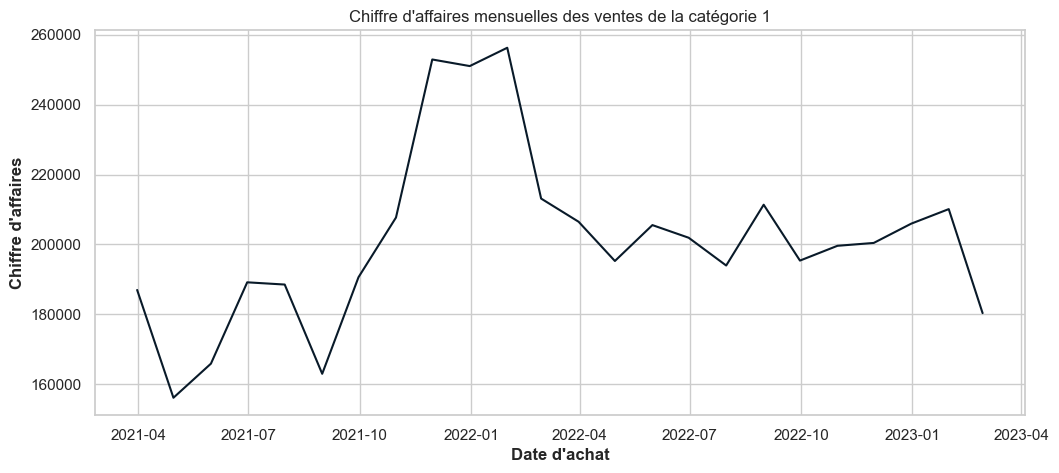

In [188]:
# Créer le graphique en ligne
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))  # Définir la taille du graphique
sns.lineplot(data=serie_mensuelle_categ_1, x="date_achat", y="price", color='#091A29')

# Ajouter un titre et des labels
plt.title("Chiffre d'affaires mensuelles des ventes de la catégorie 1")
plt.xlabel("Date d'achat")
plt.ylabel("Chiffre d'affaires")
plt.grid(True)

# Afficher le graphique
plt.show()

Identifier la saisonnalité

In [189]:
# Utiliser la fonction check seasonnality de Darts
# Vérifier la saisonnalité pour des périodicités allant de 2 à 24 semaines
for m in range(2, 23):
    is_seasonal, period = check_seasonality(serie_mensuelle_categ_1_ts, m=m, alpha=0.05)
    if is_seasonal:
        print(f"Il ya une saisonnalité d'ordre {period}.")
        
        # Ajustement dynamique du max_lag pour éviter l'erreur
        #max_lag = max(23, period)  # On s'assure que max_lag est au moins égal à la saisonnalité détectée
        #plot_acf(serie_mensuelle_categ_1_ts, m=period, alpha=0.05, max_lag=max_lag)

Il ya une saisonnalité d'ordre 18.
Il ya une saisonnalité d'ordre 22.


In [190]:
import statsmodels.api as sm

# Décomposer la série
decompose = sm.tsa.seasonal_decompose(serie_mensuelle_categ_1, model='additive', period=12).plot()

Tests de racine unitaire

In [191]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Réaliser un test de racine unitaire : dicker fuller
categ_mensuelle_1 = serie_mensuelle_categ_1['price']


# Effectuer le test ADF
adfuller_result = sm.tsa.stattools.adfuller(categ_mensuelle_1, autolag='AIC')

# Formater les résultats dans un tableau
table = [
    ['Valeur du test ADF', adfuller_result[0]],
    ['P-valeur', adfuller_result[1]],
    ['Nombre de retards utilisés', adfuller_result[2]],
    ['Valeur critique (1%)', adfuller_result[4]['1%']],
    ['Valeur critique (5%)', adfuller_result[4]['5%']],
    ['Valeur critique (10%)', adfuller_result[4]['10%']],
    ['Conclusion', 'La série est stationnaire' if adfuller_result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                   | Valeur                        |
|----------------------------|-------------------------------|
| Valeur du test ADF         | -0.36477791276680654          |
| P-valeur                   | 0.915815591414088             |
| Nombre de retards utilisés | 9                             |
| Valeur critique (1%)       | -4.01203360058309             |
| Valeur critique (5%)       | -3.1041838775510207           |
| Valeur critique (10%)      | -2.6909873469387753           |
| Conclusion                 | La série est non stationnaire |


In [192]:
# Effectuer le test KPSS

kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_1, regression='c')

# Vérifier les valeurs critiques pour interpréter la statistique KPSS
critical_value_10 = critical_values['10%']
critical_value_5 = critical_values['5%']
critical_value_1 = critical_values['1%']

# Formater les résultats dans un tableau
table = [
    ['Statistique KPSS', kpss_stat],
    ['P-valeur', p_value],
    ['Lags utilisés', lags],
    ['Valeurs critiques (1%)', critical_value_1],
    ['Valeurs critiques (5%)', critical_value_5],
    ['Valeurs critiques (10%)', critical_value_10],
    ['Conclusion', 'La série est stationnaire' if p_value > 0.05 and kpss_stat < critical_value_5 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                | Valeur                    |
|-------------------------|---------------------------|
| Statistique KPSS        | 0.1615821178396277        |
| P-valeur                | 0.1                       |
| Lags utilisés           | 3                         |
| Valeurs critiques (1%)  | 0.739                     |
| Valeurs critiques (5%)  | 0.463                     |
| Valeurs critiques (10%) | 0.347                     |
| Conclusion              | La série est stationnaire |


C:\Users\jerem\AppData\Local\Temp\ipykernel_17296\2767713866.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_1, regression='c')


Graphiques ACF/PACF

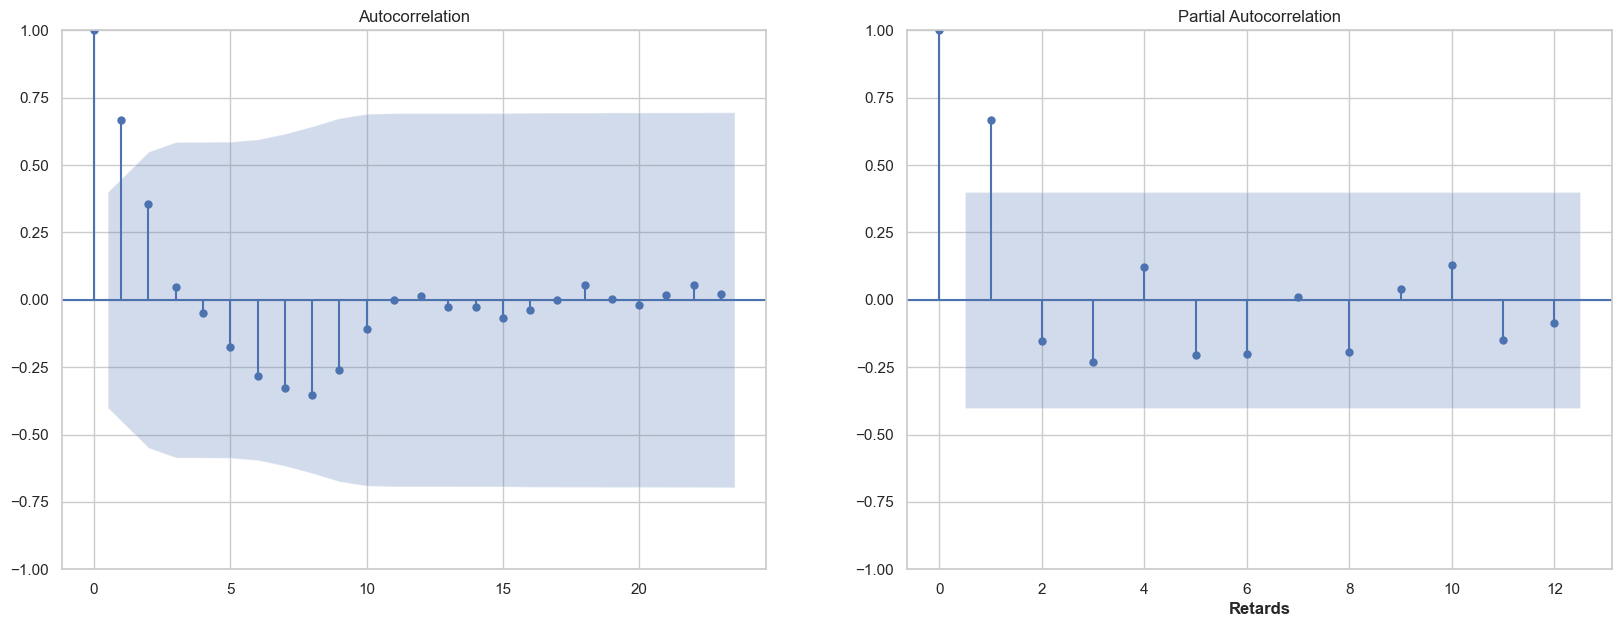

In [193]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(categ_mensuelle_1, lags = 23, ax=ax1)
plot_pacf(categ_mensuelle_1, lags = 12, ax=ax2)
plt.xlabel('Retards')
plt.show()

Selon les résultats contradictoires des tests. Il y a une tendance stochastique. Appliquer une 1ère différenciation sur la série.

Effectuer à nouveau les tests de racine unitaire.

In [194]:
# Appliquer une 1ère différenciation sur la série catégorie 1
categ_mensuelle_1_diff_1 = categ_mensuelle_1.diff().dropna()

# Visualiser la série différenciée
categ_mensuelle_1_diff_1.plot(title='Série différenciée')
plt.xlabel('Date')
plt.ylabel('Différence de Price')
plt.grid(True)
plt.show()

In [195]:
# Réaliser un test de racine unitaire : dicker fuller

# Effectuer le test ADF
adfuller_result = sm.tsa.stattools.adfuller(categ_mensuelle_1_diff_1, autolag='AIC')

# Formater les résultats dans un tableau
table = [
    ['Valeur du test ADF', adfuller_result[0]],
    ['P-valeur', adfuller_result[1]],
    ['Nombre de retards utilisés', adfuller_result[2]],
    ['Valeur critique (1%)', adfuller_result[4]['1%']],
    ['Valeur critique (5%)', adfuller_result[4]['5%']],
    ['Valeur critique (10%)', adfuller_result[4]['10%']],
    ['Conclusion', 'La série est stationnaire' if adfuller_result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                   | Valeur                    |
|----------------------------|---------------------------|
| Valeur du test ADF         | -7.48063410411669         |
| P-valeur                   | 4.7828201835144526e-11    |
| Nombre de retards utilisés | 9                         |
| Valeur critique (1%)       | -4.068853732362312        |
| Valeur critique (5%)       | -3.1271488757396453       |
| Valeur critique (10%)      | -2.7017297633136095       |
| Conclusion                 | La série est stationnaire |


In [196]:
# Effectuer le test KPSS

kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_1_diff_1, regression='c')

# Vérifier les valeurs critiques pour interpréter la statistique KPSS
critical_value_10 = critical_values['10%']
critical_value_5 = critical_values['5%']
critical_value_1 = critical_values['1%']

# Formater les résultats dans un tableau
table = [
    ['Statistique KPSS', kpss_stat],
    ['P-valeur', p_value],
    ['Lags utilisés', lags],
    ['Valeurs critiques (1%)', critical_value_1],
    ['Valeurs critiques (5%)', critical_value_5],
    ['Valeurs critiques (10%)', critical_value_10],
    ['Conclusion', 'La série est stationnaire' if p_value > 0.05 and kpss_stat < critical_value_5 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                | Valeur                    |
|-------------------------|---------------------------|
| Statistique KPSS        | 0.10767676591189784       |
| P-valeur                | 0.1                       |
| Lags utilisés           | 0                         |
| Valeurs critiques (1%)  | 0.739                     |
| Valeurs critiques (5%)  | 0.463                     |
| Valeurs critiques (10%) | 0.347                     |
| Conclusion              | La série est stationnaire |


C:\Users\jerem\AppData\Local\Temp\ipykernel_17296\1184409557.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_1_diff_1, regression='c')


Graphiques ACF/PACF

In [197]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(categ_mensuelle_1_diff_1, lags = 22, ax=ax1)
plot_pacf(categ_mensuelle_1_diff_1, lags = 11, ax=ax2)
plt.xlabel('Retards')
plt.show()

In [198]:
# Ajuster le modèle ARIMA avec les paramètres p, d, q
arima_model_diff = ARIMA(categ_mensuelle_1_diff_1, order=(0, 1, 1))
arima_result_categ_1 = arima_model_diff.fit()

# Afficher le résumé du modèle
print(arima_result_categ_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   23
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -250.107
Date:                Sat, 26 Oct 2024   AIC                            504.215
Time:                        17:12:43   BIC                            506.397
Sample:                    04-30-2021   HQIC                           504.729
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.303     -3.295      0.001      -1.594      -0.405
sigma2      4.016e+08   7.57e-10    5.3e+17      0.000    4.02e+08    4.02e+08
Ljung-Box (L1) (Q):                   0.07   Jarque-

In [199]:
residuals = pd.DataFrame(arima_result_categ_1.resid)

# Effectuer le test de Shapiro-Wilk
stat, p_value = st.shapiro(residuals)

# Afficher les résultats
print(f'Statistique de Shapiro-Wilk : {stat}')
print(f'P-valeur : {p_value}')

# Interprétation
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (échec de rejet de H0)")
else:
    print("Les données ne suivent pas une distribution normale (rejet de H0)")

Statistique de Shapiro-Wilk : 0.9858653259686536
P-valeur : 0.9784813280921659
Les données suivent une distribution normale (échec de rejet de H0)


In [200]:
# Extraire les résidus du modèle ARIMA
residuals = pd.DataFrame(arima_result_categ_1.resid)

# Effectuer le test de Jarque-Bera
jb_test = st.jarque_bera(residuals)

# Afficher les résultats
table = [
    ['Statistique de Jarque-Bera', jb_test.statistic],
    ['P-valeur', jb_test.pvalue],
    ['Conclusion', 'Les résidus suivent une distribution normale' if jb_test.pvalue > 0.05 else 'Les résidus ne suivent pas une distribution normale']
]

# Afficher les résultats sous forme de tableau
from tabulate import tabulate
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                   | Valeur                                       |
|----------------------------|----------------------------------------------|
| Statistique de Jarque-Bera | 0.08562704603256022                          |
| P-valeur                   | 0.9580900351498017                           |
| Conclusion                 | Les résidus suivent une distribution normale |


In [201]:
# Diagnostic du modèle
arima_result_categ_1.plot_diagnostics(figsize=(10, 6))
plt.show()

In [202]:
# Effectuer le test de Ljung-Box
ljung_box_result = acorr_ljungbox(residuals, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 14, 18, 22], return_df=True)
print(ljung_box_result)

      lb_stat  lb_pvalue
1    0.001183   0.972560
2    0.002311   0.998845
3    2.678078   0.443966
4    2.920642   0.571192
5    2.980584   0.702979
6    2.995053   0.809467
7    3.102137   0.875396
8    3.674393   0.885242
9    4.545031   0.872031
10   4.585039   0.917121
11   4.979475   0.932157
12   5.478774   0.940050
16   7.718919   0.956797
14   5.939339   0.967997
18   8.524397   0.969764
22  16.271999   0.802161


In [203]:
from statsmodels.tsa.arima.model import ARIMA

# Effectuer une prévision de 6 mois (6 étapes)
forecast_horizon = 6
pred = arima_result_categ_1.forecast(steps=forecast_horizon)

# Créer une plage de dates pour les 6 mois prévus
last_date = categ_mensuelle_1.index[-1]  # Dernière date de la série
future_dates = pd.date_range(start=last_date, periods=forecast_horizon+1, freq='ME')[1:]  # Générer 6 mois supplémentaires

# Tracer les résultats
plt.figure(figsize=(12, 6))

# Tracer la série temporelle observée
plt.plot(categ_mensuelle_1, label="Série observée", color='#091A29')

# Tracer les prévisions
plt.plot(future_dates, pred, label="Prévisions ARIMA", color='#2B47D9', linestyle='--')

# Ajouter une ligne verticale pour marquer la date de séparation
plt.axvline(x=last_date, color='red', linestyle='--', label='Date de séparation')

# Ajouter les titres, légendes et afficher le graphique
plt.title('Prévisions ARIMA à 6 mois', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Valeur différenciée', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


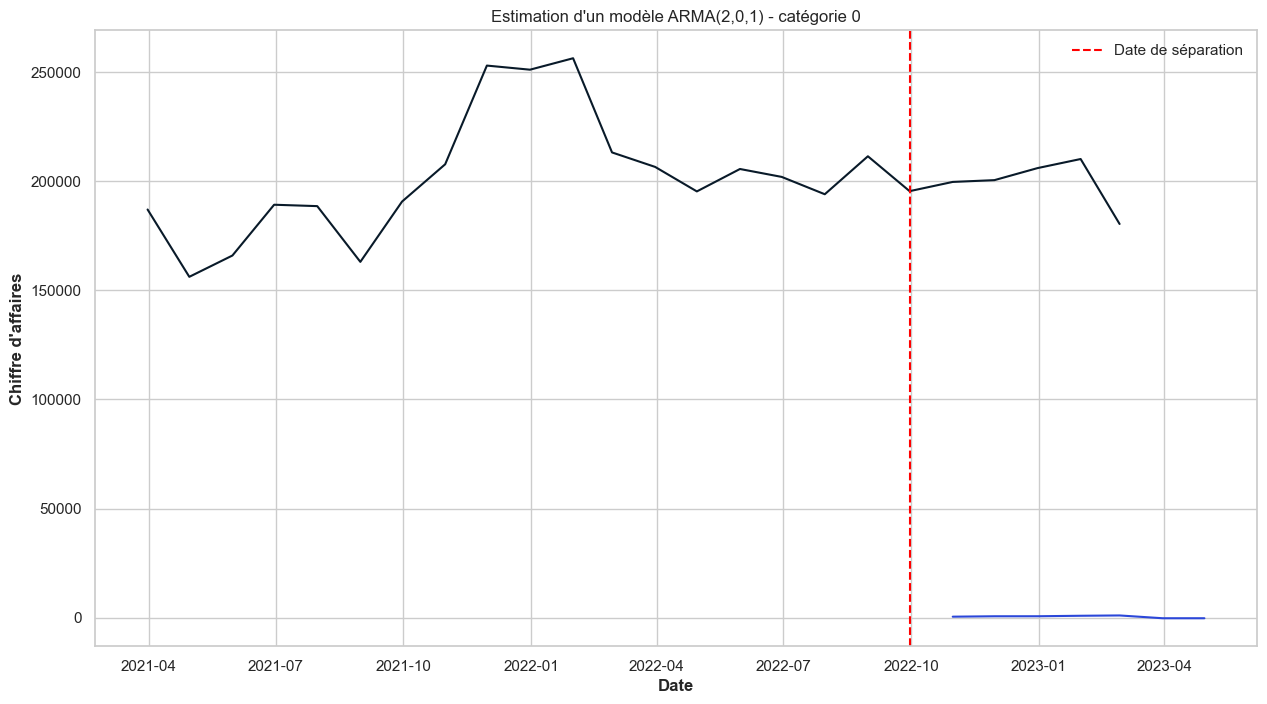

In [204]:
import datetime
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))


pred = arima_result_categ_1.predict(18, 24) #Prédiction 

plt.plot(categ_mensuelle_1, color ='#091A29') #Visualisation
plt.title('Estimation d\'un modèle ARMA(2,0,1) - catégorie 0')
plt.plot(pred,color='#2B47D9')
plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.xlabel("Date")
plt.ylabel('Chiffre d\'affaires')
plt.legend()
plt.grid(True)

Accuracy et performances du modèle

In [205]:
# Calculer le MAE
mae = np.mean(np.abs(categ_mensuelle_1 - pred))

# Calculer le MSE
mse = np.mean((categ_mensuelle_1 - pred) ** 2)

# Calculer le RMSE
rmse = np.sqrt(mse)

# Calculer le MAPE
mape = np.mean(np.abs((categ_mensuelle_1 - pred) / categ_mensuelle_1)) * 100

# Afficher les résultats
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 198570.396067381
MSE: 39536371816.81765
RMSE: 198837.55132473758
MAPE: 99.6367827827454%


Le modèle ARIMA ne permet pas d'établir une prévision sur la série mensuelle de la catégorie 1

Estimer un modèle Naive Saisonnier

In [206]:
import matplotlib.pyplot as plt
from darts.models import NaiveSeasonal
from darts.metrics import mae, mse, rmse, mape

# Diviser les données en train et validation (6 derniers mois pour validation)
train_2, val_2 = serie_mensuelle_categ_1_ts[:-6], serie_mensuelle_categ_1_ts[-6:]

# Créer un modèle naïf saisonnier avec K=3
naive_model_2 = NaiveSeasonal(K=18)
naive_model_2.fit(train_2)

# Faire des prévisions sur les 6 mois de validation
naive_forecast_2 = naive_model_2.predict(len(val_2))

# Tracer les séries réelles et prédites
plt.figure(figsize=(10, 6))
serie_mensuelle_categ_1_ts.plot(label="Données réelles", color='#091A29')
naive_forecast_2.plot(label="Prédiction naïve (K=18)", color='#2B47D9')

# Ajouter des légendes et afficher le graphique
sns.set_theme(style="whitegrid")
plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.title("Estimation d\'un modèle naïf saisonnier")
plt.xlabel("Date")
plt.ylabel('Chiffre d\'affaires')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des métriques d'évaluation
mae_value = mae(val_2, naive_forecast_2)
mse_value = mse(val_2, naive_forecast_2)
rmse_value = rmse(val_2, naive_forecast_2)
mape_value = mape(val_2, naive_forecast_2)

# Afficher les résultats
print(f"MAE: {mae_value}")
print(f"MSE: {mse_value}")
print(f"RMSE: {rmse_value}")
print(f"MAPE: {mape_value}%")

MAE: 23688.656666666666
MSE: 700284333.8548666
RMSE: 26462.885969879902
MAPE: 11.892570203648779%


Prévision du chiffre d'affaires à un horizon de 3 mois

In [207]:
from darts.models import NaiveSeasonal

# Diviser les données en train et validation
train, val = serie_mensuelle_categ_1_ts[:-6], serie_mensuelle_categ_1_ts[-6:]

# Créer et ajuster le modèle NaiveSeasonal
naive_model = NaiveSeasonal(K=18)
naive_model.fit(train)

# Effectuer la prévision à horizon de 6 mois
naive_forecast = naive_model.predict(9)

# Calculer les résidus sur les données d'entraînement
train_forecast = naive_model.predict(len(train))
residuals = train - train_forecast

# Calculer l'écart-type des résidus
residual_std = np.std(residuals.values())

# Définir un niveau de confiance
z_score = 1.96  # Pour un intervalle de confiance de 95%

# Convertir les valeurs de la prévision en tableau 1D
naive_forecast_values = naive_forecast.values().squeeze()

# Calculer les intervalles de confiance
lower_bound = naive_forecast_values - z_score * residual_std
upper_bound = naive_forecast_values + z_score * residual_std

# Tracer les prévisions avec les intervalles de confiance
plt.figure(figsize=(12, 5))
train.plot(label='Train', color='#091A29')
val.plot(label='Validation', color='#4BA6EE')
naive_forecast.plot(label='Prévision', color='#2B47D9')
plt.fill_between(naive_forecast.time_index, lower_bound, upper_bound, color='#D0D0D0', alpha=0.3, label='Intervalle de Confiance 95%')
plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.title("Prévisions à 3 mois du chiffre d\'affaires - catégorie 1 - modèle naïf saisonnier")
plt.legend()
plt.show()

In [208]:
# Organiser le tout dans un DataFrame
df_forecast = pd.DataFrame({
    'Date': naive_forecast.time_index,  # index temporel des prévisions
    'Prévision': naive_forecast_values,
    'Borne Inférieure (95%)': lower_bound,
    'Borne Supérieure (95%)': upper_bound
})

# Afficher le DataFrame des prévisions avec les intervalles de confiance
print(df_forecast)

        Date  Prévision  Borne Inférieure (95%)  Borne Supérieure (95%)
0 2022-09-30  186974.17               186974.17               186974.17
1 2022-10-31  156138.35               156138.35               156138.35
2 2022-11-30  165893.40               165893.40               165893.40
3 2022-12-31  189162.04               189162.04               189162.04
4 2023-01-31  188523.27               188523.27               188523.27
5 2023-02-28  162991.38               162991.38               162991.38
6 2023-03-31  190613.78               190613.78               190613.78
7 2023-04-30  207696.74               207696.74               207696.74
8 2023-05-31  252910.39               252910.39               252910.39


Estimer un modèle Holt-Winters

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Supposons que categ_mensuelle_1 est votre série temporelle avec un index de dates
# Définir la date de séparation pour les 6 derniers mois
date_separation = categ_mensuelle_1.index[-6]  # Prenez la date correspondant au début des 6 derniers mois

# Diviser les données en données d'entraînement et de test
train_data = categ_mensuelle_1[:date_separation]  # Données d'entraînement
test_data = categ_mensuelle_1[date_separation:]  # Données de test (les 6 derniers mois)

# Ajuster le modèle Holt-Winters sur les données d'entraînement
holt_winters_model = ExponentialSmoothing(
    train_data,
    trend='add',  # ou 'mul' selon vos données
    seasonal='add',  # ou 'mul' selon vos données
    seasonal_periods=18# Ajuster selon la périodicité de votre série
).fit()

# Faire la prévision pour les 6 derniers mois
pred = holt_winters_model.forecast(steps=len(test_data))

# Tracer le graphique
plt.figure(figsize=(12, 6))

# Visualiser les données d'entraînement
plt.plot(train_data, label='Données d\'entraînement', color='blue')

# Visualiser les données de test (réelles)
plt.plot(test_data, label='Données de test', color='green')

# Visualiser les prévisions
plt.plot(pd.date_range(start=test_data.index[0], periods=len(test_data), freq='ME'), 
         pred, color='orange', label='Prévisions Holt-Winters')

# Ajouter une légende et des titres
plt.axvline(x=date_separation, color='red', linestyle='--', label='Date de séparation')
plt.title('Estimation d\'un modèle Holt-Winters sur les 6 derniers mois', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Valeur', fontsize=14)
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

Il n'est pas possible de modéliser un  modèle Holt Winters car il manque des observations.

Le modèle considère une périodicité de 18, ce qui signifie qu'il attend au moins deux cycles complets pour initialiser correctement les composantes saisonnières.

<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.8.4 - Estimer un modèle de prévision des ventes de la catégorie 2</h4></div>

In [210]:
# Créer le graphique en ligne
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))  # Définir la taille du graphique
sns.lineplot(data=serie_mensuelle_categ_2, x="date_achat", y="price", color='#091A29')

# Ajouter un titre et des labels
plt.title("Chiffre d'affaires mensuelles des ventes de la catégorie 2")
plt.xlabel("Date d'achat")
plt.ylabel("Chiffre d'affaires")
plt.grid(True)

# Afficher le graphique
plt.show()

In [211]:
# Utiliser la fonction check seasonnality de Darts
# Vérifier la saisonnalité pour des périodicités allant de 2 à 24 semaines
for m in range(2, 12):
    is_seasonal, period = check_seasonality(serie_mensuelle_categ_2_ts, m=m, alpha=0.05)
    if is_seasonal:
        print(f"Il ya une saisonnalité d'ordre {period}.")
        
        # Ajustement dynamique du max_lag pour éviter l'erreur
        #max_lag = max(12, period)  # On s'assure que max_lag est au moins égal à la saisonnalité détectée
        #plot_acf(serie_mensuelle_categ_2_ts, m=period, alpha=0.05, max_lag=max_lag)

Il ya une saisonnalité d'ordre 3.
Il ya une saisonnalité d'ordre 6.
Il ya une saisonnalité d'ordre 9.
Il ya une saisonnalité d'ordre 11.


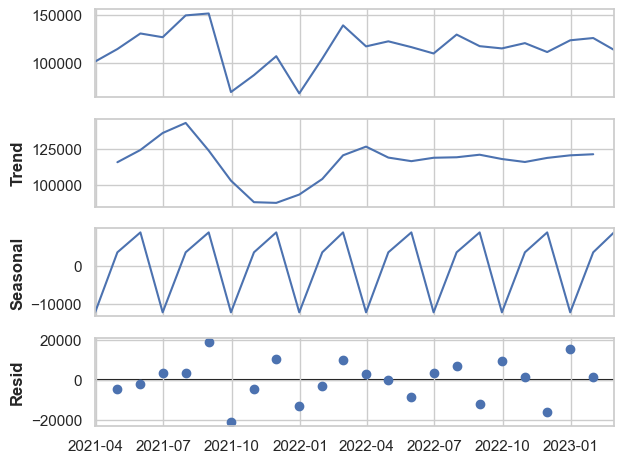

In [212]:
# Décomposer la série
decompose = sm.tsa.seasonal_decompose(serie_mensuelle_categ_2, model='additive', period=3).plot()

In [213]:
# Réaliser un test de racine unitaire : dicker fuller

categ_mensuelle_2 = serie_mensuelle_categ_2['price']


# Effectuer le test ADF
adfuller_result = sm.tsa.stattools.adfuller(categ_mensuelle_2, autolag='AIC')

# Formater les résultats dans un tableau
table = [
    ['Valeur du test ADF', adfuller_result[0]],
    ['P-valeur', adfuller_result[1]],
    ['Nombre de retards utilisés', adfuller_result[2]],
    ['Valeur critique (1%)', adfuller_result[4]['1%']],
    ['Valeur critique (5%)', adfuller_result[4]['5%']],
    ['Valeur critique (10%)', adfuller_result[4]['10%']],
    ['Conclusion', 'La série est stationnaire' if adfuller_result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                   | Valeur                        |
|----------------------------|-------------------------------|
| Valeur du test ADF         | -1.5850315692653711           |
| P-valeur                   | 0.4911081571883382            |
| Nombre de retards utilisés | 9                             |
| Valeur critique (1%)       | -4.01203360058309             |
| Valeur critique (5%)       | -3.1041838775510207           |
| Valeur critique (10%)      | -2.6909873469387753           |
| Conclusion                 | La série est non stationnaire |


In [214]:
# Effectuer le test KPSS

kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_2, regression='c')

# Vérifier les valeurs critiques pour interpréter la statistique KPSS
critical_value_10 = critical_values['10%']
critical_value_5 = critical_values['5%']
critical_value_1 = critical_values['1%']

# Formater les résultats dans un tableau
table = [
    ['Statistique KPSS', kpss_stat],
    ['P-valeur', p_value],
    ['Lags utilisés', lags],
    ['Valeurs critiques (1%)', critical_value_1],
    ['Valeurs critiques (5%)', critical_value_5],
    ['Valeurs critiques (10%)', critical_value_10],
    ['Conclusion', 'La série est stationnaire' if p_value > 0.05 and kpss_stat < critical_value_5 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                | Valeur                    |
|-------------------------|---------------------------|
| Statistique KPSS        | 0.10187048331772612       |
| P-valeur                | 0.1                       |
| Lags utilisés           | 0                         |
| Valeurs critiques (1%)  | 0.739                     |
| Valeurs critiques (5%)  | 0.463                     |
| Valeurs critiques (10%) | 0.347                     |
| Conclusion              | La série est stationnaire |


C:\Users\jerem\AppData\Local\Temp\ipykernel_17296\3811561480.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_2, regression='c')


Graphiques ACF/PACF

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(categ_mensuelle_2, lags = 23, ax=ax1)
plot_pacf(categ_mensuelle_2, lags = 12, ax=ax2)
plt.xlabel('Retards')
plt.show()

Selon les résultats contradictoires des tests. Il y a une tendance stochastique. Appliquer une 1ère différenciation sur la série.

Effectuer à nouveau les tests de racine unitaire.

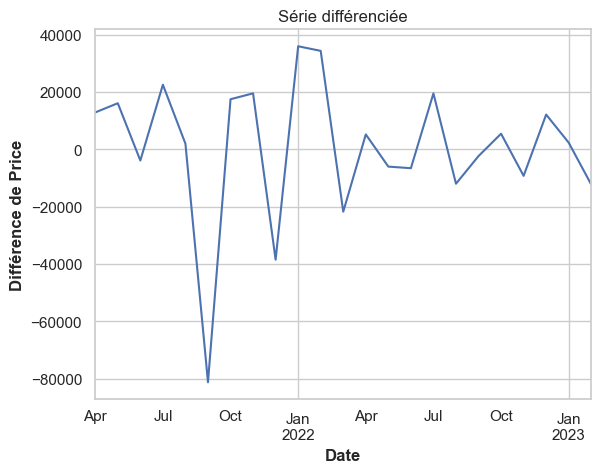

In [216]:
# Appliquer une 1ère différenciation sur la série catégorie 1
categ_mensuelle_2_diff_1 = categ_mensuelle_2.diff().dropna()

# Visualiser la série différenciée
categ_mensuelle_2_diff_1.plot(title='Série différenciée')
plt.xlabel('Date')
plt.ylabel('Différence de Price')
plt.grid(True)
plt.show()

In [217]:
# Réaliser un test de racine unitaire : dicker fuller

# Effectuer le test ADF
adfuller_result = sm.tsa.stattools.adfuller(categ_mensuelle_2_diff_1, autolag='AIC')

# Formater les résultats dans un tableau
table = [
    ['Valeur du test ADF', adfuller_result[0]],
    ['P-valeur', adfuller_result[1]],
    ['Nombre de retards utilisés', adfuller_result[2]],
    ['Valeur critique (1%)', adfuller_result[4]['1%']],
    ['Valeur critique (5%)', adfuller_result[4]['5%']],
    ['Valeur critique (10%)', adfuller_result[4]['10%']],
    ['Conclusion', 'La série est stationnaire' if adfuller_result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                   | Valeur                    |
|----------------------------|---------------------------|
| Valeur du test ADF         | -3.5161877212428454       |
| P-valeur                   | 0.007580962371719845      |
| Nombre de retards utilisés | 8                         |
| Valeur critique (1%)       | -4.01203360058309         |
| Valeur critique (5%)       | -3.1041838775510207       |
| Valeur critique (10%)      | -2.6909873469387753       |
| Conclusion                 | La série est stationnaire |


In [218]:
# Effectuer le test KPSS

kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_2_diff_1, regression='c')

# Vérifier les valeurs critiques pour interpréter la statistique KPSS
critical_value_10 = critical_values['10%']
critical_value_5 = critical_values['5%']
critical_value_1 = critical_values['1%']

# Formater les résultats dans un tableau
table = [
    ['Statistique KPSS', kpss_stat],
    ['P-valeur', p_value],
    ['Lags utilisés', lags],
    ['Valeurs critiques (1%)', critical_value_1],
    ['Valeurs critiques (5%)', critical_value_5],
    ['Valeurs critiques (10%)', critical_value_10],
    ['Conclusion', 'La série est stationnaire' if p_value > 0.05 and kpss_stat < critical_value_5 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique                | Valeur                    |
|-------------------------|---------------------------|
| Statistique KPSS        | 0.34129661728252514       |
| P-valeur                | 0.1                       |
| Lags utilisés           | 13                        |
| Valeurs critiques (1%)  | 0.739                     |
| Valeurs critiques (5%)  | 0.463                     |
| Valeurs critiques (10%) | 0.347                     |
| Conclusion              | La série est stationnaire |


C:\Users\jerem\AppData\Local\Temp\ipykernel_17296\1824951626.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = sm.tsa.stattools.kpss(categ_mensuelle_2_diff_1, regression='c')


Graphiques ACF/PACF

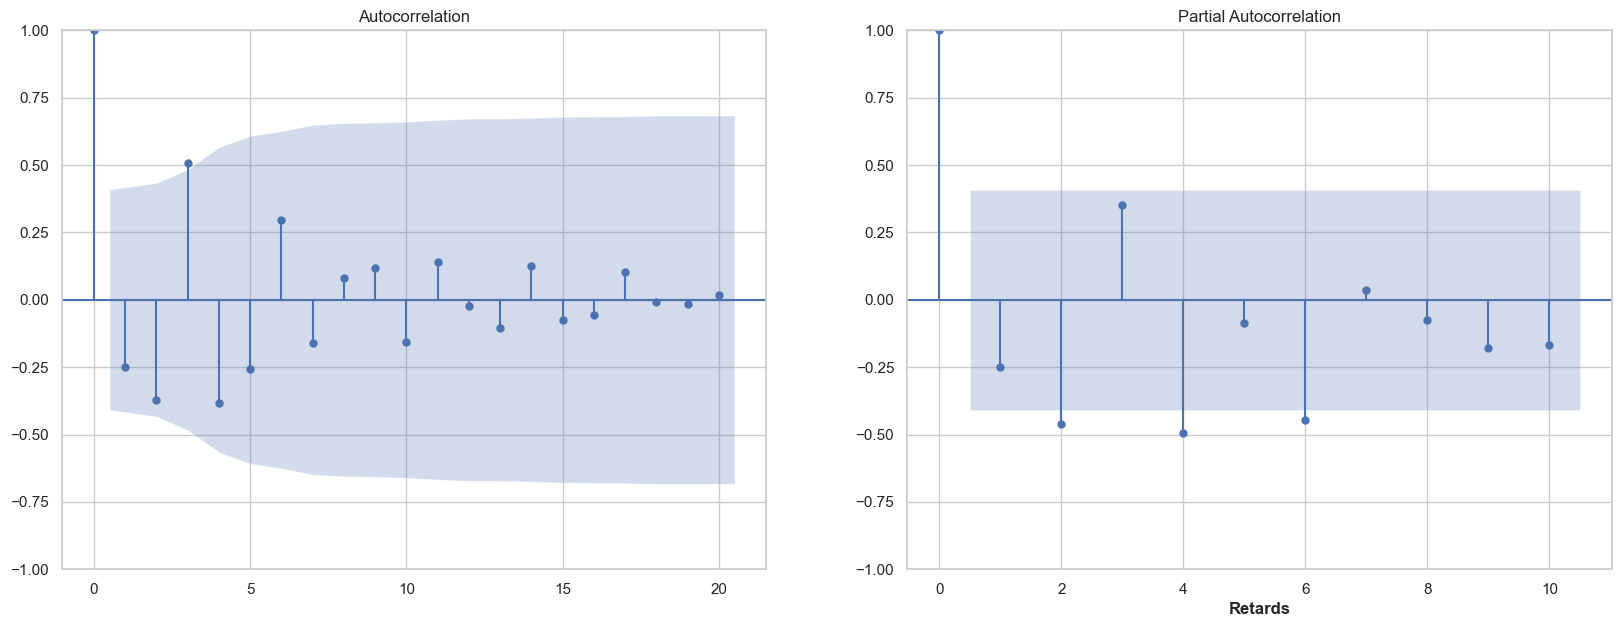

In [235]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(categ_mensuelle_2_diff_1, lags = 20, ax=ax1)
plot_pacf(categ_mensuelle_2_diff_1, lags = 10, ax=ax2)
plt.xlabel('Retards')
plt.show()

In [251]:
# Ajuster le modèle ARIMA avec les paramètres p, d, q
arima_model = ARIMA(categ_mensuelle_2_diff_1, order=(0, 1, 5))
arima_result_categ_2 = arima_model.fit()

# Afficher le résumé du modèle
print(arima_result_categ_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   23
Model:                 ARIMA(0, 1, 5)   Log Likelihood                -248.829
Date:                Sat, 26 Oct 2024   AIC                            509.659
Time:                        17:23:55   BIC                            516.205
Sample:                    04-30-2021   HQIC                           511.201
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5488      0.299     -5.188      0.000      -2.134      -0.964
ma.L2          0.5488      0.240      2.286      0.022       0.078       1.019
ma.L3          0.5488      0.240      2.286      0.0

c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [252]:
residuals = pd.DataFrame(arima_result_categ_2.resid)

# Effectuer le test de Shapiro-Wilk
stat, p_value = st.shapiro(residuals)

# Afficher les résultats
print(f'Statistique de Shapiro-Wilk : {stat}')
print(f'P-valeur : {p_value}')

# Interprétation
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (échec de rejet de H0)")
else:
    print("Les données ne suivent pas une distribution normale (rejet de H0)")

Statistique de Shapiro-Wilk : 0.7076022075131585
P-valeur : 1.7594532219514433e-05
Les données ne suivent pas une distribution normale (rejet de H0)


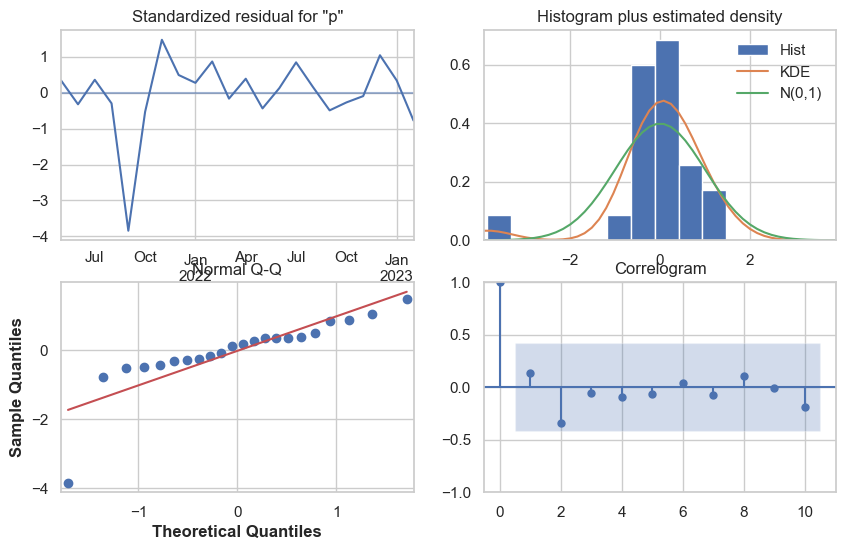

In [253]:
# Diagnostic du modèle
arima_result_categ_2.plot_diagnostics(figsize=(10, 6))
plt.show()

In [255]:
# Effectuer le test de Ljung-Box
ljung_box_result = acorr_ljungbox(residuals, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20], return_df=True)
print(ljung_box_result)

      lb_stat  lb_pvalue
1    0.569930   0.450287
2    3.505088   0.173332
3    3.533664   0.316422
4    4.080699   0.395195
5    5.332065   0.376712
6    5.355416   0.499101
7    5.363211   0.615730
8    5.774075   0.672522
9    5.775506   0.762159
10   6.622972   0.760495
11   6.624672   0.828613
12   6.962753   0.860065
14   7.351234   0.920323
16   9.703249   0.881659
18  10.769261   0.903890
20  11.064258   0.944539


Le modèle ne présente pas d'autocorrélations. Pour autant, celui-ci n'est pas un bruit blanc gaussien car les conditions de validité ne sont pas toutes respectées (pas de distribution normale).

La prédiction avec ce modèle est testée malgré tout. En revanche, la qualité des prévisions sera impactée.

Un autre modèle est à envisager.

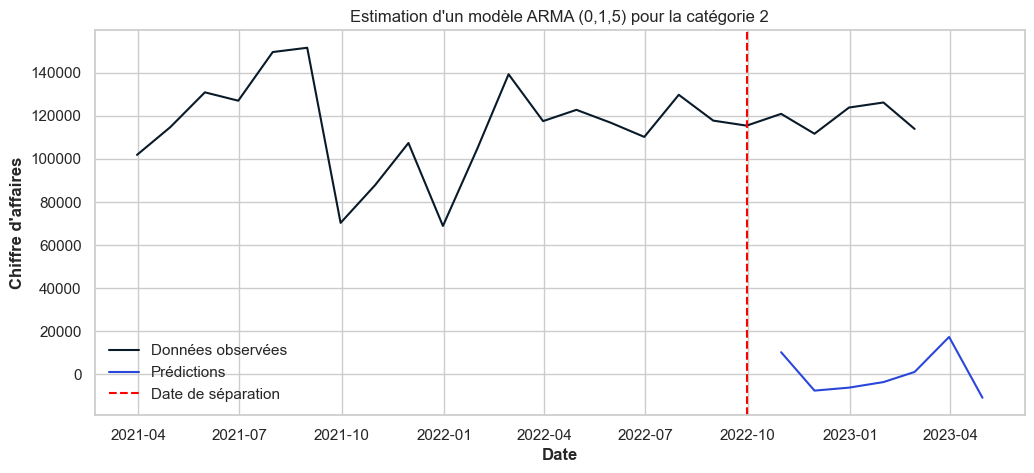

In [257]:
import datetime
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Prédiction sur une certaine période
pred = arima_result_categ_2.predict(start=18, end=24)  # Ajustez les indices si nécessaire

# Définir le thème
sns.set_theme(style="whitegrid")

# Visualisation des données observées
plt.plot(categ_mensuelle_2, label='Données observées', color='#091A29')

# Visualisation des prédictions
plt.plot(pred, color='#2B47D9', label='Prédictions')

# Ajout de la ligne verticale à une date spécifique (ici, 30 septembre 2022)
plt.axvline(x=datetime.datetime(2022, 9, 30), color='red', linestyle='--', label='Date de séparation')

# Ajouter des légendes et titres
plt.title('Estimation d\'un modèle ARMA (0,1,5) pour la catégorie 2')
plt.xlabel('Date')
plt.ylabel('Chiffre d\'affaires')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


Accuracy et performances du modèle

In [258]:
# Calculer le MAE
mae = np.mean(np.abs(categ_mensuelle_2 - pred))

# Calculer le MSE
mse = np.mean((categ_mensuelle_2 - pred) ** 2)

# Calculer le RMSE
rmse = np.sqrt(mse)

# Calculer le MAPE
mape = np.mean(np.abs((categ_mensuelle_2 - pred) / categ_mensuelle_2)) * 100

# Afficher les résultats
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 120480.48865912654
MSE: 14582474124.721485
RMSE: 120757.9153708836
MAPE: 101.0442633139451%


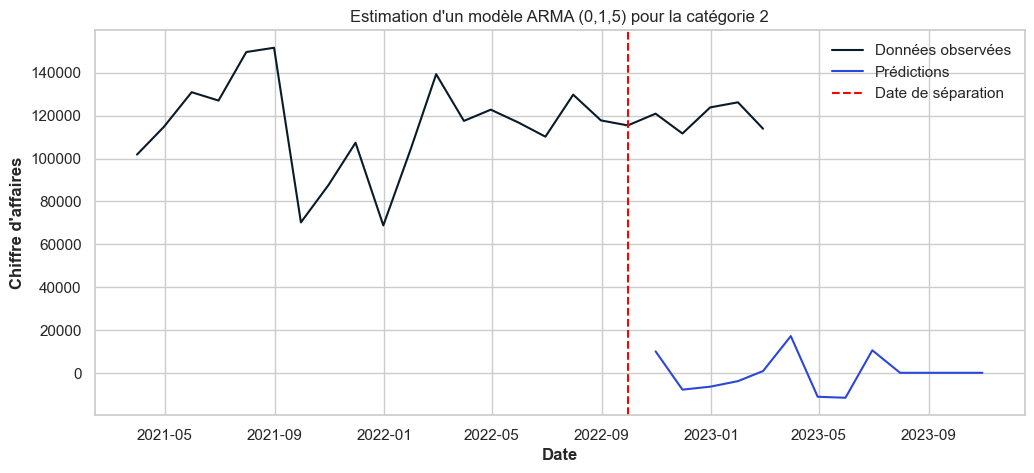

In [260]:
import datetime
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Prédiction sur une certaine période
pred = arima_result_categ_2.predict(start=18, end=30)  # Ajustez les indices si nécessaire

# Définir le thème
sns.set_theme(style="whitegrid")

# Visualisation des données observées
plt.plot(categ_mensuelle_2, label='Données observées', color='#091A29')

# Visualisation des prédictions
plt.plot(pred, color='#2B47D9', label='Prédictions')

# Ajout de la ligne verticale à une date spécifique (ici, 30 septembre 2022)
plt.axvline(x=datetime.datetime(2022, 9, 30), color='red', linestyle='--', label='Date de séparation')

# Ajouter des légendes et titres
plt.title('Estimation d\'un modèle ARMA (0,1,5) pour la catégorie 2')
plt.xlabel('Date')
plt.ylabel('Chiffre d\'affaires')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

Estimer un modèle Naive Saisonnier

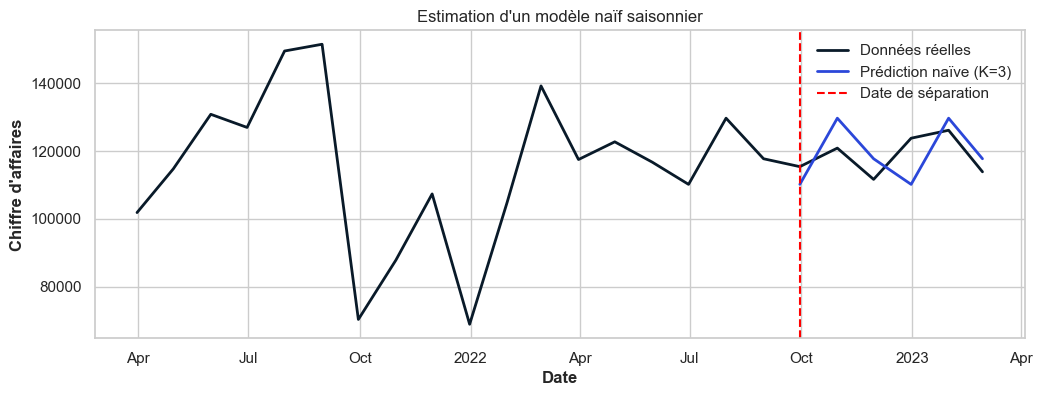

MAE: 6870.323333333329
MSE: 59350623.53849995
RMSE: 7703.935587639603
MAPE: 5.755151773564669%


In [261]:
import matplotlib.pyplot as plt
from darts.models import NaiveSeasonal
from darts.metrics import mae, mse, rmse, mape

# Diviser les données en train et validation (6 derniers mois pour validation)
train_3, val_3 = serie_mensuelle_categ_2_ts[:-6], serie_mensuelle_categ_2_ts[-6:]

# Créer un modèle naïf saisonnier avec K=3
naive_model_3 = NaiveSeasonal(K=3)
naive_model_3.fit(train_3)

# Faire des prévisions sur les 6 mois de validation
naive_forecast_3 = naive_model_3.predict(len(val_3))

# Définir le thème
sns.set_theme(style="whitegrid")

# Tracer les séries réelles et prédites
plt.figure(figsize=(12, 4))
serie_mensuelle_categ_2_ts.plot(label="Données réelles", color='#091A29')
naive_forecast_3.plot(label="Prédiction naïve (K=3)", color='#2B47D9')


# Ajouter des légendes et afficher le graphique
plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.title("Estimation d\'un modèle naïf saisonnier")
plt.xlabel("Date")
plt.ylabel('Chiffre d\'affaires')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des métriques d'évaluation
mae_value = mae(val_3, naive_forecast_3)
mse_value = mse(val_3, naive_forecast_3)
rmse_value = rmse(val_3, naive_forecast_3)
mape_value = mape(val_3, naive_forecast_3)

# Afficher les résultats
print(f"MAE: {mae_value}")
print(f"MSE: {mse_value}")
print(f"RMSE: {rmse_value}")
print(f"MAPE: {mape_value}%")


Prévision du chiffre d'affaires à un horizon de 3 mois

In [262]:
from darts.models import NaiveSeasonal
import numpy as np
import matplotlib.pyplot as plt

# Diviser les données en train et validation
train, val = serie_mensuelle_categ_2_ts[:-6], serie_mensuelle_categ_2_ts[-6:]

# Créer et ajuster le modèle NaiveSeasonal
naive_model = NaiveSeasonal(K=3)
naive_model.fit(train)

# Effectuer la prévision à horizon de 6 mois
naive_forecast = naive_model.predict(9)

# Calculer les résidus sur les données d'entraînement
train_forecast = naive_model.predict(len(train))
residuals = train - train_forecast

# Calculer l'écart-type des résidus
residual_std = np.std(residuals.values())

# Définir un niveau de confiance
z_score = 1.96  # Pour un intervalle de confiance de 95%

# Convertir les valeurs de la prévision en tableau 1D
naive_forecast_values = naive_forecast.values().squeeze()

# Calculer les intervalles de confiance
lower_bound = naive_forecast_values - z_score * residual_std
upper_bound = naive_forecast_values + z_score * residual_std

# Tracer les prévisions avec les intervalles de confiance
plt.figure(figsize=(12, 5))
train.plot(label='Train', color='#091A29')
val.plot(label='Validation', color='#4BA6EE')
naive_forecast.plot(label='Prévision', color='#2B47D9')
plt.fill_between(naive_forecast.time_index, lower_bound, upper_bound, color='#D0D0D0', alpha=0.3, label='Intervalle de Confiance 95%')
plt.axvline(x= datetime.date(2022,9,30), color='red', linestyle='--', label='Date de séparation')
plt.title("Prévisions à 3 mois du chiffre d\'affaires - catégorie 2 - modèle naïf saisonnier")
plt.legend()
plt.show()

Extraire les prévisions avec les intervalles de confiance sous forme de tableau.

In [263]:
# Organiser le tout dans un DataFrame
df_forecast = pd.DataFrame({
    'Date': naive_forecast.time_index,  # index temporel des prévisions
    'Prévision': naive_forecast_values,
    'Borne Inférieure (95%)': lower_bound,
    'Borne Supérieure (95%)': upper_bound
})

# Afficher le DataFrame des prévisions avec les intervalles de confiance
print(df_forecast)

        Date  Prévision  Borne Inférieure (95%)  Borne Supérieure (95%)
0 2022-09-30  110169.20            68070.363474           152268.036526
1 2022-10-31  129716.40            87617.563474           171815.236526
2 2022-11-30  117734.42            75635.583474           159833.256526
3 2022-12-31  110169.20            68070.363474           152268.036526
4 2023-01-31  129716.40            87617.563474           171815.236526
5 2023-02-28  117734.42            75635.583474           159833.256526
6 2023-03-31  110169.20            68070.363474           152268.036526
7 2023-04-30  129716.40            87617.563474           171815.236526
8 2023-05-31  117734.42            75635.583474           159833.256526


Estimer un modèle Holt-Winters

c:\Users\jerem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


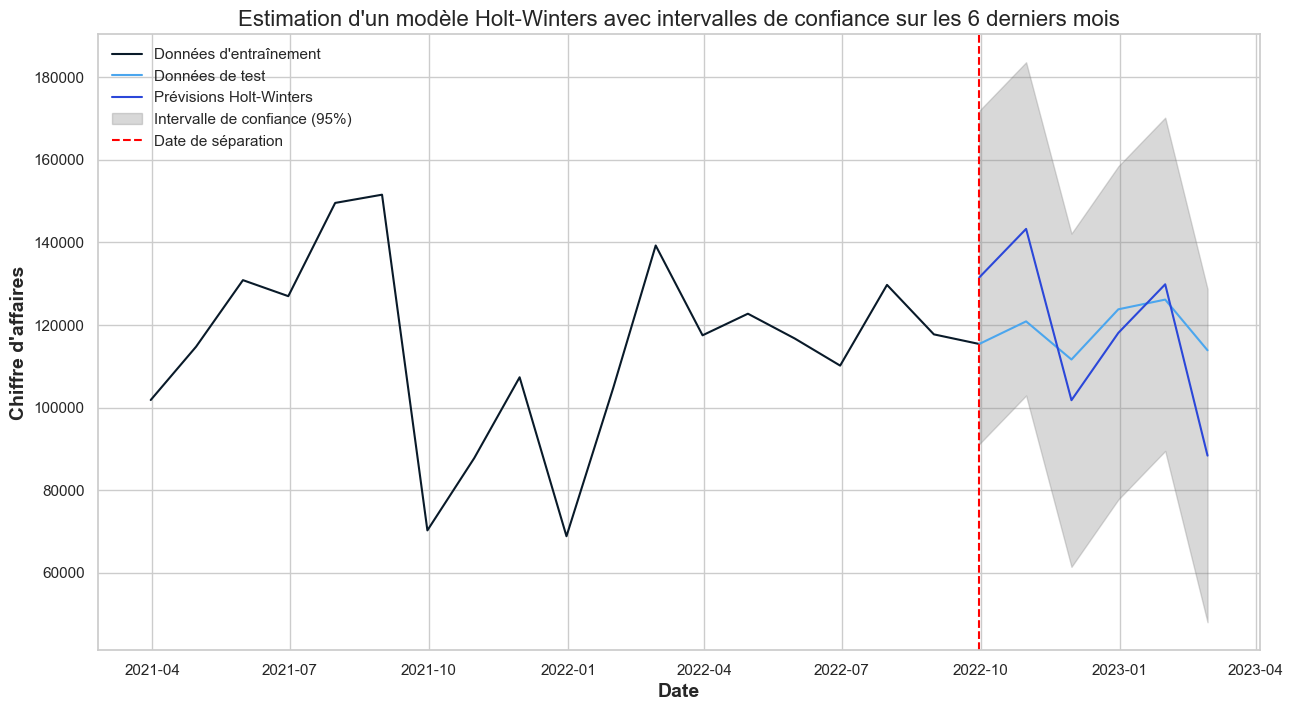

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Supposons que categ_mensuelle_2 est votre série temporelle avec un index de dates
# Définir la date de séparation pour les 6 derniers mois
date_separation = categ_mensuelle_2.index[-6]  # Date correspondant au début des 6 derniers mois

# Diviser les données en données d'entraînement et de test
train_data = categ_mensuelle_2[:date_separation]  # Données d'entraînement
test_data = categ_mensuelle_2[date_separation:]  # Données de test (les 6 derniers mois)

# Ajuster le modèle Holt-Winters sur les données d'entraînement
holt_winters_model = ExponentialSmoothing(
    train_data,
    trend='add',  # ou 'mul' selon vos données
    seasonal='add',  # ou 'mul' selon vos données
    seasonal_periods=3  # Ajuster selon la périodicité de votre série
).fit()

# Faire la prévision pour les 6 derniers mois
pred = holt_winters_model.forecast(steps=len(test_data))

# Calculer les résidus sur les données d'entraînement
residuals = train_data - holt_winters_model.fittedvalues
std_error = np.std(residuals)  # Écart-type des résidus

# Calculer les intervalles de confiance
confidence_interval_upper = pred + 1.96 * std_error  # Limite supérieure à 95%
confidence_interval_lower = pred - 1.96 * std_error  # Limite inférieure à 95%

# Définir le thème de visualisation
sns.set_theme(style="whitegrid")

# Tracer le graphique
plt.figure(figsize=(15, 8))

# Visualiser les données d'entraînement
plt.plot(train_data, label='Données d\'entraînement', color='#091A29')

# Visualiser les données de test (réelles)
plt.plot(test_data, label='Données de test', color='#4BA6EE')

# Visualiser les prévisions
plt.plot(pd.date_range(start=test_data.index[0], periods=len(test_data), freq='ME'), 
         pred, color='#2B47D9', label='Prévisions Holt-Winters')

# Visualiser les intervalles de confiance
plt.fill_between(pd.date_range(start=test_data.index[0], periods=len(test_data), freq='ME'),
                 confidence_interval_lower, confidence_interval_upper, color='gray', alpha=0.3, label='Intervalle de confiance (95%)')

# Ajouter la date de séparation
plt.axvline(x=date_separation, color='red', linestyle='--', label='Date de séparation')

# Ajouter des légendes et des titres
plt.title('Estimation d\'un modèle Holt-Winters avec intervalles de confiance sur les 6 derniers mois', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Chiffre d\'affaires', fontsize=14)
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


 Extraire les prévisions ainsi que leurs intervalles de confiance sous forme de tableau.

In [265]:
# Créer un DataFrame avec les prévisions et les intervalles de confiance
forecast_table = pd.DataFrame({
    'Date': pd.date_range(start=test_data.index[0], periods=len(test_data), freq='ME'),
    'Prévision': pred.values,
    'Borne Inférieure (95%)': confidence_interval_lower.values,
    'Borne Supérieure (95%)': confidence_interval_upper.values
})

# Afficher le tableau
print(forecast_table)

        Date      Prévision  Borne Inférieure (95%)  Borne Supérieure (95%)
0 2022-09-30  131508.479607            91160.489395           171856.469819
1 2022-10-31  143275.991739           102928.001528           183623.981951
2 2022-11-30  101792.903165            61444.912953           142140.893376
3 2022-12-31  118090.842815            77742.852604           158438.833027
4 2023-01-31  129858.354948            89510.364736           170206.345160
5 2023-02-28   88375.266373            48027.276161           128723.256585


Accuracy et performances du modèle Holt-Winters

In [266]:
import numpy as np

# Calcul du MAE
mae_value = np.mean(np.abs(test_data - pred))

# Calcul du MSE
mse_value = np.mean((test_data - pred)**2)

# Calcul du RMSE
rmse_value = np.sqrt(mse_value)

# Calcul du MAPE
mape_value = np.mean(np.abs((test_data - pred) / test_data)) * 100

# Afficher les résultats
print(f"MAE: {mae_value:.2f}")
print(f"MSE: {mse_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAPE: {mape_value:.2f}%")


MAE: 17663.64
MSE: 383711518.22
RMSE: 19588.56
MAPE: 15.07%
